# 1 Data cleaning
    Build dataframes for analysis, for now GB and USA, GB series goes from 2000-2019, limitation due UK VIX (VFTSEIX) only runs to 2019.
    USA series runs from 1990 to 2016, limitation due to topics only being available until 2016 by Andrés.

In [636]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import networkx as nx
from datetime import datetime

import os
#EXCEL FORMATTING.
from openpyxl import load_workbook
from openpyxl.styles import Alignment



import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV, RidgeCV

# Standardize the data.
from sklearn.preprocessing import StandardScaler, RobustScaler

In [637]:
os.getcwd()

'/Users/elenalarrauri/Desktop/BDE_summer_2024/EPU'

In [638]:
#CHANGE THIS DIRECTORY TO WHEREVER THE THE EPU FOLDER IS IN YOUR COMPUTER
#KEEP DIRECTORY STRUCTURE OF EPU folder, raw intermediate,etc.
os.chdir('/Users/elenalarrauri/Desktop/BDE_summer_2024/EPU')

In [639]:
#Subdirectories, redo my directory structure a bit, it's mostly fine.
plots="results/plots/"

## 1.1 Individual country dataframes

### USA dataframe.
    Datasources:
    -USA topics labeled by Andrés until 2016
    -Jurado data comes from Sydney Ludvigson's website: WHICH HORIZON OF UNCERTAINTY DOES REDL USE!!!??? Check on future date. For now the df_usa will use 1 month ahead uncertainty. 3 month and 1 year ahead uncertainty also available.
    -VIX from FRED: monthly average from daily series.
    -EPU from official website, this dataframe uses the news only based EPU index for the US, that is, not the EPU based on 3 factors

In [642]:
#VIX from FRED:
usa_vix = pd.read_csv('raw/Uncertainty-measures/VIX/VIXCLS_monthly_average.csv')
usa_vix.rename(columns={'DATE':'date'},inplace=True)
usa_vix['date'] = pd.to_datetime(usa_vix['date'])


usa_vix = usa_vix[usa_vix['VIXCLS']!='.']
usa_vix['VIXCLS']= usa_vix['VIXCLS'].astype(float)
usa_vix

date     VIXCLS
0   1990-01-01  23.347273
1   1990-02-01  23.262632
2   1990-03-01  20.062273
3   1990-04-01  21.403500
4   1990-05-01  18.097727
..         ...        ...
409 2024-02-01  13.980476
410 2024-03-01  13.787500
411 2024-04-01  16.137727
412 2024-05-01  13.058696
413 2024-06-01  12.667000

[414 rows x 2 columns]

In [643]:
#JURADO indices from Sydney Ludvigson's website.
#THIS REMINDS ME TO CHECK WHAT HORIZON WAS REDL'S
#PICK ONE MONTH UNCERTAINTY FOR NOW, ARBITRARY AND SHOULD CHANGE
usa_jurado = pd.read_excel('raw/Uncertainty-measures/JURADO/MacroUncertaintyToCirculate.xlsx',
                         sheet_name='Macro Uncertainty',usecols=["Date","h=1"])
usa_jurado.rename(columns={'Date':'date','h=1':'Macro_Index'},inplace=True)

#FinancialUncertainty measure
usa_juradof = pd.read_excel('raw/Uncertainty-measures/JURADO/FinancialUncertaintyToCirculate.xlsx',
                         sheet_name='Financial Uncertainty',usecols=["Date","h=1"])
usa_juradof.rename(columns={'Date':'date','h=1':'Fin_Index'},inplace=True)

usa_jurado = pd.merge(usa_jurado,usa_juradof,on='date')

usa_jurado['date'] = pd.to_datetime(usa_jurado['date'])

usa_jurado

date  Macro_Index  Fin_Index
0   1960-07-01     0.609464   0.878239
1   1960-08-01     0.617019   0.893273
2   1960-09-01     0.624271   0.908933
3   1960-10-01     0.634671   0.885454
4   1960-11-01     0.663409   0.878116
..         ...          ...        ...
757 2023-08-01     0.702816   1.032073
758 2023-09-01     0.689658   1.043666
759 2023-10-01     0.692260   1.057705
760 2023-11-01     0.684563   1.073311
761 2023-12-01     0.671976   1.066643

[762 rows x 3 columns]

In [644]:
#US topics until 2016 by Andrés.
# Confirmed with Andrés these already have been divided by number of articles.
monthly_usa_topics = pd.read_excel('raw/Monthly_Time_series_labelled_USA_2016.xlsx')
monthly_usa_topics = monthly_usa_topics.add_prefix('usa_')
monthly_usa_topics.rename(columns={'usa_Date':'date'},inplace=True)
monthly_usa_topics

date  usa_Elections  usa_Fiscal Policy  usa_Europe  usa_Industry  \
0   1989-01-01       0.000406           0.000947    0.000000      0.000541   
1   1989-02-01       0.000588           0.000588    0.000000      0.000147   
2   1989-03-01       0.000252           0.000379    0.000000      0.000757   
3   1989-04-01       0.000000           0.000845    0.000141      0.000986   
4   1989-05-01       0.000272           0.000681    0.000136      0.000817   
..         ...            ...                ...         ...           ...   
327 2016-04-01       0.001762           0.001371    0.002741      0.002546   
328 2016-05-01       0.002780           0.001483    0.002410      0.001483   
329 2016-06-01       0.002617           0.001308    0.020374      0.001682   
330 2016-07-01       0.002434           0.000936    0.007491      0.001685   
331 2016-08-01       0.003404           0.000801    0.001201      0.001602   

     usa_Stock Market  usa_Literature  usa_Sports  usa_Education  \
0            0.000947        0.000000    0.000135       0.000135   
1            0.000441        0.000294    0.000147       0.000294   
2            0.000252        0.000631    0.000126       0.000126   
3            0.001408        0.000000    0.000000       0.000563   
4            0.000272        0.000272    0.000000       0.000000   
..                ...             ...         ...            ...   
327          0.002154        0.000196    0.000000       0.001175   
328          0.000741        0.000927    0.000000       0.000927   
329          0.001682        0.000374    0.000374       0.000748   
330          0.001498        0.000375    0.000562       0.001124   
331          0.000200        0.000000    0.000400       0.000200   

     usa_Global Warming  ...  usa_Politics  usa_Energy  usa_Food   usa_Law  \
0              0.000406  ...      0.000541    0.000676  0.000000  0.000947   
1              0.000147  ...      0.001176    0.000000  0.000000  0.000588   
2              0.000126  ...      0.001010    0.000631  0.000000  0.000631   
3              0.000000  ...      0.002676    0.000704  0.000000  0.000282   
4              0.000544  ...      0.003131    0.000681  0.000000  0.000272   
..                  ...  ...           ...         ...       ...       ...   
327            0.000783  ...      0.001762    0.000392  0.000000  0.000587   
328            0.000556  ...      0.002224    0.000556  0.000185  0.001112   
329            0.000000  ...      0.002617    0.000561  0.000000  0.000935   
330            0.000000  ...      0.002622    0.000749  0.000000  0.001124   
331            0.000000  ...      0.001602    0.000601  0.000000  0.000400   

     usa_Financial Investment  usa_Unkown  usa_Trade   usa_Art  \
0                    0.000676         0.0   0.000271  0.000000   
1                    0.000147         0.0   0.000147  0.000000   
2                    0.000000         0.0   0.000126  0.000000   
3                    0.000845         0.0   0.000422  0.000000   
4                    0.000544         0.0   0.000953  0.000408   
..                        ...         ...        ...       ...   
327                  0.000783         0.0   0.000196  0.000196   
328                  0.001112         0.0   0.000556  0.000371   
329                  0.003178         0.0   0.002056  0.000561   
330                  0.002809         0.0   0.000187  0.000000   
331                  0.001602         0.0   0.000000  0.000200   

     usa_Critical thinking  usa_Financial Crisis  
0                 0.000676              0.000406  
1                 0.000294              0.000735  
2                 0.000505              0.001010  
3                 0.000704              0.000563  
4                 0.000000              0.000408  
..                     ...                   ...  
327               0.001175              0.000979  
328               0.001297              0.000185  
329               0.002617              0.000561  
330             

In [645]:
#EPU: From official US website use the News based measure of the EPU.
usa_epu = pd.read_excel('raw/Uncertainty-measures/EPU/US_Policy_Uncertainty_Data.xlsx',
                        sheet_name='Main Index',
                        usecols=['Year','Month','News_Based_Policy_Uncert_Index']
                        
                        )
usa_epu = usa_epu.drop(475)
usa_epu['month'] = usa_epu['Month'].astype('int').astype('str')
usa_epu['date'] = usa_epu['Year'].astype('str')+'-'+usa_epu['month'].astype('str')
usa_epu.drop(columns=['Year','Month'],inplace=True
                    )
usa_epu.drop(columns=['month'],inplace=True)
usa_epu['date'] = pd.to_datetime(usa_epu['date'])
usa_epu

News_Based_Policy_Uncert_Index       date
0                        103.748803 1985-01-01
1                         78.313193 1985-02-01
2                        100.761475 1985-03-01
3                         84.778863 1985-04-01
4                         98.053653 1985-05-01
..                              ...        ...
470                      116.711503 2024-03-01
471                      139.412017 2024-04-01
472                      123.607521 2024-05-01
473                      144.121412 2024-06-01
474                      153.171537 2024-07-01

[475 rows x 2 columns]

In [646]:
# Merge all to dataframe for analysis.
df_usa = usa_epu.merge(
    usa_jurado,how='outer',on='date'
).merge(
    usa_vix,how='outer',on='date'
).merge(
    monthly_usa_topics,how='outer',on='date'
       )
df_usa = df_usa.dropna().reset_index(drop=True)

df_usa
#DATA FROM 1990 to 2016, part of the data that conditions sample are the newspaper topics, all others are available until 
# present day.

News_Based_Policy_Uncert_Index       date  Macro_Index  Fin_Index  \
0                         92.321494 1990-01-01     0.684426   0.907737   
1                        110.446267 1990-02-01     0.673406   0.897129   
2                        104.461408 1990-03-01     0.656946   0.904269   
3                         88.448172 1990-04-01     0.649724   0.934253   
4                         97.387936 1990-05-01     0.644502   0.967929   
..                              ...        ...          ...        ...   
315                       96.413416 2016-04-01     0.605951   0.805958   
316                       96.222333 2016-05-01     0.589631   0.781531   
317                      233.956103 2016-06-01     0.583332   0.772576   
318                      164.458401 2016-07-01     0.580315   0.774738   
319                      106.885623 2016-08-01     0.575164   0.770347   

        VIXCLS  usa_Elections  usa_Fiscal Policy  usa_Europe  usa_Industry  \
0    23.347273       0.000370           0.000986    0.000000      0.001356   
1    23.262632       0.000000           0.000815    0.000815      0.000951   
2    20.062273       0.000239           0.000957    0.000837      0.000837   
3    21.403500       0.000117           0.000937    0.000351      0.001406   
4    18.097727       0.000115           0.000921    0.001266      0.000691   
..         ...            ...                ...         ...           ...   
315  14.300476       0.001762           0.001371    0.002741      0.002546   
316  14.852857       0.002780           0.001483    0.002410      0.001483   
317  17.774545       0.002617           0.001308    0.020374      0.001682   
318  13.158500       0.002434           0.000936    0.007491      0.001685   
319  12.399565       0.003404           0.000801    0.001201      0.001602   

     usa_Stock Market  ...  usa_Politics  usa_Energy  usa_Food   usa_Law  \
0            0.001356  ...      0.001603    0.000370  0.000000  0.000370   
1            0.002038  ...      0.004620    0.000000  0.000000  0.000408   
2            0.001435  ...      0.002152    0.000478  0.000000  0.000478   
3            0.001991  ...      0.001171    0.000586  0.000000  0.000586   
4            0.000691  ...      0.001036    0.000460  0.000000  0.000345   
..                ...  ...           ...         ...       ...       ...   
315          0.002154  ...      0.001762    0.000392  0.000000  0.000587   
316          0.000741  ...      0.002224    0.000556  0.000185  0.001112   
317          0.001682  ...      0.002617    0.000561  0.000000  0.000935   
318          0.001498  ...      0.002622    0.000749  0.000000  0.001124   
319          0.000200  ...      0.001602    0.000601  0.000000  0.000400   

     usa_Financial Investment  usa_Unkown  usa_Trade   usa_Art  \
0                    0.002219     0.00000   0.000123  0.000247   
1                    0.001902     0.00000   0.000136  0.000272   
2                    0.000957     0.00012   0.000359  0.000120   
3                    0.000820     0.00000   0.000000  0.000351   
4                    0.000460     0.00000   0.000691  0.000115   
..                        ...         ...        ...       ...   
315                  0.000783     0.00000   0.000196  0.000196   
316                  0.001112     0.00000   0.000556  0.000371   
317                  0.003178     0.00000   0.002056  0.000561   
318                  0.002809     0.00000   0.000187  0.000000   
319                  0.001602     0.00000   0.000000  0.000200   

     usa_Critical thinking  usa_Financial Crisis  
0                 0.000370              0.000493  
1                 0.001223              0.000544  
2                 0.000837              0.000239  
3                 0.001289              0.000469  
4                 0.000576              0.000691  
..                     ...                   ...  
315               0.001175              0.000979  
316               0.001297              0.000185  
317           

In [647]:
#Save us dataframe.

df_usa.to_csv("intermediate/df_usa.csv")

### Uk dataframe:
    Datasources: 
    1. EPU UK from the official EPU website.
    2. Jurado from Chris Redl's data, an update from his 2018 paper, read and cite.
    3. VIX-UK(VFTSEIX) from BdE person. 
    4. Monthly UK topics from LDA in house.

   

In [649]:
#EPU
uk_epu = pd.read_excel('raw/Uncertainty-measures/EPU/UK_Policy_Uncertainty_Data.xlsx',
                        ).drop(318,axis='rows')
uk_epu['month'] = uk_epu['month'].astype('int').astype('str')
uk_epu['date'] = uk_epu['year'].astype('str')+'-'+uk_epu['month'].astype('str')
uk_epu.drop(columns=['year','month'],inplace=True
                   )
uk_epu['date'] = pd.to_datetime(uk_epu['date'])

#Reorder put date as the first column.
uk_epu

UK_EPU_Index       date
0      114.233030 1998-01-01
1       71.152468 1998-02-01
2      148.086535 1998-03-01
3      146.976789 1998-04-01
4      111.515011 1998-05-01
..            ...        ...
313    114.040669 2024-02-01
314    135.563948 2024-03-01
315    102.665847 2024-04-01
316    144.785260 2024-05-01
317    147.840867 2024-06-01

[318 rows x 2 columns]

In [650]:
#World uncertainty index, get UK. WUI_M_dataset_2024_05
uk_wui_monthly = pd.read_excel('raw/Uncertainty-measures/WUI/WUI_M_dataset_2024_05.xlsx',
                         sheet_name='T1',usecols=['GBR','date'])
print(uk_wui_monthly.dtypes)
uk_wui_monthly


date    datetime64[ns]
GBR            float64
dtype: object


date       GBR
0   2008-01-01  0.221557
1   2008-02-01  0.205698
2   2008-03-01  0.210305
3   2008-04-01  0.106633
4   2008-05-01  0.404735
..         ...       ...
192 2024-01-01  0.450653
193 2024-02-01  0.449438
194 2024-03-01  0.388727
195 2024-04-01  0.363557
196 2024-05-01  0.289457

[197 rows x 2 columns]

In [651]:
# WUI but quarterly, longer series.
uk_wui_quarterly = pd.read_excel('raw/Uncertainty-measures/WUI/WUI_data.xlsx',
                         sheet_name='T2',usecols=['year','GBR'])
uk_wui_quarterly

year       GBR
0    1952q1       NaN
1    1952q2       NaN
2    1952q3       NaN
3    1952q4       NaN
4    1953q1  0.248509
..      ...       ...
284  2023q1  0.444321
285  2023q2  0.293600
286  2023q3  0.149790
287  2023q4  0.224232
288  2024q1  0.451205

[289 rows x 2 columns]

In [652]:
# BBD for UK, get it. IndexData_13-Nov-2023-redluk-updated2023

In [653]:
uk_jurado = pd.read_excel('raw/Uncertainty-measures/JURADO/IndexData_13-Nov-2023-redluk-updated2023.xlsx',
                         sheet_name='UK',usecols=["Date","Macro_Index","Fin_Index"])
#Check dataset and paper, it seems he includes which variables cause index to spike 
# in different time periods.

In [654]:
uk_jurado['date'] = uk_jurado['Date'].astype('str').str.slice(0,7)
uk_jurado['date'] = pd.to_datetime(uk_jurado['date'])
uk_jurado.drop(columns=['Date'],inplace=True)
uk_jurado

Macro_Index  Fin_Index       date
0            NaN        NaN 1988-01-01
1            NaN        NaN 1988-02-01
2            NaN        NaN 1988-03-01
3            NaN        NaN 1988-04-01
4            NaN        NaN 1988-05-01
..           ...        ...        ...
424     0.923678   1.063279 2023-05-01
425     0.583698   0.858527 2023-06-01
426     0.599095   0.384851 2023-07-01
427     0.293149  -0.108065 2023-08-01
428    -0.100953   0.545415 2023-09-01

[429 rows x 3 columns]

In [655]:
#Check how to download only one column from excel file. There seems to be some kind of problem
uk_vix = pd.read_excel('raw/Uncertainty-measures/VIX/VOLATILIDAD_Bolsas_2000.xlsx',
                     usecols=['VFTSEIX','Code']
                    )
uk_vix['date'] = uk_vix['Code'].astype('str').str.slice(0,7)
uk_vix['date'] = pd.to_datetime(uk_vix['date'])
uk_vix.drop(columns=['Code'],inplace=True)
uk_vix

VFTSEIX       date
0      27.487 2000-01-01
1      29.972 2000-02-01
2      24.747 2000-03-01
3      25.839 2000-04-01
4      25.163 2000-05-01
...       ...        ...
6342      NaN        NaT
6343      NaN        NaT
6344      NaN        NaT
6345      NaN        NaT
6346      NaN        NaT

[6347 rows x 2 columns]

#### New data:
    ¡Modify the procedure of the components of the X's! According to new standarization procedure: 04/09/2024.
    European country topics unti may26 .
    Be careful with country!!!

In [657]:
monthly_uk_topics = pd.read_excel('raw/EPU_AllTopics_ActMay28.xlsx',sheet_name='GB')
#Add prefix to topics to identify.
monthly_uk_topics = monthly_uk_topics.add_prefix('gb_')


monthly_uk_topics.rename(columns={'gb_date':'date'},inplace=True)
monthly_uk_topics.rename(columns={'gb_Num_Art':'Num_Art'},inplace=True)


monthly_uk_topics
#print(monthly_uk_topics.dtypes) This year-month will need to be converted in the end to another type of variable

date  gb_public_health_social_services  gb_local_governance  \
0   1997-01-31                          1.737450             0.504657   
1   1997-02-28                          1.739186             0.797571   
2   1997-03-31                          2.066655             0.812322   
3   1997-04-30                          1.264723             0.779940   
4   1997-05-31                          1.285195             0.661538   
..         ...                               ...                  ...   
324 2024-01-31                         12.151549             6.109078   
325 2024-02-29                         18.367318             5.423014   
326 2024-03-31                         15.673830             6.785840   
327 2024-04-30                         16.742970             6.946454   
328 2024-05-31                         22.461821             6.382238   

     gb_fiscal  gb_economic_forecast  gb_reflection  \
0     4.200331              3.429253       3.915269   
1     2.400499              5.892322       6.384852   
2     3.740650              4.800135       5.125977   
3     4.142942              8.469251       5.388089   
4     4.038917              2.380510       4.890888   
..         ...                   ...            ...   
324  23.004056             62.412567      31.222897   
325  32.309195             56.542753      31.857363   
326  33.746299             35.591989      30.403074   
327  18.491949             61.118979      31.353862   
328  24.533092             53.764630      31.684856   

     gb_middle_east_geopolitics     gb_law  gb_energy_climate  \
0                      0.167595   1.233604           0.643031   
1                      0.082568   1.521472           1.135792   
2                      0.160601   1.574429           0.971513   
3                      0.047304   1.033247           0.676124   
4                      0.351412   1.392879           0.651786   
..                          ...        ...                ...   
324                   16.557402  26.342390          15.113865   
325                    8.901621  23.411206          20.390235   
326                    4.349846  25.836803          17.417029   
327                   13.208083  26.351707          13.567421   
328                    7.166819  25.124430          15.328969   

     gb_global_trade  ...  gb_eu_regulation.2  gb_travel_leisure  gb_pandemic  \
0           1.012268  ...            1.294091           0.399918     0.427723   
1           0.950771  ...            1.814613           0.659767     0.524673   
2           1.444614  ...            0.396992           0.477218     0.746027   
3           0.828792  ...            0.998937           0.227884     0.484476   
4           0.101497  ...            0.552295           0.280011     0.218680   
..               ...  ...                 ...                ...          ...   
324        10.964521  ...            6.206939           3.627291     3.829905   
325         6.781431  ...            7.917216           3.898027     3.707358   
326         8.022290  ...            5.802395           2.702838     4.381167   
327         8.345223  ...            6.289309           3.831222     3.914146   
328         7.615581  ...            9.278735           2.692037     3.243943   

     gb_labour_manufacturing  gb_monetary  gb_eu_debt  gb_american_politics  \
0                   1.109693     3.768964    1.322432              0.317591   
1                   0.449693     4.575372    4.278028              0.308220   
2                   0.963431     3.751711    3.307275              0.432140   
3                   1.125016     3.451934    3.854365              0.223355   
4                   0.721649     4.657881    2.945277              0.318226   
..                       ...          ...         ...                   ...   
324                 8.224585    29.284744    3.911639             20.547689   
325                 7.097048    24.469237    2.423988             13.188023   
326    

In [658]:
# Change date format 
monthly_uk_topics['date'] = monthly_uk_topics['date'].astype('str').str.slice(0,7)
monthly_uk_topics['date'] = pd.to_datetime(monthly_uk_topics['date'])

#### 2 Dataframes here, one with X/Num art and the other with X
    

In [660]:
# Make a copy
monthly_uk_topics_nodiv = monthly_uk_topics.copy()


#Choose all columns that have to be divided and use.div which divides row wise. Num Art is correct variable to divide by.

divide = [name for name in monthly_uk_topics.columns.tolist() if name.startswith('gb')]
monthly_uk_topics[divide] = monthly_uk_topics[divide].div(monthly_uk_topics['Num_Art'],axis=0)

In [661]:
# Drop gb_All, Num_Art, gb_Num_Sel

# No division dataframe
monthly_uk_topics_nodiv.drop(columns=['gb_All','Num_Art','gb_Num_Sel'],inplace=True)

#Division by number of articles dataframe.
monthly_uk_topics.drop(columns=['gb_All','Num_Art','gb_Num_Sel'],inplace=True)
monthly_uk_topics

date  gb_public_health_social_services  gb_local_governance  \
0   1997-01-01                          0.000330             0.000096   
1   1997-02-01                          0.000329             0.000151   
2   1997-03-01                          0.000345             0.000135   
3   1997-04-01                          0.000229             0.000141   
4   1997-05-01                          0.000238             0.000122   
..         ...                               ...                  ...   
324 2024-01-01                          0.000728             0.000366   
325 2024-02-01                          0.001133             0.000334   
326 2024-03-01                          0.000938             0.000406   
327 2024-04-01                          0.001041             0.000432   
328 2024-05-01                          0.001517             0.000431   

     gb_fiscal  gb_economic_forecast  gb_reflection  \
0     0.000797              0.000651       0.000743   
1     0.000454              0.001114       0.001207   
2     0.000624              0.000800       0.000855   
3     0.000749              0.001532       0.000975   
4     0.000747              0.000440       0.000904   
..         ...                   ...            ...   
324   0.001379              0.003741       0.001871   
325   0.001993              0.003487       0.001965   
326   0.002020              0.002131       0.001820   
327   0.001149              0.003799       0.001949   
328   0.001657              0.003631       0.002140   

     gb_middle_east_geopolitics    gb_law  gb_energy_climate  gb_global_trade  \
0                      0.000032  0.000234           0.000122         0.000192   
1                      0.000016  0.000288           0.000215         0.000180   
2                      0.000027  0.000263           0.000162         0.000241   
3                      0.000009  0.000187           0.000122         0.000150   
4                      0.000065  0.000258           0.000121         0.000019   
..                          ...       ...                ...              ...   
324                    0.000992  0.001579           0.000906         0.000657   
325                    0.000549  0.001444           0.001258         0.000418   
326                    0.000260  0.001547           0.001043         0.000480   
327                    0.000821  0.001638           0.000843         0.000519   
328                    0.000484  0.001697           0.001035         0.000514   

     ...  gb_political.1  gb_eu_regulation.1  gb_political.2  \
0    ...        0.000545            0.000099        0.000544   
1    ...        0.000414            0.000080        0.000672   
2    ...        0.000374            0.000052        0.000544   
3    ...        0.000495            0.000080        0.000429   
4    ...        0.000713            0.000051        0.000511   
..   ...             ...                 ...             ...   
324  ...        0.001649            0.000355        0.001494   
325  ...        0.001981            0.000240        0.001228   
326  ...        0.001494            0.000195        0.001378   
327  ...        0.001383            0.000261        0.001159   
328  ...        0.003310            0.000226        0.002048   

     gb_eu_regulation.2  gb_travel_leisure  gb_pandemic  \
0              0.000246           0.000076     0.000081   
1              0.000343           0.000125     0.000099   
2              0.000066           0.000080     0.000124   
3              0.000181           0.000041     0.000088   
4              0.000102           0.000052     0.000040   
..                  ...                ...          ...   
324            0.000372           0.000217     0.000230   
325            0.000488           0.000240     0.000229   
326            0.000347           0.000162     0.000262   
327            0.000391           0.000238     0.000243   
328            0.000627           0.000182     0.000219   

     gb_labour_manufa

###### Deprecated
    Now using latest data from Marina EPU_AllTopics_ActMay28
    This data comes with variable labels already.
    
    monthly_uk_topics = pd.read_csv('intermediate/monthly_time_series/monthly_lda30_GB_feb24.csv')
    monthly_uk_topics
    #print(monthly_uk_topics.dtypes) This year-month will need to be converted in the end to another type of variable

###### df_uk
Merge all files by using 'date' as identifier.

In [664]:
df_uk = uk_epu.merge(
    uk_jurado,how='outer',on='date'
).merge(
    uk_wui_monthly,how='outer',on='date'
).merge(
    uk_vix,how='outer',on='date'
).merge(monthly_uk_topics,how='outer',on='date')


In [665]:
#Alternative uk dataset with no division.
df_uk_alt = uk_epu.merge(
    uk_jurado,how='outer',on='date'
).merge(
    uk_wui_monthly,how='outer',on='date'
).merge(
    uk_vix,how='outer',on='date'
).merge(monthly_uk_topics_nodiv,how='outer',on='date')

df_uk_alt = df_uk_alt.drop(columns=['GBR'])
#Time period for which we have all measures is 2000 to 2019 which is when vftseix was discontinued
df_uk_alt = df_uk_alt.dropna().reset_index(drop=True)

    Drop GBR, which is from the world uncertainty index as the monthly time series is too short

In [667]:
df_uk = df_uk.drop(columns=['GBR'])
#Time period for which we have all measures is 2000 to 2019 which is when vftseix was discontinued
df_uk = df_uk.dropna().reset_index(drop=True)

df_uk

UK_EPU_Index       date  Macro_Index  Fin_Index  VFTSEIX  \
0       53.748451 2000-01-01     0.261474   0.833365   27.487   
1       58.396511 2000-02-01    -0.199105   0.272030   29.972   
2       61.960393 2000-03-01    -0.316433  -0.010804   24.747   
3      114.010429 2000-04-01    -0.036278  -0.457390   25.839   
4       46.368325 2000-05-01    -0.140559  -0.447766   25.163   
..            ...        ...          ...        ...      ...   
229    196.959465 2019-02-01    -0.274517  -0.718183   13.475   
230    212.782542 2019-03-01    -0.346441  -0.478022   13.146   
231    135.518480 2019-04-01    -0.045826  -0.654455   10.640   
232    158.682606 2019-05-01    -0.034417  -0.417709   12.830   
233    149.805601 2019-06-01     0.316783  -0.711253   11.352   

     gb_public_health_social_services  gb_local_governance  gb_fiscal  \
0                            0.000424             0.000122   0.000337   
1                            0.000233             0.000170   0.000375   
2                            0.000544             0.000136   0.000745   
3                            0.000225             0.000247   0.000217   
4                            0.000230             0.000210   0.000332   
..                                ...                  ...        ...   
229                          0.001339             0.000624   0.001874   
230                          0.001434             0.000355   0.002440   
231                          0.001104             0.000330   0.001085   
232                          0.001193             0.000420   0.001318   
233                          0.000948             0.000489   0.001212   

     gb_economic_forecast  gb_reflection  ...  gb_political.1  \
0                0.000509       0.000723  ...        0.000167   
1                0.000564       0.000770  ...        0.000376   
2                0.000651       0.000884  ...        0.000315   
3                0.000689       0.001486  ...        0.000245   
4                0.001071       0.000800  ...        0.000195   
..                    ...            ...  ...             ...   
229              0.009225       0.002560  ...        0.002422   
230              0.008633       0.002818  ...        0.003042   
231              0.009134       0.002218  ...        0.002025   
232              0.006820       0.002237  ...        0.002767   
233              0.007202       0.002728  ...        0.002789   

     gb_eu_regulation.1  gb_political.2  gb_eu_regulation.2  \
0              0.000106        0.000431            0.000142   
1              0.000069        0.000327            0.000262   
2              0.000141        0.000450            0.000091   
3              0.000111        0.000533            0.000192   
4              0.000108        0.000444            0.000125   
..                  ...             ...                 ...   
229            0.002751        0.001940            0.002889   
230            0.003050        0.001485            0.002767   
231            0.001721        0.001792            0.002118   
232            0.001525        0.001939            0.001378   
233            0.001573        0.001854            0.001187   

     gb_travel_leisure  gb_pandemic  gb_labour_manufacturing  gb_monetary  \
0             0.000101     0.000142                 0.000151     0.000670   
1             0.000108     0.000034                 0.000116     0.000361   
2             0.000093     0.000086                 0.000493     0.000530   
3             0.000135     0.000152                 0.000545     0.000600   
4             0.000046     0.000114                 0.000246     0.001099   
..                 ...          ...                      ...          ...   
229           0.000397     0.000328                 0.001922     0.002155   
230           0.000244     0.000210                 0.000914     0.001800   
231           0.000523     0.000206                 0.000792     0.001402   
232           0.000280     0.000245    

In [668]:
df_uk.to_csv("intermediate/df_uk.csv")

### France and Germany
    13/09 US and UK obviously done.
    Germany and France are the 2 others that are easily available. Check out exactly what VDAXNEW is, compared to VDAX...
    Spain has VIBEX (vix) but series is too short.
    EU is left to do as the aggregation is not straightforward.
    
    -MY ANALYSIS CLASS REQUIRES ALL TOPICS TO HAVE A PREFIX WITH COUNTRY CODE, REVIEW.

Filenames vix is this one: VOLATILIDAD_Bolsas_2000.xlsx'
JURADO: Full_Data-redl2018.csv
EPU: France_Germany_Policy_Uncertainty_Data.xlsx


In [671]:
path_vix = "raw/Uncertainty-measures/VIX/"
path_jurado = "raw/Uncertainty-measures/JURADO/"
path_epu = "raw/Uncertainty-measures/EPU/"

In [672]:
#VIX
france_germany_vix = pd.read_excel(path_vix+'/VOLATILIDAD_Bolsas_2000.xlsx',
                     usecols=['VDAXNEW','CACVOLI','Code']
                    )
france_germany_vix['date'] = france_germany_vix['Code'].astype('str').str.slice(0,7)
france_germany_vix['date'] = pd.to_datetime(france_germany_vix['date'])
france_germany_vix.drop(columns=['Code'],inplace=True)

In [673]:
france_germany_vix['date'] = france_germany_vix['date'].astype('str').str.slice(0,7)
france_germany_vix['date'] = pd.to_datetime(france_germany_vix['date'])
#france_germany_vix.drop(columns=['Code'],inplace=True)
france_germany_vix

CACVOLI  VDAXNEW       date
0      26.231    30.01 2000-01-01
1      27.799    31.97 2000-02-01
2      25.969    27.53 2000-03-01
3      25.975    27.21 2000-04-01
4      27.819    26.24 2000-05-01
...       ...      ...        ...
6342      NaN      NaN        NaT
6343      NaN      NaN        NaT
6344      NaN      NaN        NaT
6345      NaN      NaN        NaT
6346      NaN      NaN        NaT

[6347 rows x 3 columns]

In [674]:
france_vix = france_germany_vix[['CACVOLI','date']]
germany_vix = france_germany_vix[['VDAXNEW','date']]

In [675]:
#JURADO
france_jurado = pd.read_excel(io=path_jurado+'Full_Data-redl2018.csv',
                         sheet_name='France',usecols=["Date","Macro_Index","Fin_Index"])
#Check dataset and paper, it seems he includes which variables cause index to spike 
# in different time periods.

germany_jurado = pd.read_excel(io=path_jurado+'Full_Data-redl2018.csv',
                         sheet_name='Germany',usecols=["Date","Macro_Index","Fin_Index"])

#Need date reformatting recycle the uk code.

In [676]:
for df in [germany_jurado,france_jurado]:
    df['date'] = df['Date'].astype('str').str.slice(0,7)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(columns=['Date'],inplace=True)

In [677]:
#EPU
france_germany_epu = pd.read_excel(path_epu+'France_Germany_Policy_Uncertainty_Data.xlsx',
                        ).drop(452,axis='rows')
#Dropping the row like that is a bit dirty if the time series increases but it works for now.

france_germany_epu['month'] = france_germany_epu['Month'].astype('int').astype('str')
france_germany_epu['date'] = france_germany_epu['Year'].astype('str')+'-'+france_germany_epu['month'].astype('str')
france_germany_epu.drop(columns=['Year','Month'],inplace=True
                   )
france_germany_epu['date'] = pd.to_datetime(france_germany_epu['date'])

#Reorder put date as the first column.
france_germany_epu = france_germany_epu[['Germany_News_Index','France_News_Index','date']]
france_epu = france_germany_epu[['France_News_Index','date']]
germany_epu = france_germany_epu[['Germany_News_Index','date']]

In [678]:
#WORKS FOR ANY COUNTRY IN THE EPU_AllTopics_ActMayb28.xlsx file.
#FR is France, DE is Germany/Deutschland

def process_country_topics(country_prefix):
    country_prefix_small = country_prefix.lower()
    monthly_topics = pd.read_excel('raw/EPU_AllTopics_ActMay28.xlsx',sheet_name=country_prefix)
    #Add prefix to topics to identify.
    monthly_topics = monthly_topics.add_prefix(country_prefix_small+'_')
    
    
    monthly_topics.rename(columns={country_prefix_small+'_date':'date'},inplace=True)
    monthly_topics.rename(columns={country_prefix_small+'_Num_Art':'Num_Art'},inplace=True)
    
    #REMEMBER WE ARE DIVIDING BY 
    
    monthly_topics['date'] = monthly_topics['date'].astype('str').str.slice(0,7)
    monthly_topics['date'] = pd.to_datetime(monthly_topics['date'])
    divide = [name for name in monthly_topics.columns.tolist() if name.startswith(country_prefix_small)]
    monthly_topics[divide] = monthly_topics[divide].div(monthly_topics['Num_Art'],axis=0)
    monthly_topics.drop(columns=[country_prefix_small+'_All','Num_Art',country_prefix_small+'_Num_Sel'],inplace=True)

    return monthly_topics

In [679]:
monthly_fr_topics = process_country_topics(country_prefix='FR')
monthly_de_topics = process_country_topics(country_prefix='DE')

In [680]:
df_fr = france_epu.merge(
    france_jurado,how='outer',on='date'
).merge(
    france_vix,how='outer',on='date'
).merge(monthly_fr_topics,how='outer',on='date')
df_fr = df_fr.dropna().reset_index(drop=True)

df_fr



France_News_Index       date  Macro_Index  Fin_Index  CACVOLI  fr_policy  \
0            18.451338 2000-01-01    -0.665953  -0.173524   26.231   0.000626   
1            33.225143 2000-02-01    -0.430731  -0.276697   27.799   0.000740   
2            42.402660 2000-03-01    -0.268153  -0.136744   25.969   0.000681   
3            16.592833 2000-04-01     0.478653  -0.136046   25.975   0.000591   
4            55.373057 2000-05-01     0.355394  -0.111094   27.819   0.000693   
..                 ...        ...          ...        ...      ...        ...   
217         192.030587 2018-02-01    -0.189464  -1.338511   19.316   0.001458   
218         195.572139 2018-03-01    -0.355358  -1.134858   16.202   0.002189   
219         187.361105 2018-04-01    -0.440099  -1.048679   14.096   0.002179   
220         303.053908 2018-05-01    -0.627536  -1.081165   13.226   0.003800   
221         331.262075 2018-06-01    -0.525969  -0.856928   13.765   0.003280   

     fr_energy    fr_oil  fr_trade  fr_health  ...  fr_airlines  fr_society  \
0     0.000072  0.000405  0.000199   0.000039  ...     0.000053    0.000883   
1     0.000026  0.000296  0.000280   0.000010  ...     0.000040    0.000837   
2     0.000049  0.000297  0.000170   0.000017  ...     0.000105    0.000863   
3     0.000129  0.000223  0.000349   0.000012  ...     0.000075    0.000919   
4     0.000024  0.000129  0.000223   0.000019  ...     0.000104    0.000913   
..         ...       ...       ...        ...  ...          ...         ...   
217   0.000241  0.000298  0.000361   0.000027  ...     0.000137    0.001030   
218   0.000135  0.000347  0.001036   0.000022  ...     0.000094    0.001890   
219   0.000339  0.000194  0.001226   0.000032  ...     0.000079    0.001891   
220   0.000136  0.000530  0.001095   0.000037  ...     0.000280    0.002353   
221   0.000363  0.000470  0.001264   0.000071  ...     0.000191    0.001666   

     fr_share_holders  fr_monetary_policy  fr_financial_regulation  \
0            0.000358            0.000599                 0.000104   
1            0.000374            0.000754                 0.000260   
2            0.000456            0.000487                 0.000200   
3            0.000626            0.001236                 0.000183   
4            0.000523            0.001062                 0.000210   
..                ...                 ...                      ...   
217          0.000340            0.001393                 0.000351   
218          0.000159            0.000563                 0.000328   
219          0.000376            0.001132                 0.000416   
220          0.000211            0.001405                 0.000486   
221          0.000370            0.002016                 0.000656   

     fr_eu_regulation.2  fr_america  fr_journalism  fr_labour  fr_automobile  
0              0.000219    0.000196       0.000162   0.000380       0.000167  
1              0.000292    0.000174       0.000291   0.000632       0.000233  
2              0.000265    0.000159       0.000261   0.000259       0.000287  
3              0.000478    0.000208       0.000273   0.000327       0.000197  
4              0.000559    0.000219       0.000223   0.000331       0.000140  
..                  ...         ...            ...        ...            ...  
217            0.000206    0.000239       0.000062   0.000657       0.000158  
218            0.000350    0.000540       0.000130   0.000748       0.000329  
219            0.000375    0.000385       0.000111   0.000714       0.000177  
220            0.000884    0.000687       0.000161   0.001131       0.000305  
221            0.000913    0.000719       0.000137   0.000923       0.000405  

[222 rows x 35 columns]

In [681]:
df_de = germany_epu.merge(
    germany_jurado,how='outer',on='date'
).merge(
    germany_vix,how='outer',on='date'
).merge(monthly_de_topics,how='outer',on='date')
df_de = df_de.dropna().reset_index(drop=True)

df_de



Germany_News_Index       date  Macro_Index  Fin_Index  VDAXNEW  \
0             73.233990 2000-01-01     1.372428   0.553829    30.01   
1             97.358429 2000-02-01     1.438153   0.526044    31.97   
2             96.091505 2000-03-01     0.884496   0.637272    27.53   
3             69.447952 2000-04-01     1.466781   0.670173    27.21   
4            135.287133 2000-05-01     1.295022   1.257548    26.24   
..                  ...        ...          ...        ...      ...   
217           97.528966 2018-02-01    -0.044549  -1.397874    21.80   
218          113.259399 2018-03-01    -0.885415  -1.462839    19.17   
219          127.536061 2018-04-01    -0.601435  -1.297196    16.93   
220          178.885448 2018-05-01    -1.224662  -0.989564    15.88   
221          209.002053 2018-06-01    -1.054320  -1.047465    16.23   

     de_real_estate  de_politics  de_elections  de_security  de_corporations  \
0          0.000045     0.000230      0.000163     0.000176         0.000189   
1          0.000086     0.000145      0.000131     0.000058         0.000304   
2          0.000102     0.000132      0.000228     0.000247         0.000186   
3          0.000085     0.000110      0.000073     0.000087         0.000231   
4          0.000168     0.000023      0.000218     0.000211         0.000168   
..              ...          ...           ...          ...              ...   
217        0.000195     0.000741      0.000441     0.000362         0.000551   
218        0.000221     0.000901      0.001180     0.000463         0.000706   
219        0.000237     0.000286      0.000383     0.000466         0.000509   
220        0.000250     0.000597      0.001008     0.000533         0.000649   
221        0.000140     0.000759      0.000607     0.000561         0.000694   

     ...  de_world_outlook  de_labour  de_energy  de_automotive  \
0    ...          0.000780   0.000256   0.000144       0.000029   
1    ...          0.000702   0.000189   0.000176       0.000018   
2    ...          0.000669   0.000092   0.000019       0.000033   
3    ...          0.000979   0.000262   0.000006       0.000007   
4    ...          0.000698   0.000146   0.000145       0.000018   
..   ...               ...        ...        ...            ...   
217  ...          0.002677   0.000365   0.000115       0.000246   
218  ...          0.002895   0.000714   0.000266       0.000177   
219  ...          0.002106   0.000412   0.000169       0.000305   
220  ...          0.002951   0.000634   0.000213       0.000226   
221  ...          0.002887   0.000478   0.000168       0.000214   

     de_environment  de_eu_politics  de_financial_regulation  de_global_trade  \
0          0.000007        0.000205                 0.000052         0.000082   
1          0.000094        0.000261                 0.000074         0.000031   
2          0.000028        0.000352                 0.000066         0.000107   
3          0.000008        0.000209                 0.000101         0.000169   
4          0.000059        0.000115                 0.000074         0.000135   
..              ...             ...                      ...              ...   
217        0.000066        0.000845                 0.000208         0.000413   
218        0.000105        0.001124                 0.000501         0.000931   
219        0.000080        0.000960                 0.000293         0.001365   
220        0.000112        0.001857                 0.000272         0.001263   
221        0.000134        0.001348                 0.000260         0.001276   

     de_regional.1  de_economic_outlook  
0         0.000084             0.000567  
1         0.000025             0.000135  
2         0.000078             0.000240  
3         0.000023             0.000385  
4         0.000038             0.000382  
..             ...                  ...  
217       0.000108             0.000937  
218       0.000149             0.001415  
219       0.000064             0.00

In [682]:
df_fr.to_csv("intermediate/df_fr.csv")
df_de.to_csv("intermediate/df_de.csv")


## 1.2 Construct final excel sheet:
    - Each sheet with country name. 
    - All 4 uncertainty columns will have joint names. VIX, EPU, JURADO_Macro, JURADO_Fin.
    - Extra sheet explaining exactly what each uncertainty name is and source.
    - Topics will have country prefix in front of them.
    
    


In [684]:
#This is so datacleaning part doesn't have to be run each time, it is super fast so it doesn't really matter.
df_fr = pd.read_csv("intermediate/df_fr.csv",index_col=0)
df_usa = pd.read_csv("intermediate/df_usa.csv",index_col=0)
df_de = pd.read_csv("intermediate/df_de.csv",index_col=0)
df_uk = pd.read_csv("intermediate/df_uk.csv",index_col=0)


In [685]:
df_fr = df_fr.rename(columns={'CACVOLI':'VIX','Macro_Index':'JURADO_Macro','Fin_Index':'JURADO_Fin','France_News_Index':'EPU'})
df_de = df_de.rename(columns={'VDAXNEW':'VIX','Macro_Index':'JURADO_Macro','Fin_Index':'JURADO_Fin','Germany_News_Index':'EPU'})
df_usa = df_usa.rename(columns={'VIXCLS':'VIX','Macro_Index':'JURADO_Macro','Fin_Index':'JURADO_Fin','News_Based_Policy_Uncert_Index':'EPU'})
df_uk = df_uk.rename(columns={'VFTSEIX':'VIX','Macro_Index':'JURADO_Macro','Fin_Index':'JURADO_Fin','UK_EPU_Index':'EPU'})
dfs = [df_fr,df_de,df_uk,df_usa]
for df in dfs:
    
    col = df.pop('date')
    df.insert(0, 'date', col)
    
    # Temporary, somehow when importing it from csv the date should be specified as datetime for correct functioning of the analysis class.
    
    df['date'] = pd.to_datetime(df['date'])

Monthly_Time_series_labelled_USA_2016.xlsx'

In [687]:
index = {
    'VIX': ['CACVOLI, from Thomson Reuters, BdE','VDAXNEW, from Thomson Reuters, BdE','VIXCLS, from FRED', 'VFTSEIX, from Thomson Reuters, BdE '],
    'JURADO_Macro':["Macro_Index, from Chris Redl's website, 2018 working paper-https://economicresearch.shinyapps.io/uncertainty_r_shiny/",
                   "Macro_Index, from Chris Redl's website, 2018 working paper-https://economicresearch.shinyapps.io/uncertainty_r_shiny/",
                    "Macro_Index, from Sydney Ludvigson's website",
                   "Macro_Index, from Chris Redl, we asked him for it, same paper but definitive version Uncertainty matters evidence from close elections"
                   ],
    'JURADO_Fin':["Fin_Index, from Chris Redl's website, 2018 working paper-https://economicresearch.shinyapps.io/uncertainty_r_shiny/",
                   "Fin_Index, from Chris Redl's website, 2018 working paper-https://economicresearch.shinyapps.io/uncertainty_r_shiny/",
                  "Fin_Index, from Sydney Ludvigson's website",
                   "Fin_Index, from Chris Redl, we asked him for it, same paper but definitive version Uncertainty matters evidence from close elections"
                   ],
    'EPU':["France_News_Index, from official EPU website","Germany_News_Index, from official EPU website",
          "News_Based_Policy_Uncert_Index, from official EPU website","UK_EPU_Index, from official EPU website"],
    'Topics data':['From EPU_AllTopics_ActMay28.xlsx','From EPU_AllTopics_ActMay28.xlsx',
                   'From Andrés: Monthly_Time_series_labelled_USA_2016.xlsx','From EPU_AllTopics_ActMay28.xlsx'],
    
    'Country':['FRANCE','GERMANY','USA','UK']
}

In [688]:
READ_ME = pd.DataFrame(index)

In [689]:
with pd.ExcelWriter("intermediate/full_data_17_sept.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    READ_ME.to_excel(writer,sheet_name='READ ME',index=False)
    df_fr.to_excel(writer, sheet_name="FR", index=False)
    df_de.to_excel(writer, sheet_name="DE", index=False)
    df_usa.to_excel(writer, sheet_name="USA", index=False)
    df_uk.to_excel(writer, sheet_name="UK", index=False)

In [706]:
wb = load_workbook("intermediate/full_data_17_sept.xlsx")
sheet = wb['READ ME']

# Adjust column widths for the 'Fruits' sheet
for row in range(1, sheet.max_row + 1):
    sheet.row_dimensions[row].height = 50

for column_cells in sheet.columns:
    column = column_cells[0].column_letter  # Get column letter (e.g., 'A')
    
    # Set column width to 30
    sheet.column_dimensions[column].width = 30
    for cell in column_cells:
        cell.alignment = Alignment(wrap_text=True)
# Set the height for all rows to 30


# Save the adjusted workbook
wb.save("intermediate/full_data_17_sept.xlsx")

# Warning!
     When importing it from csv/excel will probs be the same the date should be specified as datetime for correct functioning of the analysis class.

# 2 Analysis class:
     Contains all the analysis conducted in one class. 
     Improve comments as well as all code, maybe a better separation of plots and models would be nicer.
     
### Descriptive statistics:
1. Correlations between different uncertainty measures. + Show visually as well Done

2. Topics, maybe a heatmap, not so pretty with 30 topics nothing clear TODO

3. This would be a great place to put network analysis when it is finished, after heatmap TODO

In [916]:
class Analysis():
    def __init__(self, df,country,country_code):

        """
        
        When initializing an instance of this class this will do some preliminaries, mainly classify
        the variables into x or y, find the time period automatically and 'save' the data inside the instance. 
        
        parameters:
            
            df : pandas.DataFrame(), Takes a pandas dataframe at the country level, that is a sheet from the full_data_17_sept.xlsx file.

            country: str, Name of the country for the analysis, non abbreviated. Can be anything.

            country_code: str, code of the country in lower caps please. This is important so the function knows which variables to 
            classify as dependent X or independent Y.
            
        """
        
        self.data = df
        self.name = country
        self.country_code = country_code
        
        #yvars is just name of variables
        #Important to name all topics with the country code as a prefix so that this works.
        
        self.yvars = [var for var in self.data.columns.to_list() if not (var.startswith(self.country_code) | var.startswith('date'))]
        self.xvars = [var for var in self.data.columns.to_list() if  (var.startswith(self.country_code))]

        
        #yvars_norm is pandas df of normalized y variables
        #Not super useful in the end
        self.yvars_norm = self.data[self.yvars].apply(lambda col: (col - col.mean())/col.std()  )
        
        #Period of analysis, yearly start and end.
        self.time_period = [self.data['date'].iloc[0].strftime("%Y"),self.data['date'].iloc[-1].strftime("%Y")]
        
    def __str__(self):
        
        """
        
        Print any instance of this class and it will return this:
        
        "Analysis of {self.name.upper()}, from {self.time_period} for EPU REBORN"
        
        """
        
        return f"Analysis of {self.name.upper()}, from {self.time_period} for EPU REBORN"
    
    def data_prep(self,chosen_yvar,Xdrop=[],norm_type="standard"):
        
        """
        
        Preps the data for analysis.

        parameters:

        chosen_yvar: str, any of the 4 uncertainty measures available.

        Xdrop: list of str, default = [], dependent variables to drop, mainly for the ones that have a 0 coefficient in Lasso regression.

            norm_type: str, default = 'standard', other = 'robust', any other string.
        'standard': substracts the mean of the whole series and divides by the standard deviation.
        
            'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
        range, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html for more details.

            other strings: only normalizes the Y variables, should not be used in the end.

        returns X,y
       
        """
        
        
        #All y vars then later remove the chosen yvar so it is not dropped as well.
        
        drop = self.yvars.copy()
        
        # Always drop date
        
        drop.append('date')
        drop.remove(chosen_yvar)
        
        #If the list is empty it will be false and so no variables need to be dropped.
        if Xdrop:
            for colname in Xdrop:
                drop.append(colname)
        
        print(f"""These are the variables that are dropped: {drop}. This is a temporary check.""")
        clean_df = self.data.drop(columns=drop)
        X = clean_df.drop(columns=chosen_yvar)
        y = clean_df[chosen_yvar]

        #After selecting the X,y we apply the standarization.
        
        if norm_type=='standard':
            
            #APPLY STANDARD SCALER FROM SKLEARN
            
            print('Applied standard scaling to the X and y')
            
            s_scaler = StandardScaler()
            
            scaled_array = s_scaler.fit_transform(X)
            
            X = pd.DataFrame(scaled_array,columns=X.columns)
            
            y =y.apply(lambda row: (row - y.mean())/y.std())
            
        elif norm_type=='robust':
            
            #APPLY ROBUST SCALER FROM SKLEARN
            
            print('Applied robust scaling to the X and y')
            r_scaler = RobustScaler()
            
            scaled_array = r_scaler.fit_transform(X)
            
            X = pd.DataFrame(scaled_array,columns=X.columns)
            
            #Need to modify the y just a bit turn it into an array for it to be in scaler.
            scaled_y = r_scaler.fit_transform(y.values.reshape(-1,1))
            
            y = pd.Series(scaled_y.flatten(),name=y.name)

        else:
            # Should not be used.
            print('Standardize only the y variable for comparison across other uncertainty measures.')
            
            
            y =y.apply(lambda row: (row - y.mean())/y.std())
        
        # May have a data leakeage issue, shouldn't be all important.
        # May be good to use robust scaler add as an option 
        # https://github.com/scikit-learn/scikit-learn/issues/26359

        #Returns the X and y ready for analysis.
        return X,y
    
    def ols(self,chosen_yvar,data_prep=[],plot=True):
        
        """
        
        Runs OLS analysis using LinearRegression from Sklearn. Then plots both the coefficients and the model fit visually.
        
        parameters
        
        chosen_yvar: "string" should be one of the uncertainty measures from the dataset, you can check which are available
        in the attribute .yvars
        
        data_prep: "list []", default [] Things to be modified in data prep, if list is empty the ols will run normally, if not, first 
        element should be list of names of variables you want to drop, it will mean you want to run ols on subset of variables 
        
        The second element of the list is the type of standarization that will be applied. Check out dataprep for available options.
        
        plot: True or False, if True it will plot the coefficients. 2 plots, coefficients and time series predicted value vs the true series.
        
        returns X for the VIF and the coefficients dataframe.
       
        """
        #Maybe this is better with kwargs.
        
        if data_prep:
            Xdrop=data_prep[0]
            norm_type=data_prep[1] 
            X,y = self.data_prep(chosen_yvar,Xdrop,norm_type)
        #THIS SEEMS PROBLEMATIC    
        else:
            #DEFAULT SETTINGS
            X,y = self.data_prep(chosen_yvar)
        ols = LinearRegression().fit(X,y)
        print(f"The score/R^2 of the model is {ols.score(X,y)}")
        
        #Get coefficients of model and convert them to pandas dataframe
        coefficients = ols.coef_
        coefficients_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients})

        # Sort the DataFrame by the absolute value of the coefficients in descending order
        coefficients_df = coefficients_df.sort_values(by="Coefficient", ascending=False)
        
        
        # Plot the data vs fit of model, visually, could also compute the score.
        # Gets OLS prediction using the X then merge yhat and y and merge data onto it
        predicted_ols = ols.predict(X)
        df_yhat = pd.merge(y,pd.DataFrame({'yhat':predicted_ols}),left_index=True,right_index=True
                          ).merge(self.data['date'],left_index=True,right_index=True)
        
        #Expects a boolean if True then it will plot.
        if plot:
            # Plotting methods defined below
            self.plot_coeff(coefficients_df,chosen_yvar,'OLS')
            #Plot fit is unnecessary drop for now.
            
            self.plot_fit(df_yhat,chosen_yvar,'OLS')
        
        return X,coefficients_df
    
    def lasso(self,chosen_yvar,alpha=1,plot=True):
    
        """
        
        Runs Lasso with specified penalization alpha, plots coefficients and model fit, same as OLS.
        
        Parameters
        
        chosen_yvar: "string" should be one of the uncertainty measures from the dataset, you can check which are available
        in the attribute .yvars
        
        alpha: int or float,  penalization of Lasso ,0 is OLS might give warning but it shouldn't be an issue. Still, just use OLS in that 
        case.

        plot: bool, default True, will plot same plots as ols.
        
        For now returns lasso object, this could be changed, CHECK. 
        CHECK also to modify the data_prep here.
        
        """
        X,y = self.data_prep(chosen_yvar)
        lasso = Lasso(alpha).fit(X,y)
        print(f"The score/R^2 of the model is {lasso.score(X,y)}")
        
        #I should try to find a better measure of fit, seems like overfitting
        
        
        # I could put most of this in functions but this seems more easy to understand, easier
        # to follow workflow.
        
        #Get coefficients of model and convert them to pandas dataframe
        coefficients = lasso.coef_
        coefficients_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients})

        # Sort the DataFrame by the absolute value of the coefficients in descending order
        coefficients_df = coefficients_df.sort_values(by="Coefficient", ascending=False)
        
        # Plot the data vs fit of model, visually, could also compute the score.
        # Gets OLS prediction using the X then merge yhat and y and merge data onto it
        predicted_lasso = lasso.predict(X)
        
        #THIS IS NOT BEST PRACTICE, IT WORKS BUT REMEMBER TO CHECK THAT DATAFRAME HAS INDEX RESET!!
        df_yhat = pd.merge(y,pd.DataFrame({'yhat':predicted_lasso}),left_index=True,right_index=True
                          ).merge(self.data['date'],left_index=True,right_index=True)
        
        if plot:
            self.plot_fit(df_yhat,chosen_yvar,f'Lasso alpha: {alpha} ')
            self.plot_coeff(coefficients_df,chosen_yvar,f'Lasso alpha: {alpha} ')

        
        # IF there is an error it is because I changed this from returning lasso to coefficient_df, but I don't think anything will change
        # as this function is not connected with much else in the end.
        return coefficients_df
        
    def variance_inflation_factor(self, Xvars):
        
        """
        
        Compute variance inflation factor as 1/(1-R^2) for an auxiliary regression of xj = a +sum_i( a1 * x_i ) for i!=j
        Do this manually, statsmodels has some implementation but I don't really trust them.

        Xvars: pandas dataframe.
        
        No option to standardize the data so these factors will have the same standardazation as the analysis where this method is called.
        That is X from analysis will be the same X here.

        Prints VIF for different variables, sorted, this can be returned instead if you want, some other functionality would need to be
        changed.
        
        """
        vif = {}
        # For each X variable become independent variable, drop that column from the X and run the regression, get the score and 1/1-r_sq 
        # is the formula for VIF.
        for column in Xvars.columns.to_list():
            y= Xvars[column]
            X = Xvars.drop(columns=column)
            ols = LinearRegression().fit(X,y)
            r_sq = ols.score(X,y)
            vif[column] = 1/(1-r_sq)
            
        vif = pd.Series(vif).sort_values(ascending=False)    
        print(vif)

    def optimal_alpha(self,chosen_yvar,normtype="standard"):
        
        """
        
        Takes all X's with whatever normalization is desired and then uses LassoCV to get an optimal alpha 
        and then returns names of all X's which have a coefficient of 0 under a lasso with alpha*.
            
        FOR REPLICABILITY THERE SHOULD BE A RANDOM STATE PARAMETER HERE IN THE FUTURE.
        
        params:

        chosen_yvar: str, pick one of the yvars, call the attribute .yvars on the object to see which are available.

        norm_type: str, default = 'standard', other = 'robust', any other string.
            'standard': substracts the mean of the whole series and divides by the standard deviation.
        
            'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
            range, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html for more details.

            other strings: only normalizes the Y variables, should not be used in the end.        
        ¡Check!:
        This is from documentation, maybe best to use grid search. Could be investigated
        
        LassoCV leads to different results than a hyperparameter search using GridSearchCV with a Lasso model. 
        In LassoCV, a model for a given penalty alpha is warm started using the coefficients of the closest model 
        (trained at the previous iteration) on the regularization path. 
        It tends to speed up the hyperparameter search.
        
        """
        
        X,y = self.data_prep(chosen_yvar=chosen_yvar,norm_type=normtype)
       
        # RANDOM STATE SHOULD BE SET FOR REPLICABILITY!!
        
        # No random state now let's see if there are big differences.
        #random state=0 for replicability.
        cv_results = LassoCV(cv=20).fit(X, y)
        coefficients = cv_results.coef_
        
        print(f"This is the optimal alpha chosen {cv_results.alpha_}")
        
        coefficients_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients})
        
        #Take names of the columns that have 0 coefficient from lasso with optimal alpha (minimizing )
        colnames0coeff = coefficients_df[coefficients_df['Coefficient']==0]['Feature'].to_list()
        
        return colnames0coeff
    
    def lasso_ridge(self,chosen_yvar,path='',normtype="standard"):
        """
        
        Comparison of coefficients between lasso and ridge, plots the results. While LassoCV searches amongst all alphas by default,
        RidgeCV searches amongst only 3 alphas 0.1, 1 , 10 by default, behaviour can be modified.
        
        Fix random state for replicability. 
        
        params:

        chosen_yvar: str, pick one of the yvars, call the attribute .yvars on the object to see which are available.

        path: str, default '', where you want to save the plot. If '' the plot is not saved.
        
        norm_type: str, default = 'standard', other = 'robust', any other string.
            'standard': substracts the mean of the whole series and divides by the standard deviation.
        
            'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
            range, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html for more details.

            other strings: only normalizes the Y variables, should not be used in the end.

        returns dataframe with coefficients of the lasso vs ridge.
        
        """
        
        X,y = self.data_prep(chosen_yvar=chosen_yvar,norm_type=normtype)

        #Fix random state for replicability.
        
        #cv=5 is the standard change to 100 for more robustness.
        # default=(0.1, 1.0, 10.0)
        # Only runs models against these 3 alhpas by default, can be changed
        # Default ridge cross validation is leave one out (it's one of those magic math things that can be computed super fast)
        #
        cv_results_ridge = RidgeCV(cv=20).fit(X, y)
        
        cv_results_lasso = LassoCV(cv=20).fit(X, y)
        
        coefficients_ridge = cv_results_ridge.coef_
        coefficients_lasso = cv_results_lasso.coef_
        
        print(f"This is the optimal alpha chosen for LASSO: {cv_results_lasso.alpha_} and for RIDGE: {cv_results_ridge.alpha_}"
             )
        coefficents_df_ridge = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients_ridge,"Estimator":"RIDGE"})
        
        coefficients_df_lasso = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients_lasso,"Estimator":"LASSO"})
        
        coefficients_df = pd.concat([coefficents_df_ridge,coefficients_df_lasso])
        #Take names of the columns that have 0 coefficient from lasso with optimal alpha (minimizing )
        
        plot_data = coefficients_df

        
        plt.figure(figsize=(12,8))
        ax = sns.barplot(plot_data,x="Coefficient",y="Feature",hue="Estimator",orient='h')
        num_feature = plot_data['Feature'].nunique()
        for i in range(num_feature-1):
            ax.axhline(i+0.5,color='gray',linestyle='--',linewidth=0.8)

        plt.title(f"Results are for {self.name} uncertainty measure: {chosen_yvar}")
        if path:
            plt.savefig(path)
        
            plt.show()
        return coefficients_df
    
    
    
    def lasso_ols(self,chosen_yvar,normtype="standard",plot=True):
        """
        
        Implements lasso with optimal alpha (in terms of minimizing root mean squared error) to select regressors,
        returns the names of regressors with 0 coefficient, these are dropped from the subsequent ols estimation.
        Then the ols method is called and it runs ols and plots the coefficients. Also prints the VIF (Variance inflation factor.)
        
        parameters:

        chosen_yvar: str, pick one of the yvars, call the attribute .yvars on the object to see which are available.
        
        norm_type: str, default = 'standard', other = 'robust', any other string.
            'standard': substracts the mean of the whole series and divides by the standard deviation.
        
            'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
            range, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html for more details.

            other strings: only normalizes the Y variables, should not be used in the end.

        plot: bool, default True, will plot the 2 plots from OLS, coefficients as well as time series fit.

        returns coefficients from ols
        
        """

        #Runs the initial lasso, with all X and chosen normalization type
        colstodrop = self.optimal_alpha(chosen_yvar,normtype)
        
        print(f'These are the cols to drop from the lasso with optimal alpha: {colstodrop}')
        
        #Ols now returns the X subset as well as the coefficients
        #The Xsubset is for the variance inflation factor, while the coefficients are for the plotting function.
        
        #Should the X's be normalized in OLS? In the end yes.
        # 12/09 we decided to standarize the X in OLS for a better interpretation.

        #THIS IS HARD CODED, as the other scaler -robust- does not have an interpretation, but it can be changed.
        
        Xsubset,coefficients = self.ols(chosen_yvar=chosen_yvar,data_prep=[colstodrop,"standard"],plot=plot)
        
        #Print the vif from the subset of covariates on which the final ols is run.
        print("This is the variance inflation factor for the remaining variables.")
        self.variance_inflation_factor(Xsubset)
        
        
        #Returns coefficients from the ols method with the reduced subset of characteristics.
        
        return coefficients
    

    # PLOTTING METHODS:
    
    def plot_descriptive_corr(self,path=""):
        
        """
        
        Returns the correlations between uncertainty measures in a heatmap.

        parameters:

        path: str, default '', where you want to save the plot. If '' the plot is not saved.

        """
        uncertainty_m_corr =self.data[self.yvars].corr()
        # No need to give option to save yet.

        #Fixes 
        sns.heatmap(uncertainty_m_corr,vmax=1,vmin=0,annot=True)
        if path:
            plt.savefig(path)
        
    def plot_uncertainty(self,path=""):
        
        """
        
        Returns time series plot of the different y measures in dataset standardized.

        parameters:
        
        path: str, default '', where you want to save the plot. If '' the plot is not saved.

        
        """
        
        yvars_plot = pd.merge(self.yvars_norm,self.data['date'],left_index=True,right_index=True)
        for dep_var in self.yvars:
            plt.plot(yvars_plot['date'], yvars_plot[dep_var] ,label=dep_var)
        plt.legend(loc='upper left')
        ## Highlighting a period
        #plt.axvspan(datetime(2008, 1, 1), datetime(2010, 1, 1), facecolor='yellow', alpha=0.5, hatch='-', edgecolor='red', linewidth=1)
        #So ugly when done like this, there should be a better way.
        plt.title(f'Uncertainty indices for the {self.name}: {self.time_period[0]}-{self.time_period[1]}')
        
        #Put option of where to save 
        if path:
            plt.savefig(path)
        plt.show()

    
    def plot_coeff(self,coefficients_df,chosen_yvar,estimation_type):
        """
        
        Takes data on coefficients from a particular model and plots them sorted by magnitude.
        Called interally in other methods, ols and lasso

        params:

        coefficients_df: pandas.DataFrame()
        
        chosen_yvar and estimation_type is just to plot the title.
        
        """ 
        plt.figure(figsize=(10, 6))
        plt.barh(coefficients_df["Feature"], coefficients_df["Coefficient"])
        plt.xlabel("Coefficient Value")
        plt.ylabel("Topic name")
        plt.title(f"Coefficients from {estimation_type} for {chosen_yvar} in country {self.name} ")
        plt.show()
        
    def plot_fit(self,df_yhat,chosen_yvar,method):
        """
    
        Time series plot of given uncertainty series vs the prediction by the model.
        Called internally by other methods, ols and lasso
        
        params:

        df_yhat, pandas df, should contain date plus 2 predicted value and uncertainty measure.

        
        """
        #Could have been one for both fit and uncertainty measures methods.
        
        plt.figure(figsize=(10, 6))
        plt.plot(df_yhat.date,df_yhat[chosen_yvar],label=chosen_yvar)
        plt.plot(df_yhat.date,df_yhat['yhat'],label=f'Pred values {method}')
        plt.legend(loc='upper left')
        ## Highlighting a period
        #plt.axvspan(datetime(2008, 1, 1), datetime(2010, 1, 1), facecolor='yellow', alpha=0.5, hatch='-', edgecolor='red', linewidth=1)
        #So ugly when done like this, there should be a better way.
        plt.title(f' {method} prediction for {chosen_yvar} in the {self.name}')
        plt.show()
    
    
    def plot_lasso_r(self,chosen_yvar,max_penalty,norm_type='standard',path=""):
        """
        
        Plots the coefficient values for different values of alpha, it nests OLS.
        In legend there are only the top 5 topics with highest average absolute value of coefficients 
        across alpha as this helps for readability.
        
        Parameters
        
        chosen_yvar: "string", should be one of the uncertainty measures from the dataset, you can check which are available
        in the attribute .yvars
        
        max_penalty: float/int, largest penalty that will be applied in Lasso
        
        path: "string", default '', path to where the plot is saved, if '' the plot is not saved.
        
        norm_type: str, default = 'standard', other = 'robust', any other string.
            'standard': substracts the mean of the whole series and divides by the standard deviation.
        
            'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
            range, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html for more details.

            other strings: only normalizes the Y variables, should not be used in the end.

        
        MODIFY:
        - The color palette may be stochastically tricky... Top 5 may have similar colours... -> Fix if this is shown in the end.


        returns the coefficents dataframes at different alphas, so anyone can play with how to plot.
        """
        
        #Remember LASSO has asymptotic bias that can be corrected
        
        X,y = self.data_prep(chosen_yvar,norm_type=norm_type)
        rows = []

        for penalty in np.linspace(0,max_penalty,20):
            if penalty==0:
                ols = LinearRegression().fit(X,y)
                rows.append(ols.coef_.tolist()+[penalty])
            else:    
                lasso = Lasso(penalty).fit(X,y)
                rows.append(lasso.coef_.tolist()+[penalty])
        
        
        df_coefficients =pd.DataFrame(rows,columns=X.columns.to_list()+['alpha'])
        df_coefficients.set_index('alpha',inplace=True
                                )
        #Get coefficients put in absolute values, then take mean sort values keep top 5 highest values and convert to list.
        col_legend = df_coefficients.abs().mean().sort_values(ascending=False)[0:5].index.to_list()
        
        ax = df_coefficients.plot(use_index=True,legend=False)

        # Create a mapping from column names to lines
        line_mapping = {col: line for col, line in zip(df_coefficients.columns, ax.get_lines())}
        
        # Customize the legend to include only specific columns
        columns_to_include = col_legend
        custom_lines = [line_mapping[col] for col in columns_to_include]
        ax.legend(custom_lines, columns_to_include)  # Custom labels for the selected lines
        plt.title(f"""
        Coefficient values at different Lasso penalties(alpha) for {chosen_yvar} in {self.name}

                  """)
        
        # Show the plot
        if path:
            plt.savefig(path)
            print(f"Saved file at {path}")
        plt.show()
        
        return df_coefficients
    
    def plot_coeff_all_y(self,mode='horizontal',subplot = 'NO',path="",normtype="standard",plot=False):
        """
        
        MAIN PLOT, with all of its iterations.
        
        First runs the lasso ols function, with whatever standarization is wanted. This is done for each uncertainty variable, then these
        resulting coefficients are plotted.
        
        Parameters:

        norm_type: str, default = 'standard', other = 'robust', any other string.
            'standard': substracts the mean of the whole series and divides by the standard deviation.
        
            'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
            range, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html for more details.

            other strings: only normalizes the Y variables, should not be used in the end.
        
        subplot: str, default 'NO', it plots with all variables.
            
            This modifies the data which is then plotted, the plot can be of 3 diff   
            
            -topx is a string x ranging from 1 -20  It is absolute value of all coefficients and then sum across Yvars and pick the 
            5 X with highest average coefficient values. This was extended so you can do top 1 2 3 4 5...
            
            -positive: Keeps top5 from each y, if it appears in one y it is plotted for all 
            -negative: Keeps bottom5 from each y, if it appears in one y it is plotted for all
            
            -only5+: Only top5 for each y, if it is not in the top5 of the particular y it is not plotted.
            -only5-: Only bottom5 for each y, if it is not in the top5 of the particular y it is not plotted.
         
                
        mode: str, default 'horizontal', x axis contains magnitude of coefficients, y axis are the different topics.
            Options: 
            -horizontal, x axis contains magnitude of coefficients, y axis are the different topics, grouped by the different Yvars possible
            
            -vertical, axis are switched from horizontal model.
            
            -alternative is with grouping being made by YVAR
        
        plot: bool, default False, for plots of ols inside lasso_ols, it should be hard coded but I left it as an option, if true it will
        plot individual ols, too much.
        
        returns dataframe with coefficients for different topics and uncertainty measures, only for topics that have 
        one or more coefficient that is non 0 at the specified penalty.

        NOTE: If you want the function to return full dataframe of coefficients, be sure to select NO on the subplot option.
        
        """
        coefficients_df = pd.DataFrame(
            {"Feature": [], "Coefficient": [],"Uncertainty measure":[]}
            )
        for uncertainty_measure in self.yvars:

            
            
            ### Add here the Lasso OLS procedure
            coefficients_y = self.lasso_ols(uncertainty_measure,normtype,plot)
            
            #Modify the previous command so that the variance inflation factor gets printed in a nicer way.
            
            
            coefficients_y["Uncertainty measure"] = uncertainty_measure
            
            #X,y = self.data_prep(uncertainty_measure)
            #lasso = Lasso(alpha).fit(X,y)
            #print(f"The score/R^2 of the model is {lasso.score(X,y)}")
        
        #I should try to find a better measure of fit, seems like overfitting

        #Get coefficients of model and convert them to pandas dataframe
            #coefficients = lasso.coef_
            #coefficients_y = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients,"Uncertainty measure":f"{uncertainty_measure}"})
            
        #Append each dataframe with coefficients coming from a lasso from a given y/uncertainty measure.
            coefficients_df = pd.concat([coefficients_df,coefficients_y],ignore_index=True)
            
        y_coeff_hbar = coefficients_df     
        
        #For better plotting plot only topics where some of the variables are non 0
        
        keep_non0values = y_coeff_hbar.groupby('Feature')['Coefficient'].sum()
        keep_non0values = keep_non0values[keep_non0values !=0]
        keep_non0values = keep_non0values.index.to_list()
        y_coeff_hbar = y_coeff_hbar[y_coeff_hbar['Feature'].isin(keep_non0values)]
        
        #SUBPLOT OR NOT:
        
        if subplot[0:3] =="top":
            if len(subplot)==4:
                topx = int(subplot[-1:])
            elif len(subplot)==5:
                topx=int(subplot[-2:])
            
            else:
                #SHOULD BE MODIFIED.
                print('Max 2 digits, defaults to 10')
                topx=10
            print(f"Select the top {topx} topics.")
            top5 = y_coeff_hbar.copy()
            #Converts to absolute values before adding across uncertainty measures.
            
            top5['Coefficient']= top5['Coefficient'].abs()
            
            top5list = top5.groupby('Feature')['Coefficient'].sum().sort_values(ascending=False)[0:topx].index.to_list()
            y_coeff_hbar = y_coeff_hbar[y_coeff_hbar['Feature'].isin(top5list)].reset_index(drop=True)

        elif subplot =='positive' or subplot=='negative':
            ###TEST TOP5 LARGEST AND TOP5 SMALLEST
            keep_vars = []
            top5 = y_coeff_hbar.copy()
            #KEEP TOP 5 OR BOTTOM FIVE FROM EACH OF THE UNCERTAINTY MEASURES.
            for uncertainty_var in top5['Uncertainty measure'].unique().tolist():
                df_unc_var = top5[top5['Uncertainty measure']==uncertainty_var]
                if subplot=='positive':
                    #LIST FROM BIGGEST TO SMALLEST
                    features_top5 = df_unc_var.sort_values('Coefficient',ascending=False)['Feature'][0:5].to_list()
                elif subplot=='negative':
                    #LIST FROM BIGGEST TO SMALLEST
                    features_top5 = df_unc_var.sort_values('Coefficient',ascending=False)['Feature'][-5:].to_list()
                keep_vars.extend(features_top5)
            #NO NEED TO DO ANYTHING WITH THE UNIQUE VALUES I DON'T THINK

            y_coeff_hbar = y_coeff_hbar[y_coeff_hbar['Feature'].isin(keep_vars)].reset_index(drop=True)    
        
        
        #HERE DO THE TOP 5 ONLY. only5+ only5-

        elif subplot=='only5+' or subplot=='only5-':
            keep_vars = pd.DataFrame({})
            #I do not think there is any need to make a copy here but let's do it anyways.
            top5 = y_coeff_hbar.copy()
            for uncertainty_var in top5['Uncertainty measure'].unique().tolist():
                df_unc_var = top5[top5['Uncertainty measure']==uncertainty_var]
                if subplot=='only5+':
                    features_top5 = df_unc_var.sort_values('Coefficient',ascending=False)[0:5]
                elif subplot=='only5-':
                    features_top5 = df_unc_var.sort_values('Coefficient',ascending=False)[-5:]
                keep_vars= pd.concat([keep_vars,features_top5])
            #NO NEED TO DO ANYTHING WITH THE UNIQUE VALUES I DON'T THINK
        
            y_coeff_hbar = keep_vars.reset_index(drop=True)
        
        #The plot always takes the y_coeff_hbar as input be it from the different subplots available
        
        # Plot the hbar figure 
        plt.figure(figsize=(20,20))

        # Mode of presenting the results.
    
        if mode == 'alternative':
            print(f"The graph is of type: {mode}")
            ax = sns.barplot(x='Uncertainty measure',y='Coefficient',hue='Feature',data=y_coeff_hbar)
            num_feature = y_coeff_hbar['Uncertainty measure'].nunique()
            for i in range(num_feature-1):
                ax.axvline(i+0.5,color='gray',linestyle='--',linewidth=0.8)
            plt.xticks(rotation=90)
        
        elif mode =='vertical':
            print(f"The graph is of type: {mode}")
            
            ax = sns.barplot(x='Feature',y='Coefficient',hue='Uncertainty measure',data = y_coeff_hbar)
            
            num_feature = y_coeff_hbar['Feature'].nunique()
            for i in range(num_feature-1):
                ax.axvline(i+0.5,color='gray',linestyle='--',linewidth=0.8)
            
            plt.xticks(rotation=90)
            #ax.set_xlabel(xlabel='Features',fontsize=20)
            
            #DEFAULT VERSION. HORIZONTAL COLUMNS
            #HORIZONTAL
        else:
            print(f"The graph is of type: {mode}")
            
            ax = sns.barplot(data = y_coeff_hbar, x="Coefficient", y="Feature", hue="Uncertainty measure", legend=True,orient='h')
            
            num_feature = y_coeff_hbar['Feature'].nunique()
            for i in range(num_feature-1):
                ax.axhline(i+0.5,color='gray',linestyle='--',linewidth=0.8)


        #Modifications to do for all versions of the graph:        
                
        plt.legend(title='Uncertainty measures')
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)

        if path:
            plt.savefig(path)
        plt.show()
        #This is temporary but you can loop over this with different alphas and plot an average.
        return y_coeff_hbar

# 3: Country Analysis

## Analysis UK

In [918]:
help(Analysis)

Help on class Analysis in module __main__:

class Analysis(builtins.object)
 |  Analysis(df, country, country_code)
 |
 |  Methods defined here:
 |
 |  __init__(self, df, country, country_code)
 |      When initializing an instance of this class this will do some preliminaries, mainly classify
 |      the variables into x or y, find the time period automatically and 'save' the data inside the instance.
 |
 |      parameters:
 |
 |          df : pandas.DataFrame(), Takes a pandas dataframe at the country level, that is a sheet from the full_data_17_sept.xlsx file.
 |
 |          country: str, Name of the country for the analysis, non abbreviated. Can be anything.
 |
 |          country_code: str, code of the country in lower caps please. This is important so the function knows which variables to
 |          classify as dependent X or independent Y.
 |
 |  __str__(self)
 |      Print any instance of this class and it will return this:
 |
 |      "Analysis of {self.name.upper()}, from {se

In [920]:
analysis_uk = Analysis(df_uk,'Great Britain','gb')
print(analysis_uk)

Analysis of GREAT BRITAIN, from ['2000', '2019'] for EPU REBORN


In [922]:
analysis_uk.yvars

['EPU', 'JURADO_Macro', 'JURADO_Fin', 'VIX']

In [924]:
uk_epu = 'EPU'
uk_macro = 'JURADO_Macro'
uk_fin = 'JURADO_Fin'
uk_vix = 'VIX'

### Showcase class capabilities

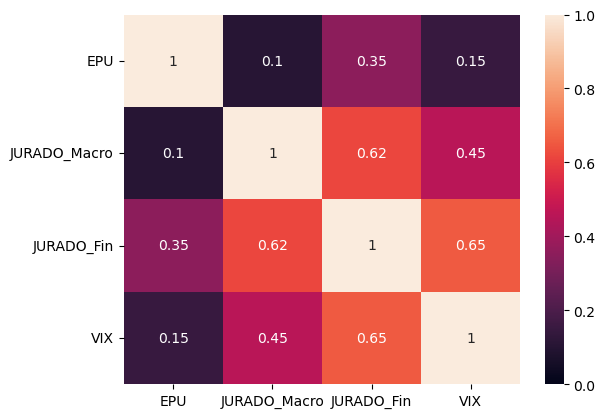

In [926]:
analysis_uk.plot_descriptive_corr()

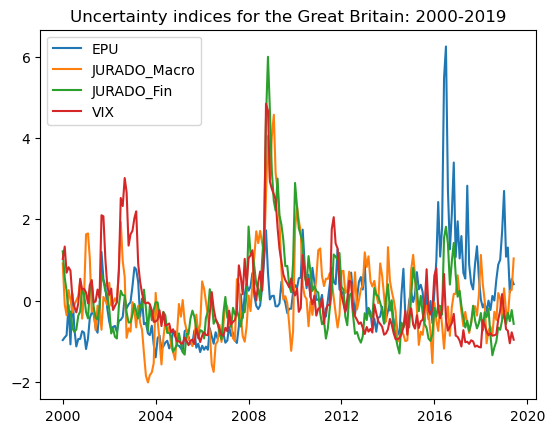

In [928]:
analysis_uk.plot_uncertainty()

In [836]:
#NOW OLS AND LASSO SEEM TO HAVE ISSUES!!

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.8694633178216922


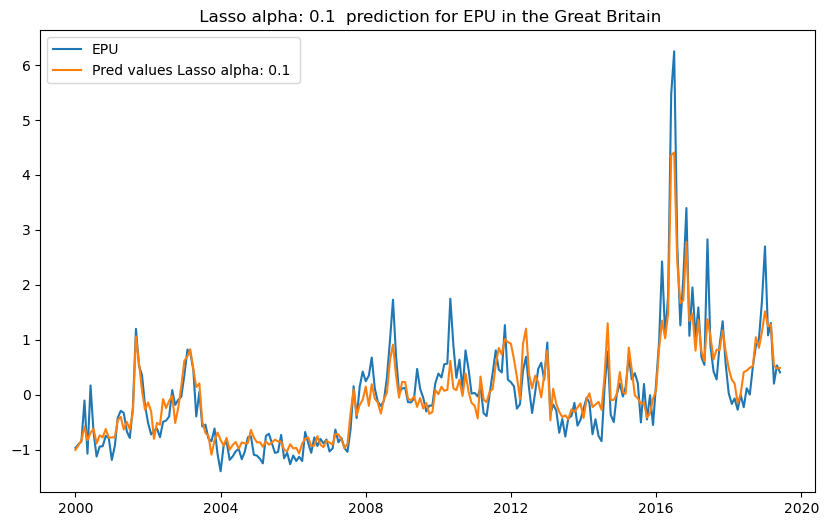

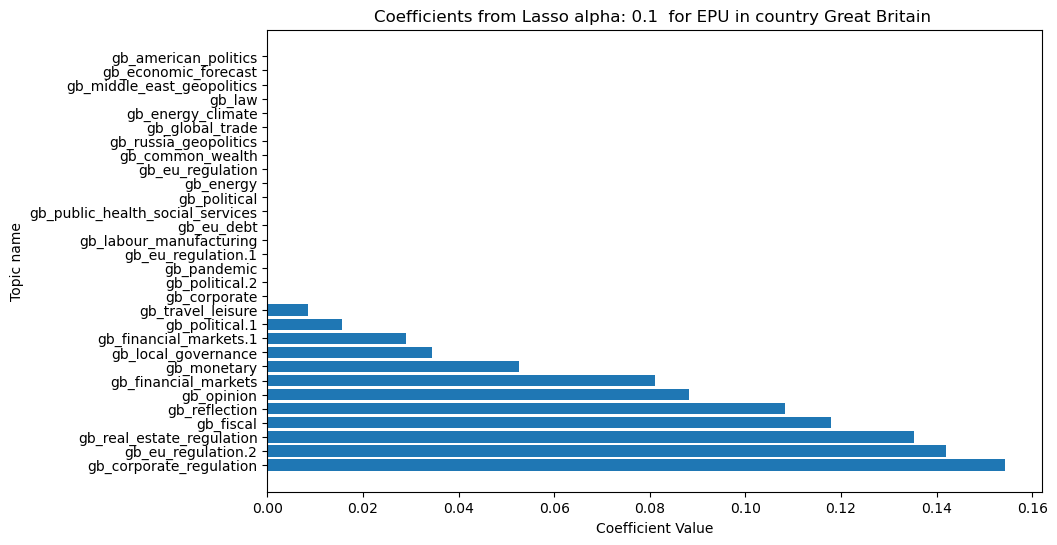

Feature  Coefficient
9            gb_corporate_regulation     0.154377
23                gb_eu_regulation.2     0.141921
13         gb_real_estate_regulation     0.135264
2                          gb_fiscal     0.117862
4                      gb_reflection     0.108365
16                        gb_opinion     0.088150
10              gb_financial_markets     0.081023
27                       gb_monetary     0.052751
1                gb_local_governance     0.034546
15            gb_financial_markets.1     0.029021
20                    gb_political.1     0.015607
24                 gb_travel_leisure     0.008618
19                      gb_corporate     0.000000
22                    gb_political.2     0.000000
25                       gb_pandemic     0.000000
21                gb_eu_regulation.1     0.000000
26           gb_labour_manufacturing     0.000000
28                        gb_eu_debt    -0.000000
0   gb_public_health_social_services     0.000000
18                      gb_political     0.000000
17                         gb_energy     0.000000
14                  gb_eu_regulation     0.000000
12                  gb_common_wealth     0.000000
11             gb_russia_geopolitics    -0.000000
8                    gb_global_trade     0.000000
7                  gb_energy_climate     0.000000
6                             gb_law     0.000000
5         gb_middle_east_geopolitics     0.000000
3               gb_economic_forecast     0.000000
29              gb_american_politics     0.000000

In [930]:
analysis_uk.lasso(chosen_yvar=uk_epu,alpha=0.1)

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143960569422009


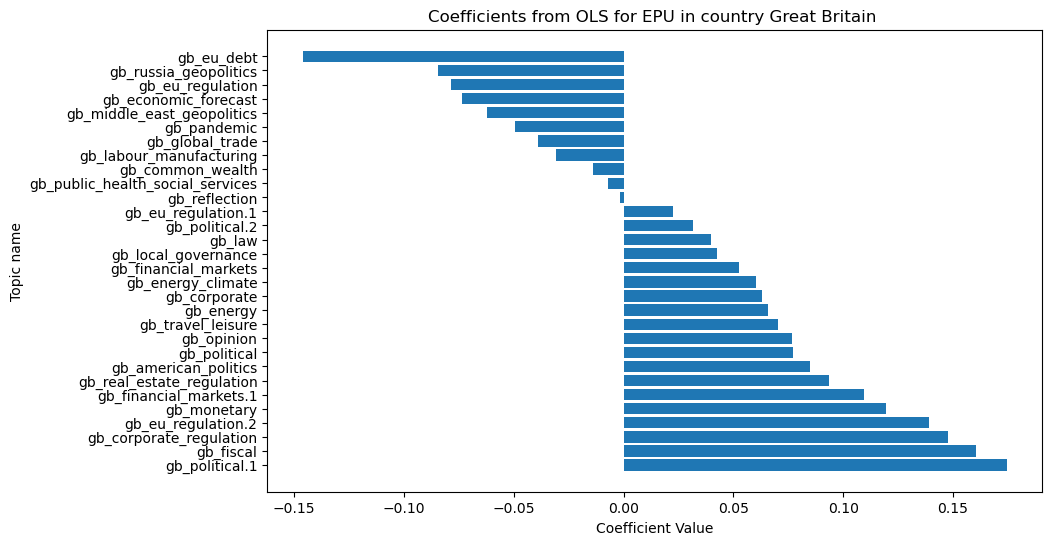

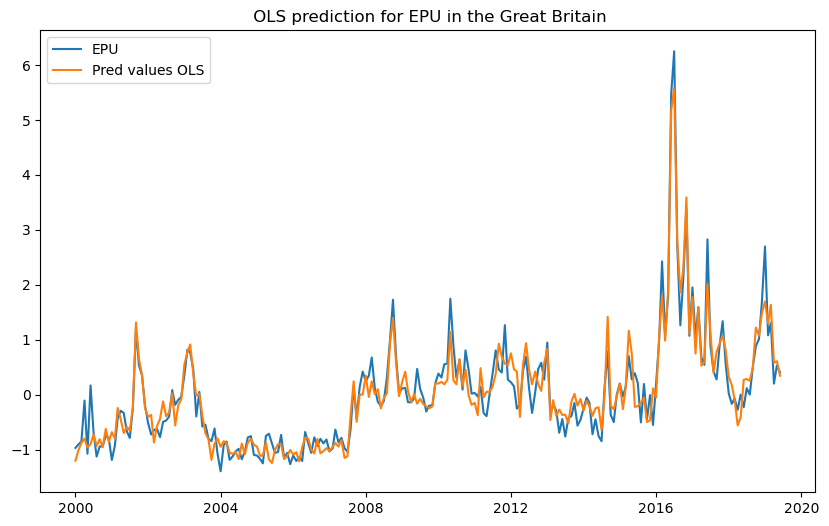

(     gb_public_health_social_services  gb_local_governance  gb_fiscal  \
 0                           -0.469191            -1.041801  -1.057781   
 1                           -0.882749            -0.790919  -1.014844   
 2                           -0.209444            -0.967182  -0.589237   
 3                           -0.899541            -0.396718  -1.195959   
 4                           -0.887681            -0.586756  -1.064066   
 ..                                ...                  ...        ...   
 229                          1.509943             1.556591   0.710985   
 230                          1.715759             0.165218   1.361724   
 231                          1.001057             0.036124  -0.197140   
 232                          1.193429             0.500192   0.070409   
 233                          0.663165             0.855799  -0.051406   
 
      gb_economic_forecast  gb_reflection  gb_middle_east_geopolitics  \
 0               -1.073394      -1.34

In [932]:
analysis_uk.ols(chosen_yvar=uk_epu,plot=True)

In [892]:
help(analysis_uk.ols)

Help on method ols in module __main__:

ols(chosen_yvar, data_prep=[], plot=True) method of __main__.Analysis instance
    Runs OLS analysis using LinearRegression from Sklearn. Then plots both the coefficients and the model fit visually.

    parameters

    chosen_yvar: "string" should be one of the uncertainty measures from the dataset, you can check which are available
    in the attribute .yvars

    data_prep: "list []", default [] Things to be modified in data prep, if list is empty the ols will run normally, if not, first
    element should be list of names of variables you want to drop, it will mean you want to run ols on subset of variables

    The second element of the list is the type of standarization that will be applied. Check out dataprep for available options.

    plot: True or False, if True it will plot the coefficients. 2 plots, coefficients and time series predicted value vs the true series.

    returns X for the VIF and the coefficients dataframe.



These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.002628889837597325
These are the cols to drop from the lasso with optimal alpha: ['gb_public_health_social_services', 'gb_common_wealth']
These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date', 'gb_public_health_social_services', 'gb_common_wealth']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143592482484006


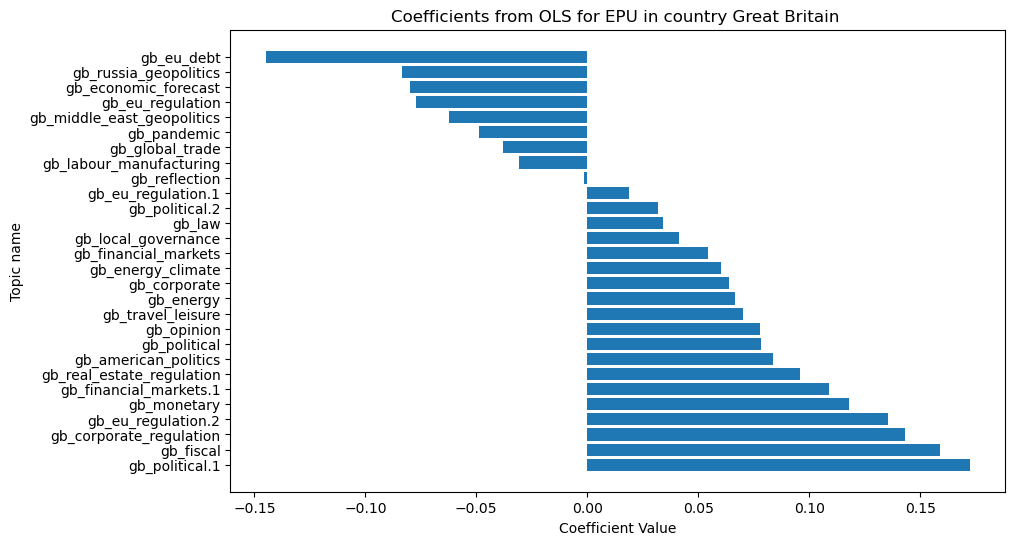

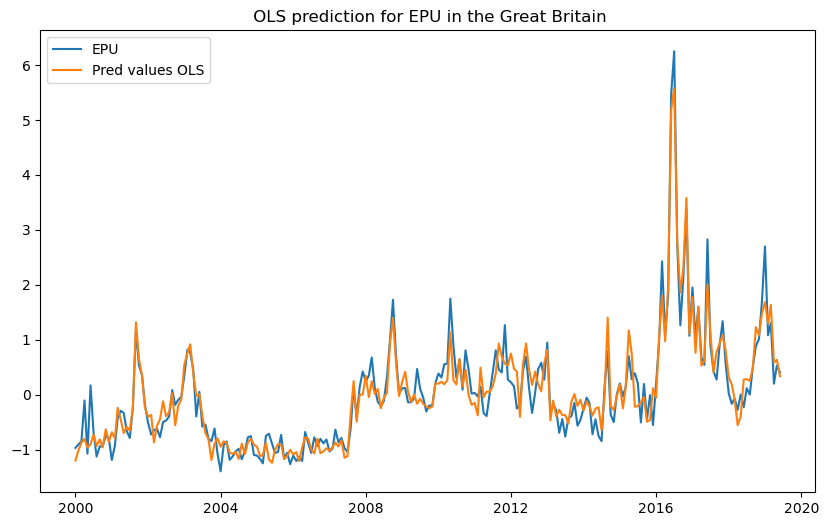

This is the variance inflation factor for the remaining variables.
gb_political                  23.767186
gb_opinion                    18.151820
gb_reflection                 15.772119
gb_corporate_regulation       13.122631
gb_economic_forecast          11.342832
gb_political.2                10.455717
gb_eu_regulation.1             9.612288
gb_financial_markets.1         7.868582
gb_law                         7.587291
gb_eu_regulation               6.933081
gb_financial_markets           6.924104
gb_eu_regulation.2             6.836977
gb_real_estate_regulation      6.807303
gb_political.1                 6.445960
gb_corporate                   6.249762
gb_local_governance            5.710528
gb_monetary                    4.973937
gb_labour_manufacturing        3.905224
gb_eu_debt                     3.853504
gb_american_politics           3.818446
gb_travel_leisure              3.377875
gb_global_trade                3.210581
gb_fiscal                      3.178797
gb_energy    

Feature  Coefficient
18              gb_political.1     0.172499
1                    gb_fiscal     0.158692
8      gb_corporate_regulation     0.143089
21          gb_eu_regulation.2     0.135615
25                 gb_monetary     0.117941
13      gb_financial_markets.1     0.108854
11   gb_real_estate_regulation     0.096044
27        gb_american_politics     0.083582
16                gb_political     0.078429
14                  gb_opinion     0.078002
22           gb_travel_leisure     0.070279
15                   gb_energy     0.066504
17                gb_corporate     0.063881
6            gb_energy_climate     0.060327
9         gb_financial_markets     0.054261
0          gb_local_governance     0.041499
5                       gb_law     0.033943
20              gb_political.2     0.031925
19          gb_eu_regulation.1     0.018570
3                gb_reflection    -0.001401
24     gb_labour_manufacturing    -0.030741
7              gb_global_trade    -0.038196
23                 gb_pandemic    -0.048664
4   gb_middle_east_geopolitics    -0.062131
12            gb_eu_regulation    -0.077197
2         gb_economic_forecast    -0.080009
10       gb_russia_geopolitics    -0.083599
26                  gb_eu_debt    -0.144909

In [934]:
analysis_uk.lasso_ols(chosen_yvar=uk_epu)

### Export 4 main plots to Overleaf.
    Unused in the end I think.

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.002628889837597325
These are the cols to drop from the lasso with optimal alpha: ['gb_public_health_social_services', 'gb_common_wealth']
These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date', 'gb_public_health_social_services', 'gb_common_wealth']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143592482484006
This is the variance inflation factor for the remaining variables.
gb_political                  23.767186
gb_opinion                    18.151820
gb_reflection                 15.772119
gb_corporate_regulation       13.122631
gb_economic_forecast          11.342832
gb_political.2                10.455717
gb_eu_regulation.1             9.612288
gb_financial_markets.1         7.868582
gb_law                 

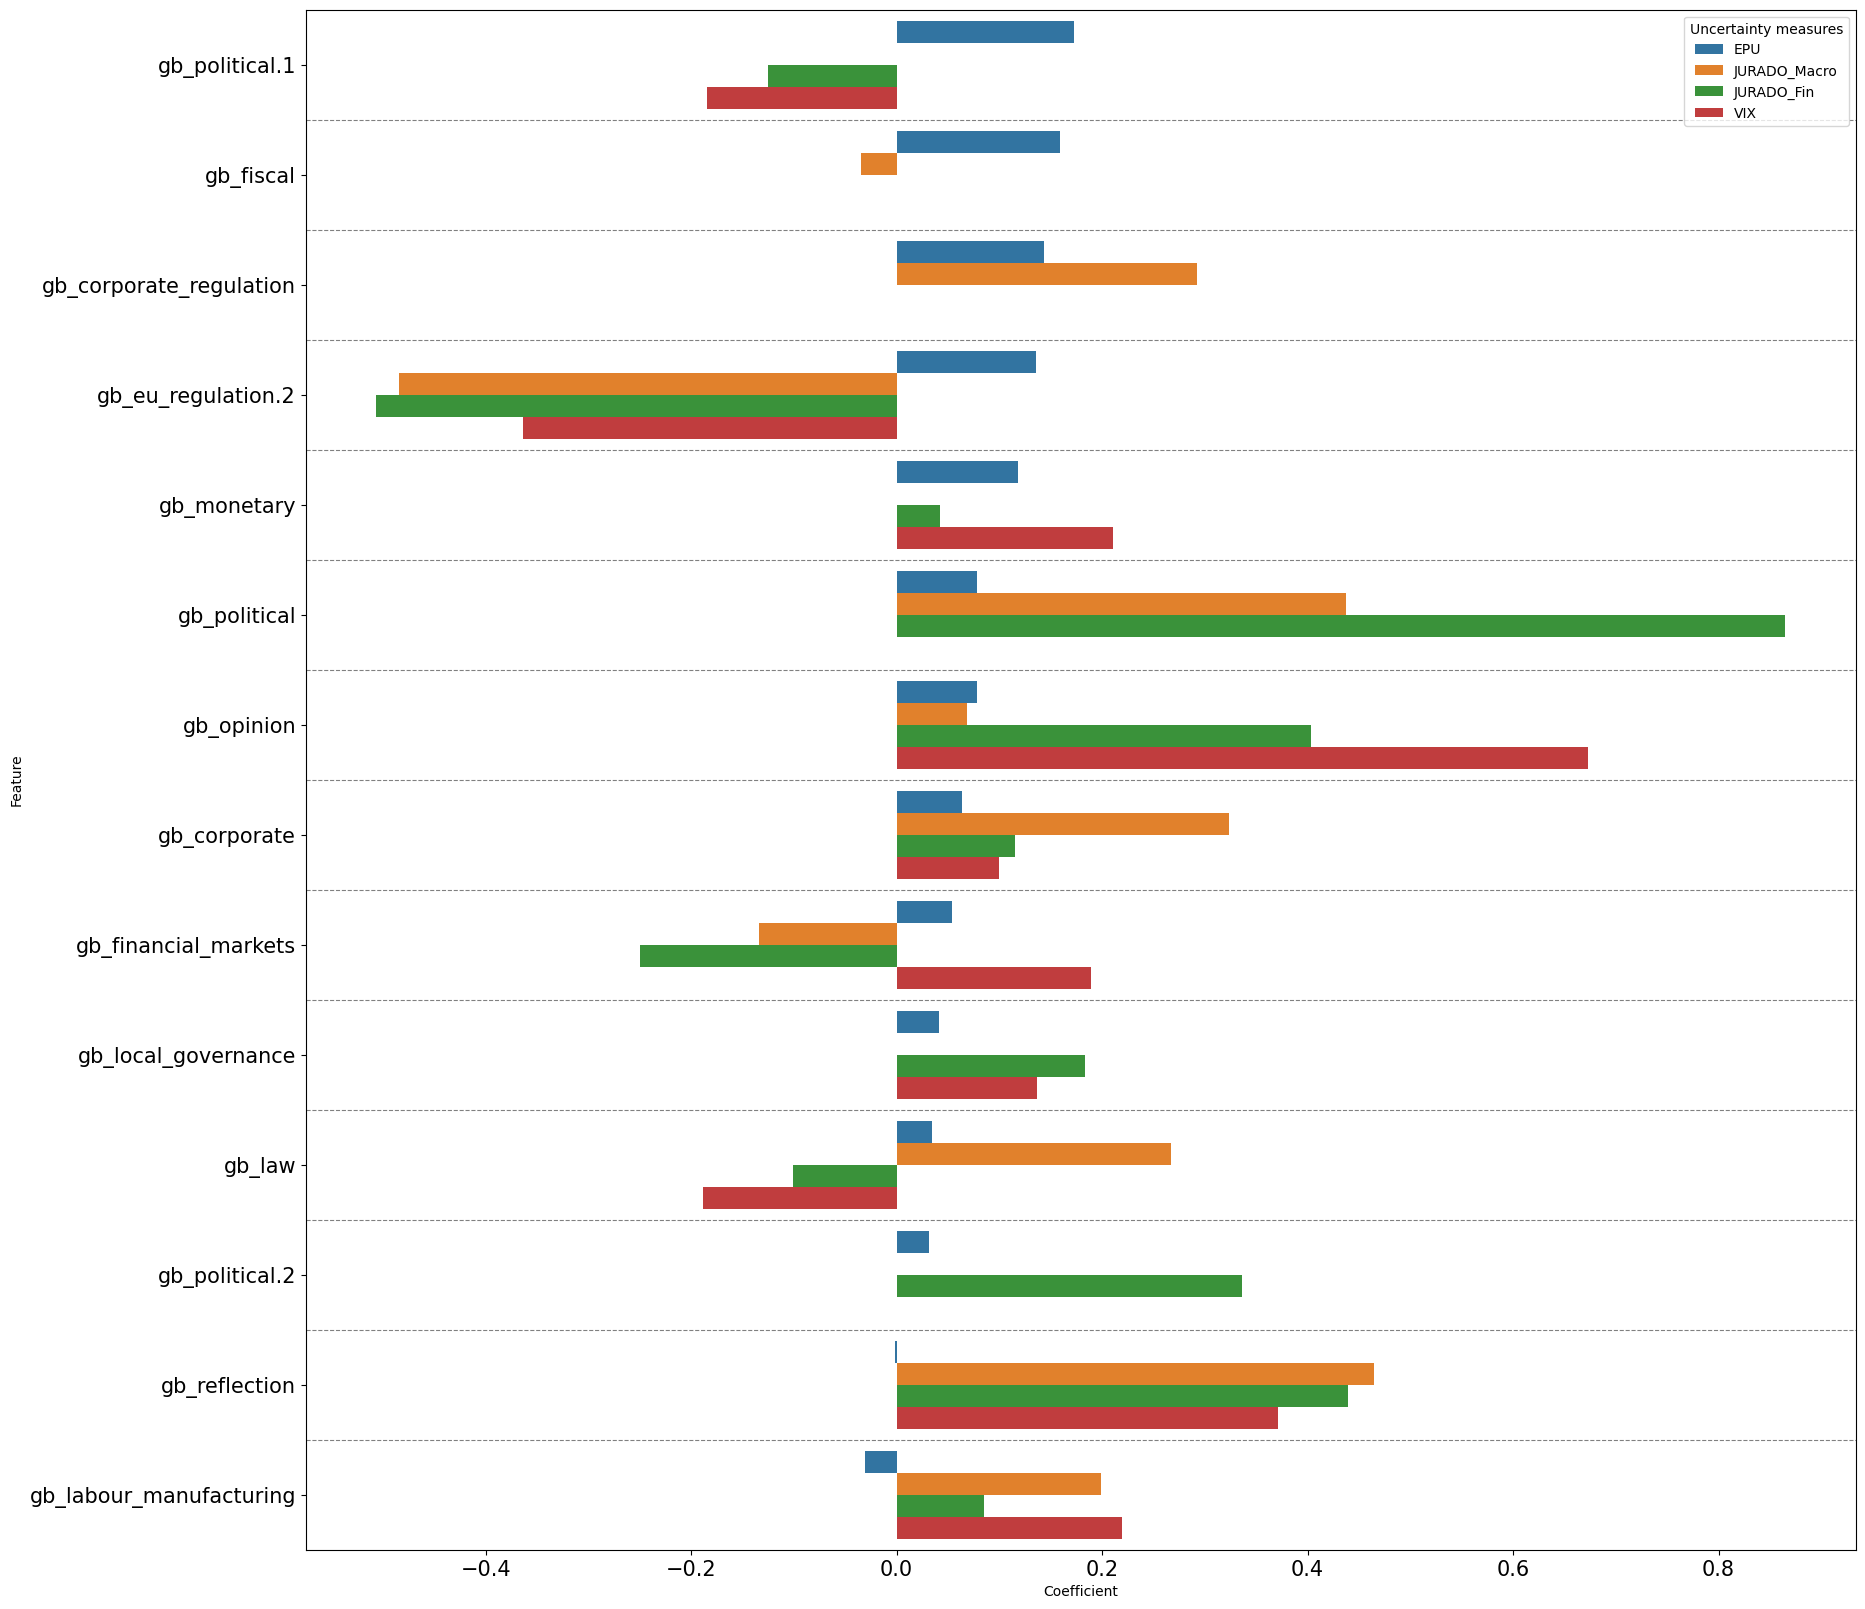

In [938]:
plt1 = analysis_uk.plot_coeff_all_y(mode='horizontal',subplot='positive')

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.002628889837597325
These are the cols to drop from the lasso with optimal alpha: ['gb_public_health_social_services', 'gb_common_wealth']
These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date', 'gb_public_health_social_services', 'gb_common_wealth']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143592482484006
This is the variance inflation factor for the remaining variables.
gb_political                  23.767186
gb_opinion                    18.151820
gb_reflection                 15.772119
gb_corporate_regulation       13.122631
gb_economic_forecast          11.342832
gb_political.2                10.455717
gb_eu_regulation.1             9.612288
gb_financial_markets.1         7.868582
gb_law                 

FileNotFoundError: [Errno 2] No such file or directory: 'results/plots/sept11//bottom5anyY_overleaf.pdf'

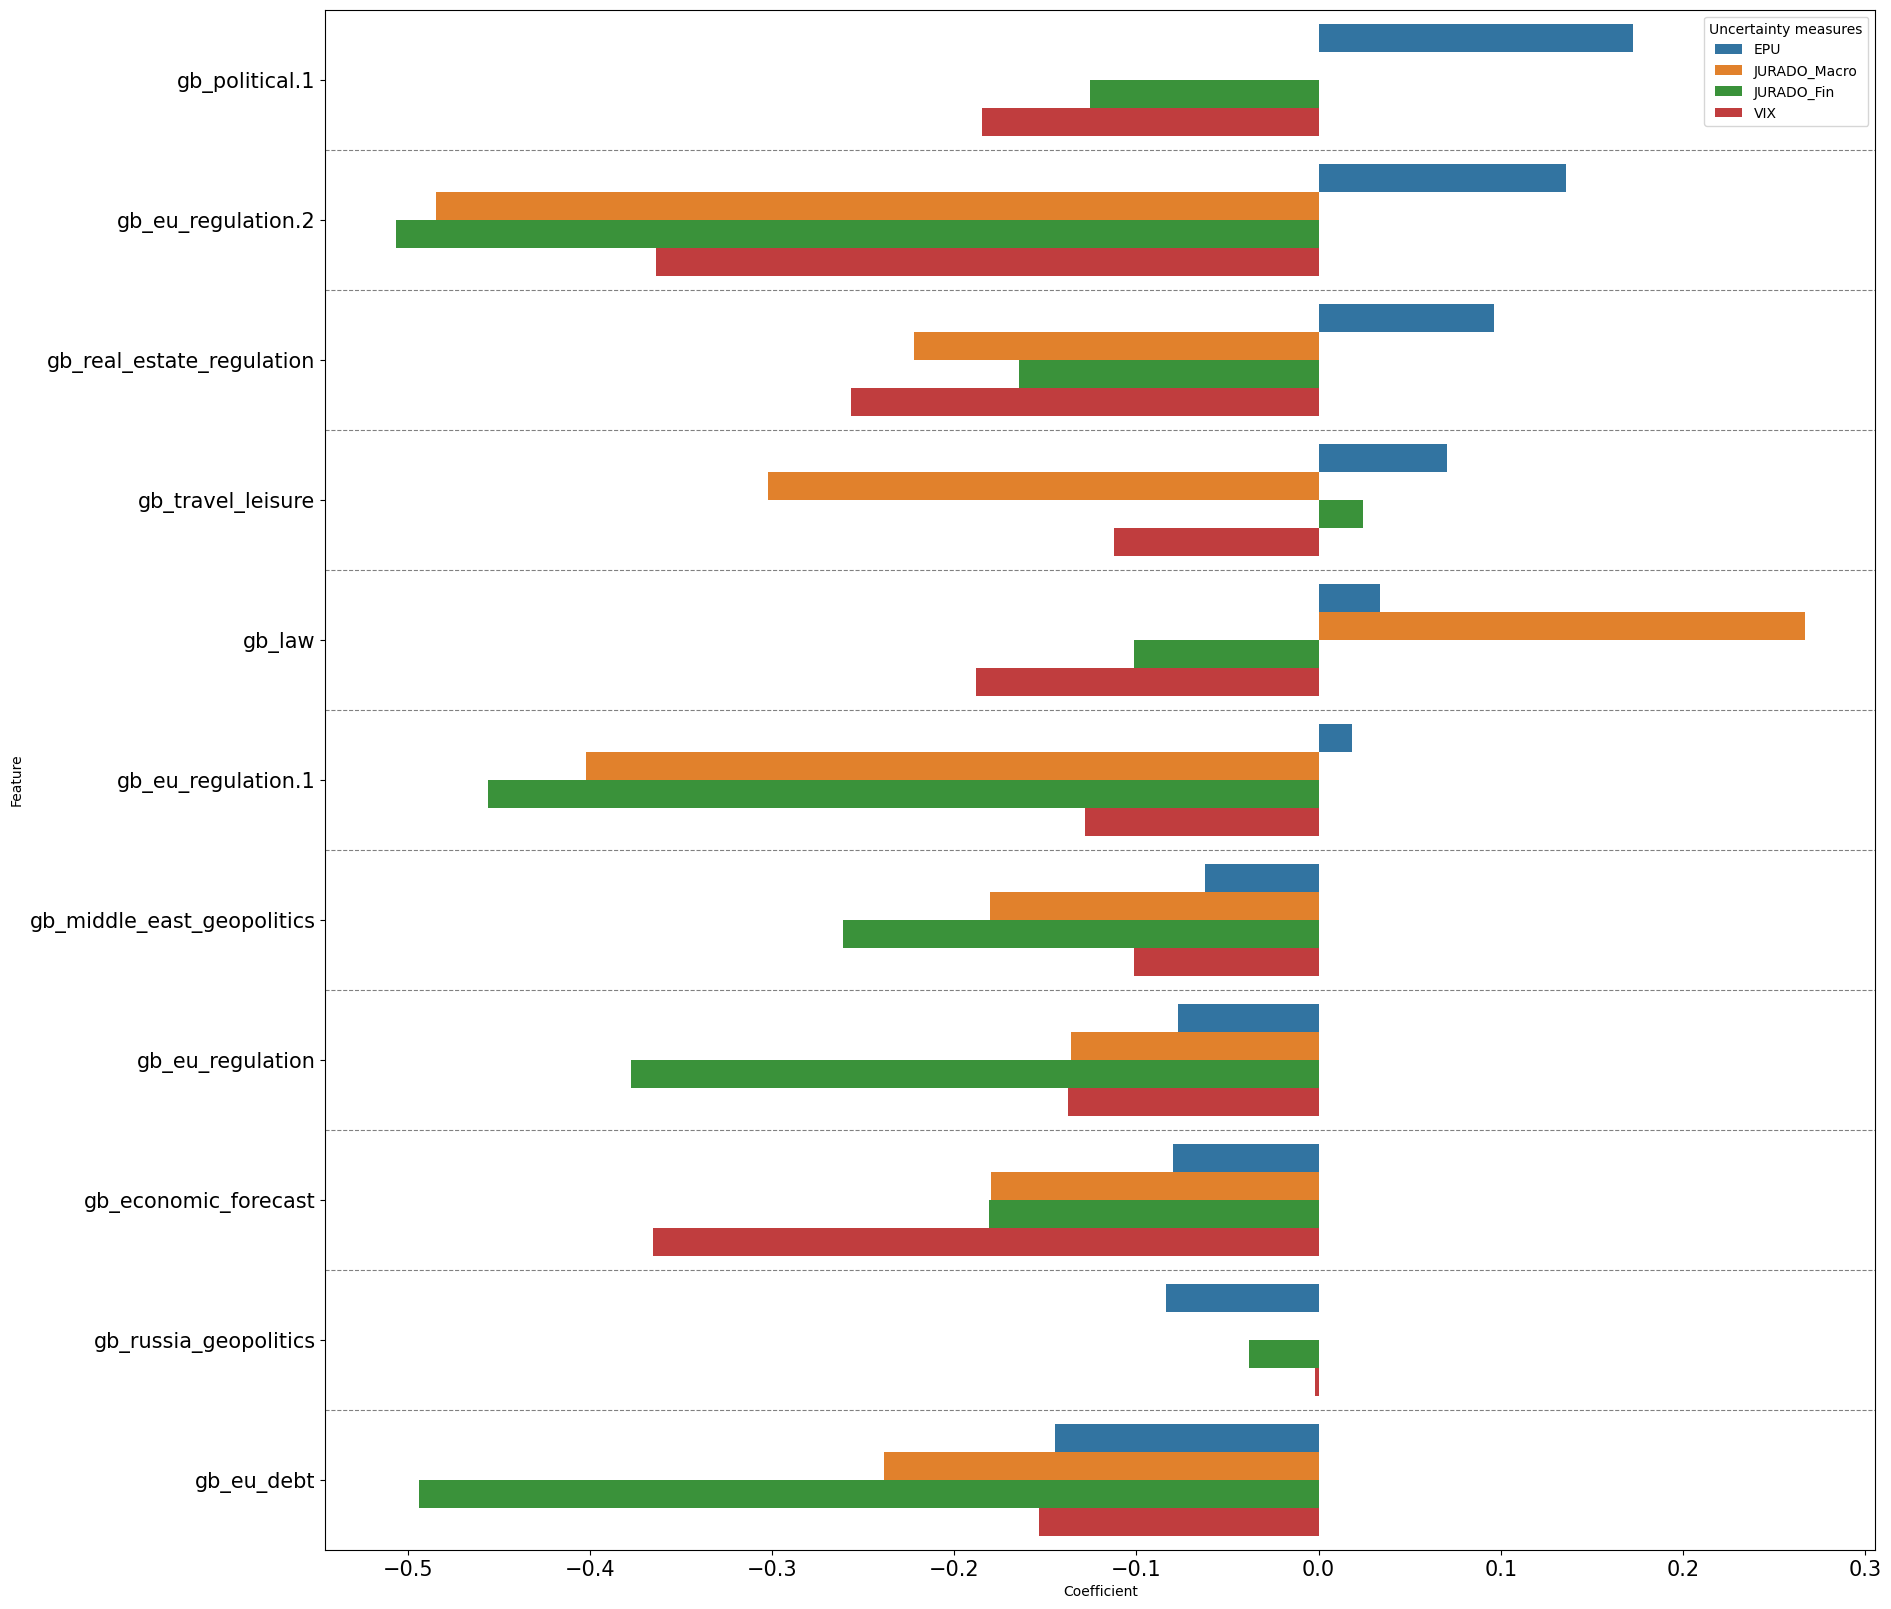

In [771]:
plt2 = analysis_uk.plot_coeff_all_y(mode='horizontal',subplot='negative')

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.002628889837597325
These are the cols to drop from the lasso with optimal alpha: ['gb_public_health_social_services', 'gb_common_wealth']
These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date', 'gb_public_health_social_services', 'gb_common_wealth']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143592482484006
This is the variance inflation factor for the remaining variables.
gb_political                  23.767186
gb_opinion                    18.151820
gb_reflection                 15.772119
gb_corporate_regulation       13.122631
gb_economic_forecast          11.342832
gb_political.2                10.455717
gb_eu_regulation.1             9.612288
gb_financial_markets.1         7.868582
gb_law                 

FileNotFoundError: [Errno 2] No such file or directory: 'results/plots/sept11//top5onlyY_overleaf.pdf'

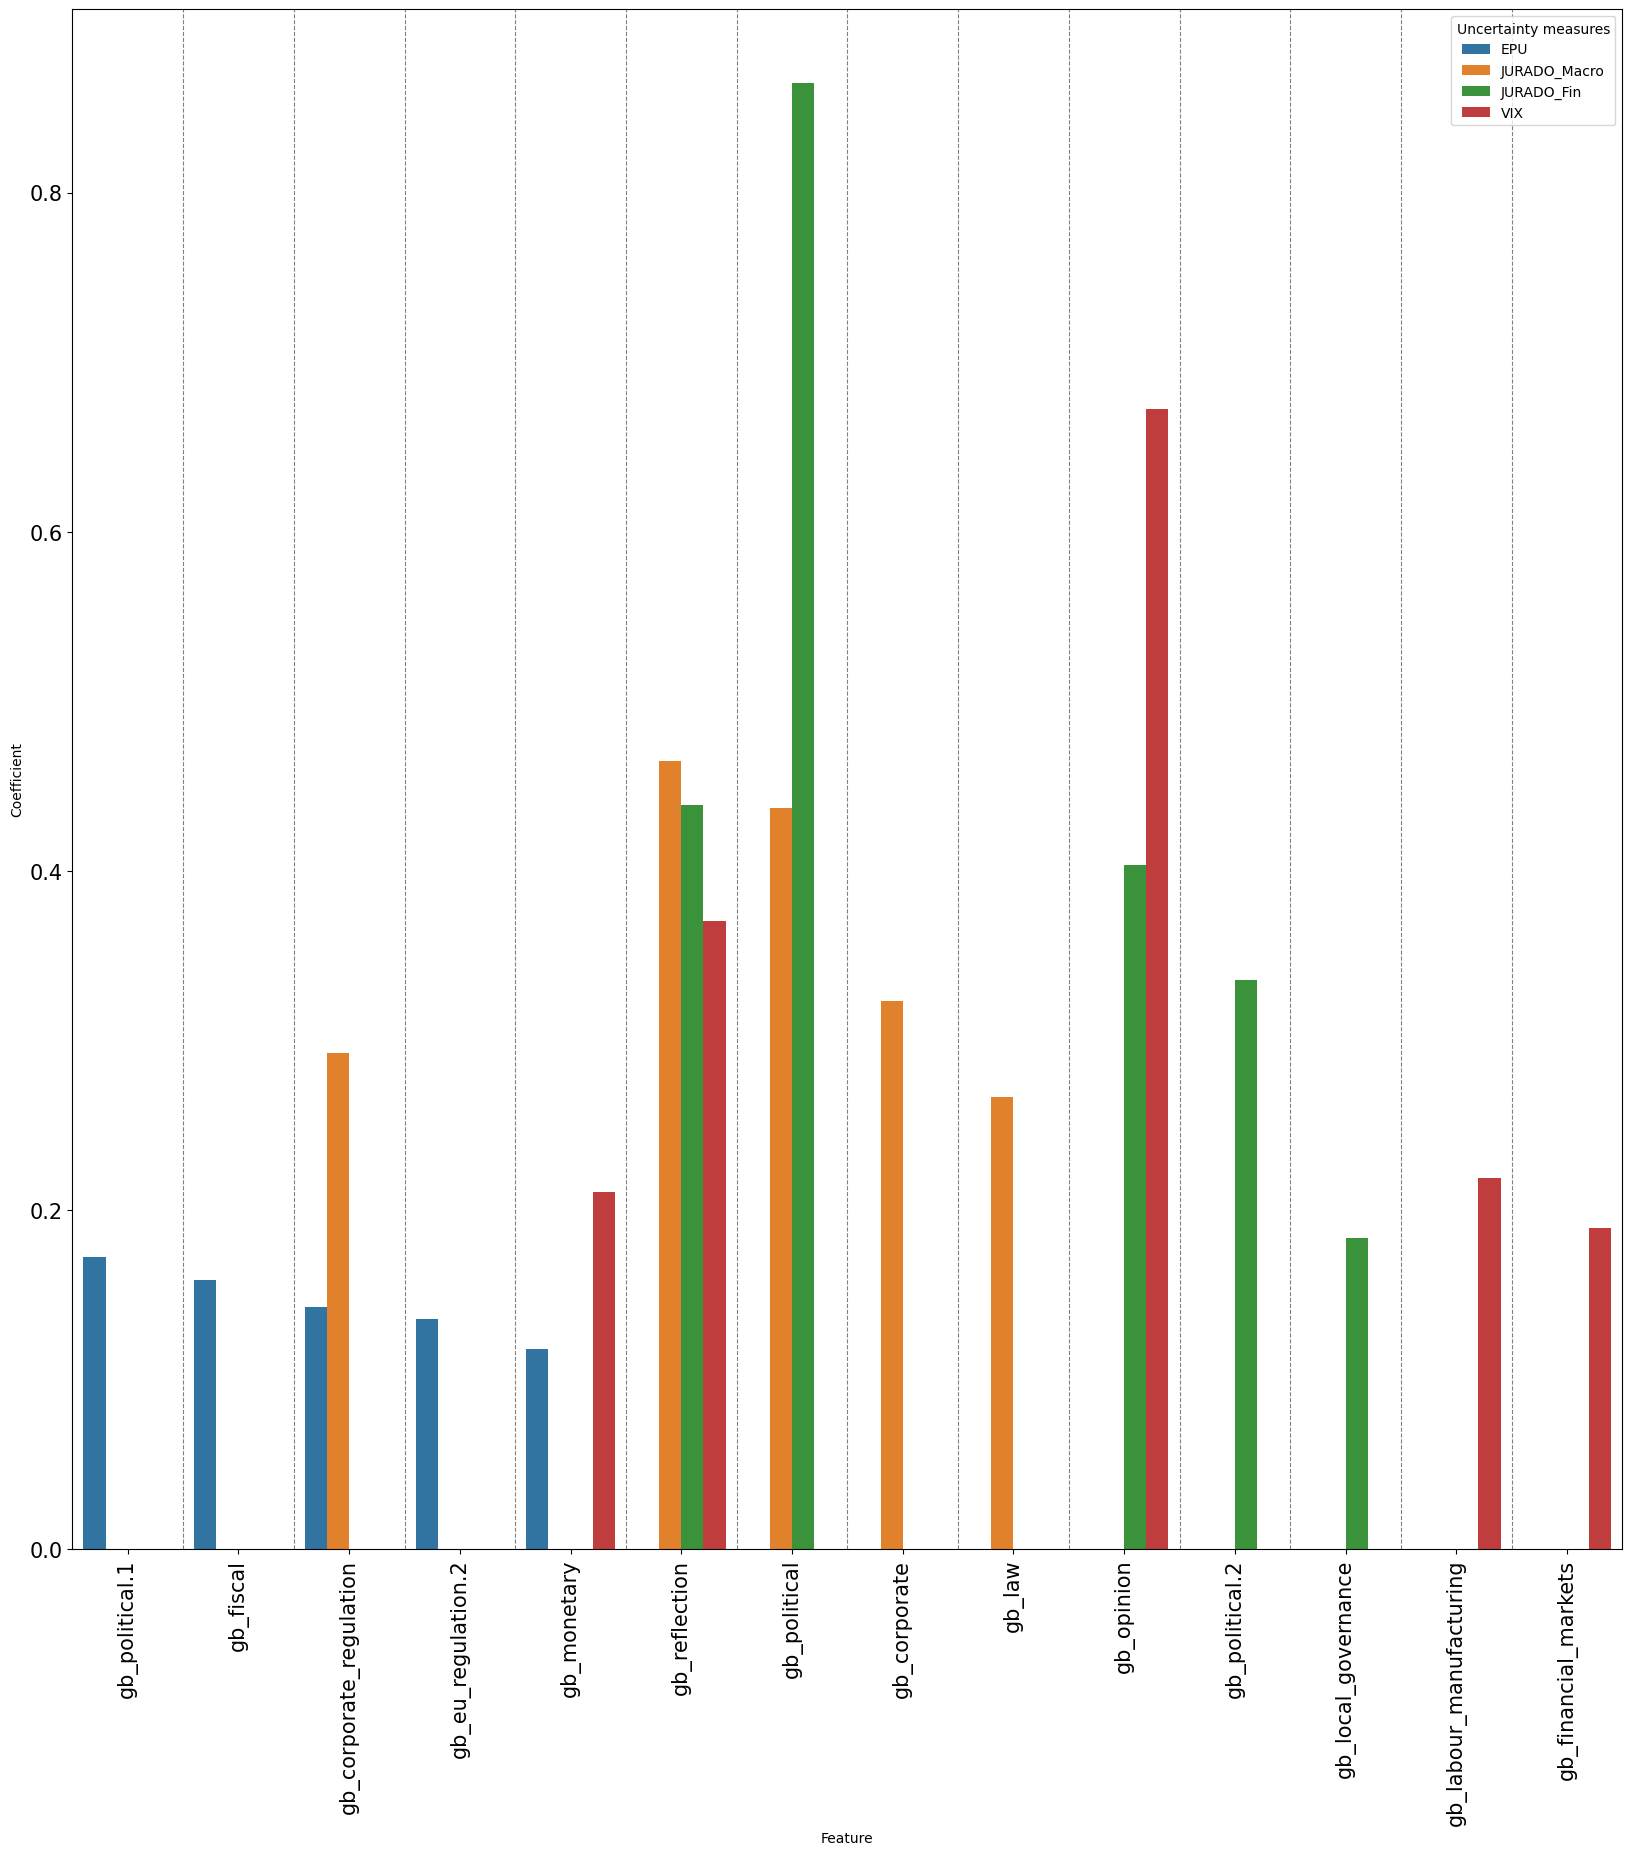

In [773]:
plt3 = analysis_uk.plot_coeff_all_y(mode='vertical',subplot='only5+')

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.002628889837597325
These are the cols to drop from the lasso with optimal alpha: ['gb_public_health_social_services', 'gb_common_wealth']
These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date', 'gb_public_health_social_services', 'gb_common_wealth']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143592482484006
This is the variance inflation factor for the remaining variables.
gb_political                  23.767186
gb_opinion                    18.151820
gb_reflection                 15.772119
gb_corporate_regulation       13.122631
gb_economic_forecast          11.342832
gb_political.2                10.455717
gb_eu_regulation.1             9.612288
gb_financial_markets.1         7.868582
gb_law                 

FileNotFoundError: [Errno 2] No such file or directory: 'results/plots/sept11//bottom5onlyY_overleaf.pdf'

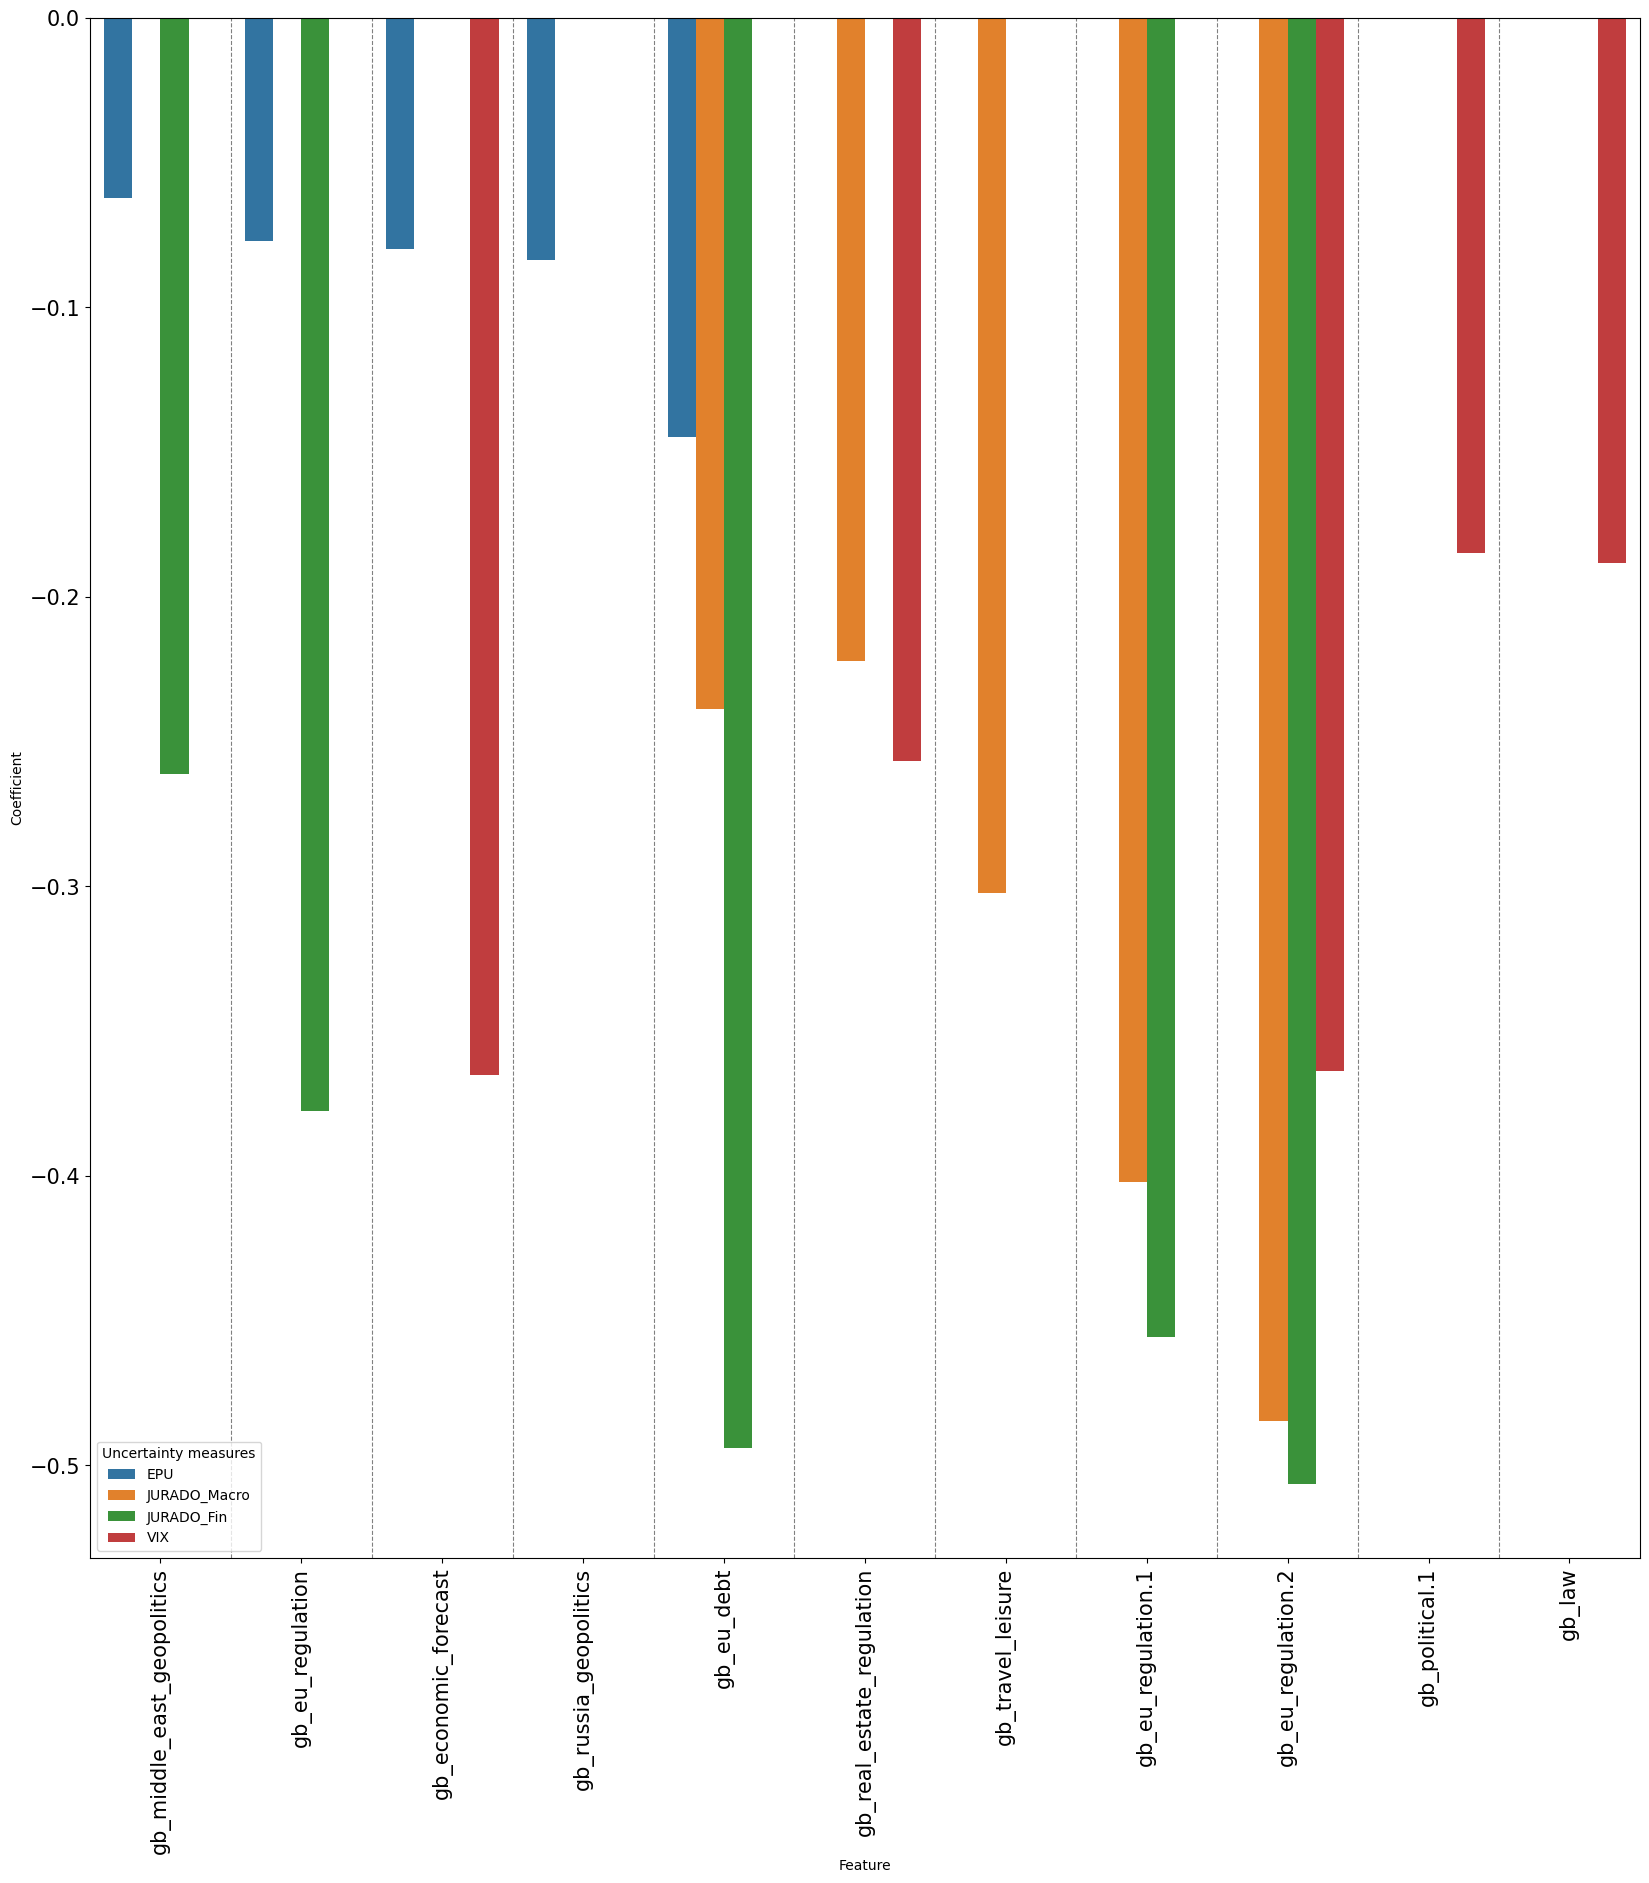

In [775]:
plt4 = analysis_uk.plot_coeff_all_y(mode='vertical',subplot='only5-')

### Lasso plots 12-09 tests:
    Unused in the end.
    Still pretty and informative :)

These are the variables that are dropped: ['JURADO_Macro', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y


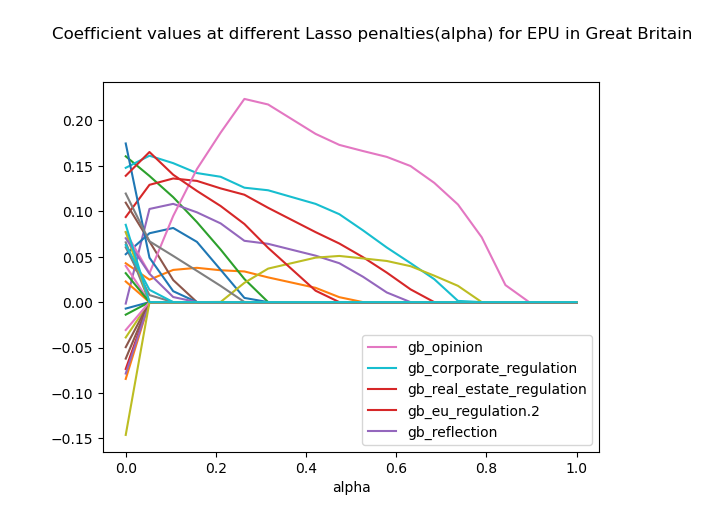

These are the variables that are dropped: ['EPU', 'JURADO_Fin', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y


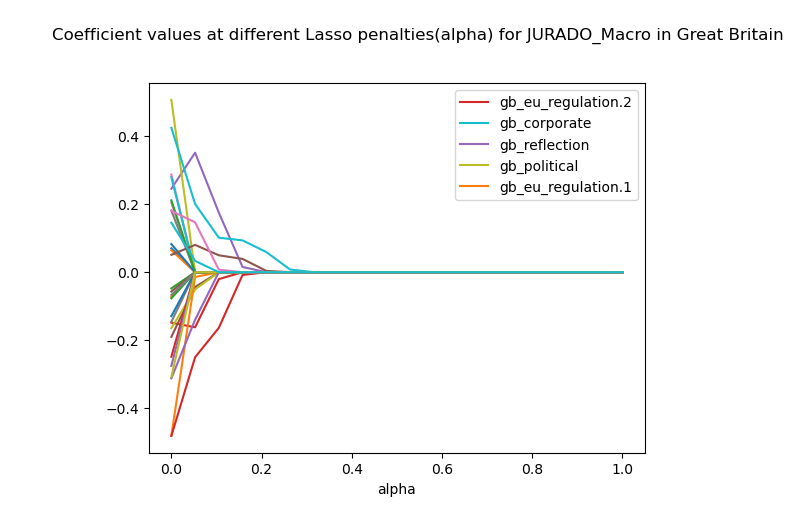

These are the variables that are dropped: ['EPU', 'JURADO_Macro', 'VIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y


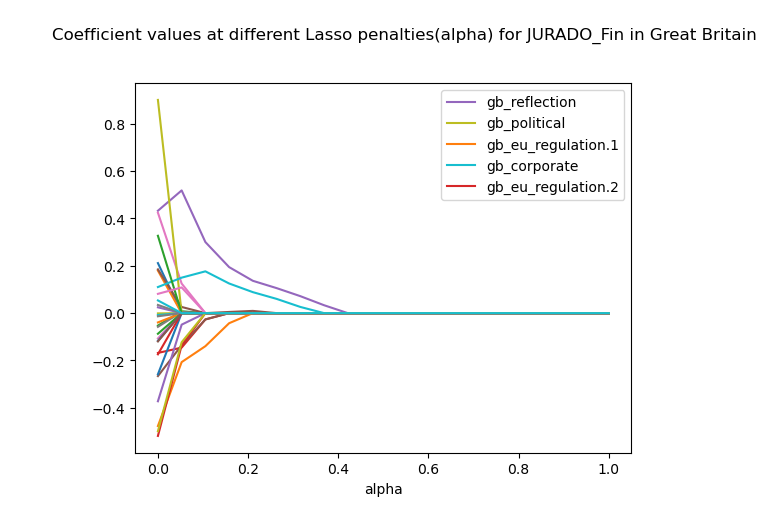

These are the variables that are dropped: ['EPU', 'JURADO_Macro', 'JURADO_Fin', 'date']. This is a temporary check.
Applied standard scaling to the X and y


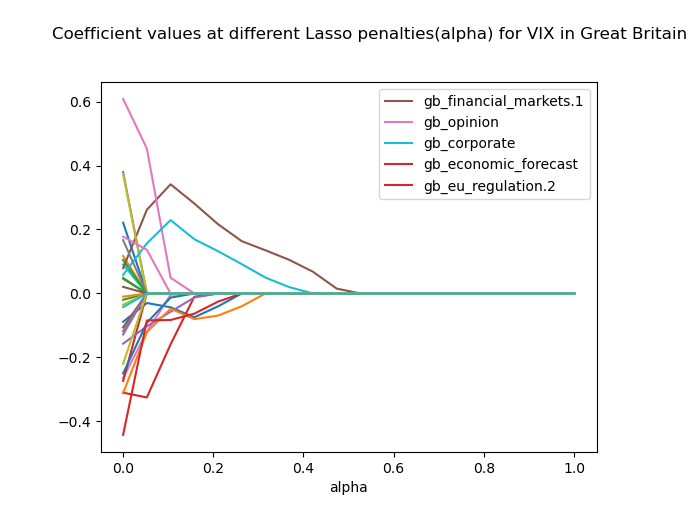

In [778]:
for yvar in analysis_uk.yvars:    
    analysis_uk.plot_lasso_r(
        chosen_yvar=yvar,
        norm_type='standard',
        max_penalty=1
        #path_save=plots+'sept11//'+f'uk_{yvar}_lasso_alphas_12sept.pdf',
        #save=True
    )

### Lasso Ridge plots 12-09

In [781]:
help(analysis_uk.lasso_ridge)

Help on method lasso_ridge in module __main__:

lasso_ridge(chosen_yvar, path='', normtype='standard') method of __main__.Analysis instance
    Comparison of coefficients between lasso and ridge, plots the results. While LassoCV searches amongst all alphas by default,
    RidgeCV searches amongst only 3 alphas 0.1, 1 , 10 by default, behaviour can be modified.

    Fix random state for replicability.

    params:

    chosen_yvar: str, pick one of the yvars, call the attribute .yvars on the object to see which are available.

    path: str, default '', where you want to save the plot. If '' the plot is not saved.

    norm_type: str, default = 'standard', other = 'robust', any other string.
        'standard': substracts the mean of the whole series and divides by the standard deviation.

        'robust': implements a similar methodology that is more robust to outliers, substracting the median and dividing by interquantile
        range, see https://scikit-learn.org/stable/modules/gen

### Symmetry plot function

In [174]:
#In this plot there should probably be the penalization coefficients of both models.
sns.set_style("whitegrid")
def symmetry_test(data,yvar,country,path=""):
    test_pivot = data.pivot(index='Feature',columns='Estimator',values='Coefficient')
    ax = sns.scatterplot(data=test_pivot,x="LASSO",y="RIDGE")   
    lims = [min(test_pivot['LASSO'].min(),test_pivot['RIDGE'].min()),max(test_pivot['LASSO'].max(),test_pivot['RIDGE'].max())]

    plt.plot(lims,lims,ls = '--',c='.3')
    plt.ylabel("Ridge coefficients",fontsize=19)
    plt.xlabel("Lasso coefficients",fontsize=19)
    plt.tick_params(axis='both', labelsize=15)
    
    if path:
        print(f'Figure saved here: {path}')
        plt.savefig(path)
    plt.show()
    

These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VFTSEIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.002628889837597325 and for RIDGE: 10.0


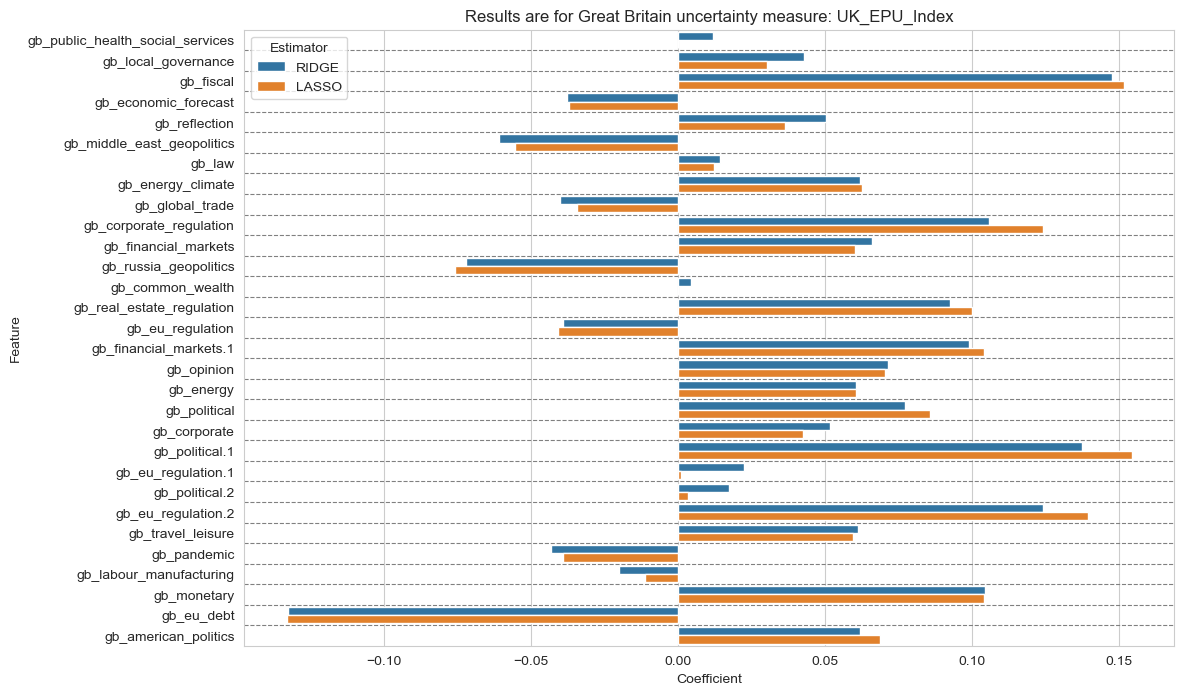

Figure saved here: results\plots\sept11//uk_symmetry_lasso_ridge_UK_EPU_Index_13sept.pdf


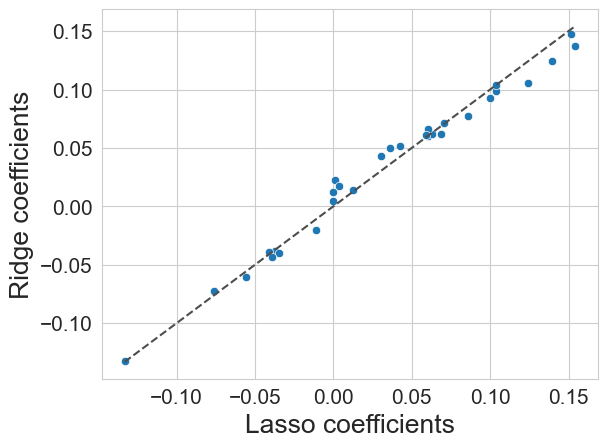

These are the variables that are dropped: ['UK_EPU_Index', 'Fin_Index', 'VFTSEIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.01663622458571981 and for RIDGE: 10.0


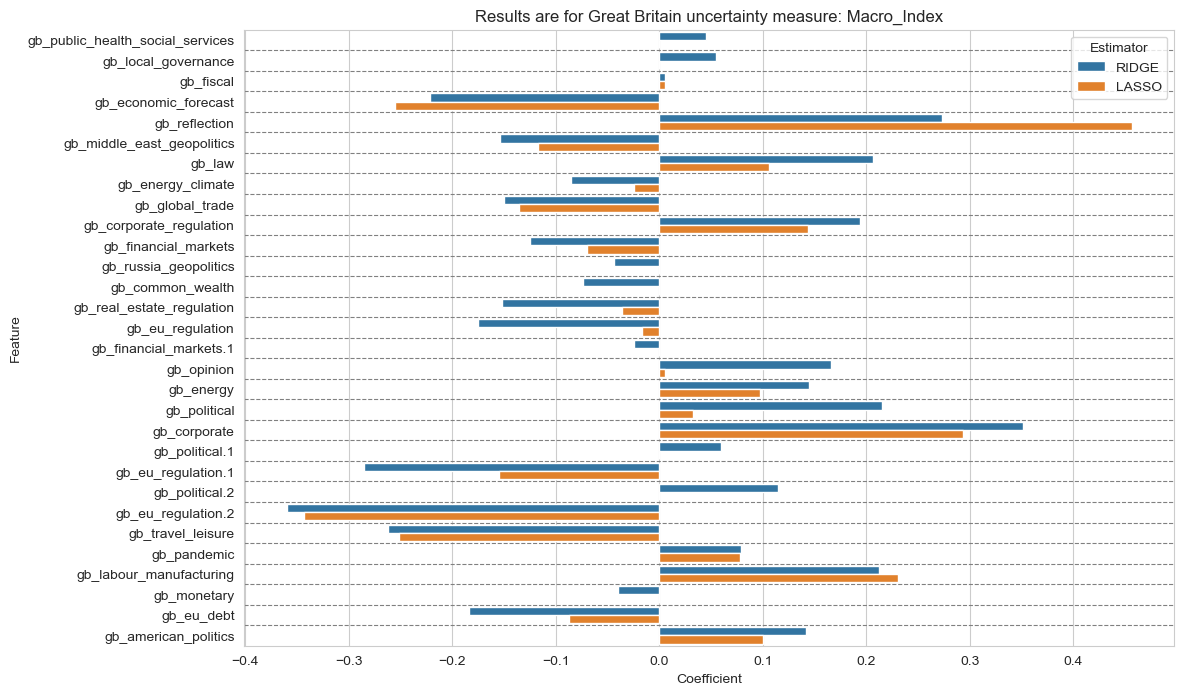

Figure saved here: results\plots\sept11//uk_symmetry_lasso_ridge_Macro_Index_13sept.pdf


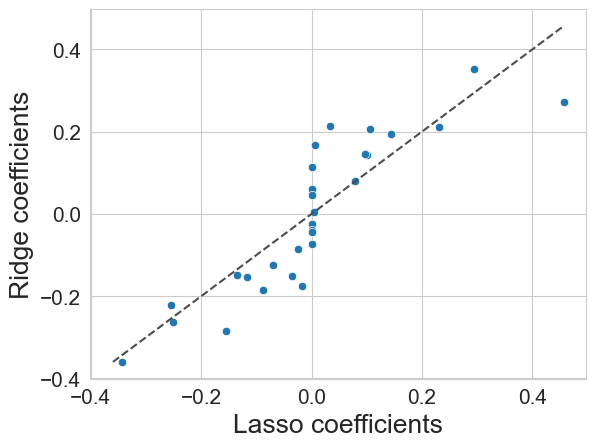

These are the variables that are dropped: ['UK_EPU_Index', 'Macro_Index', 'VFTSEIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.0056955415345144615 and for RIDGE: 10.0


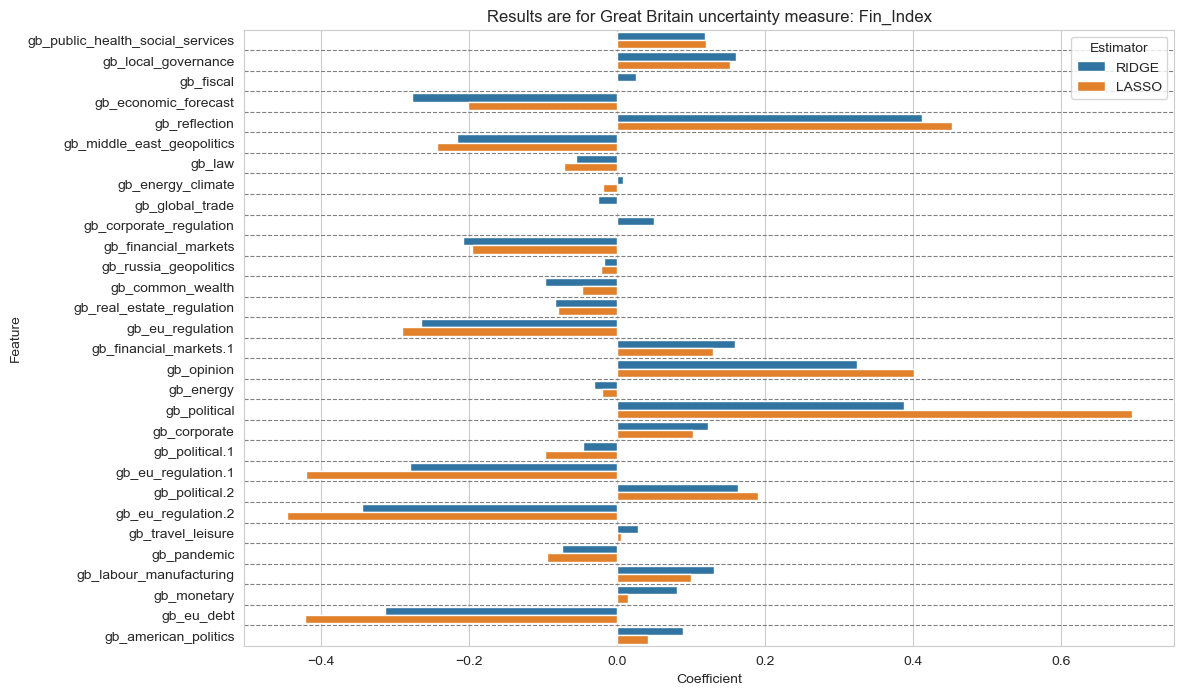

Figure saved here: results\plots\sept11//uk_symmetry_lasso_ridge_Fin_Index_13sept.pdf


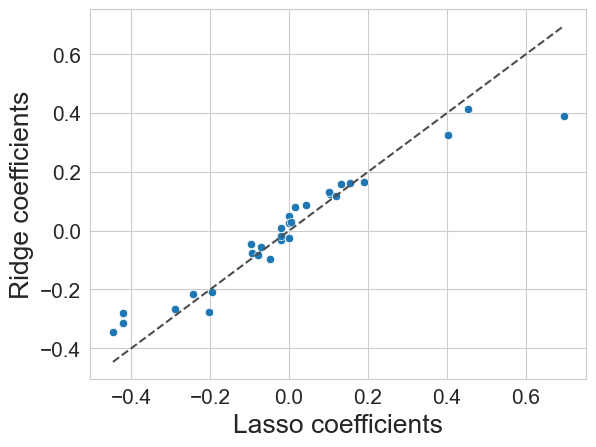

These are the variables that are dropped: ['UK_EPU_Index', 'Macro_Index', 'Fin_Index', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.014929713598308244 and for RIDGE: 10.0


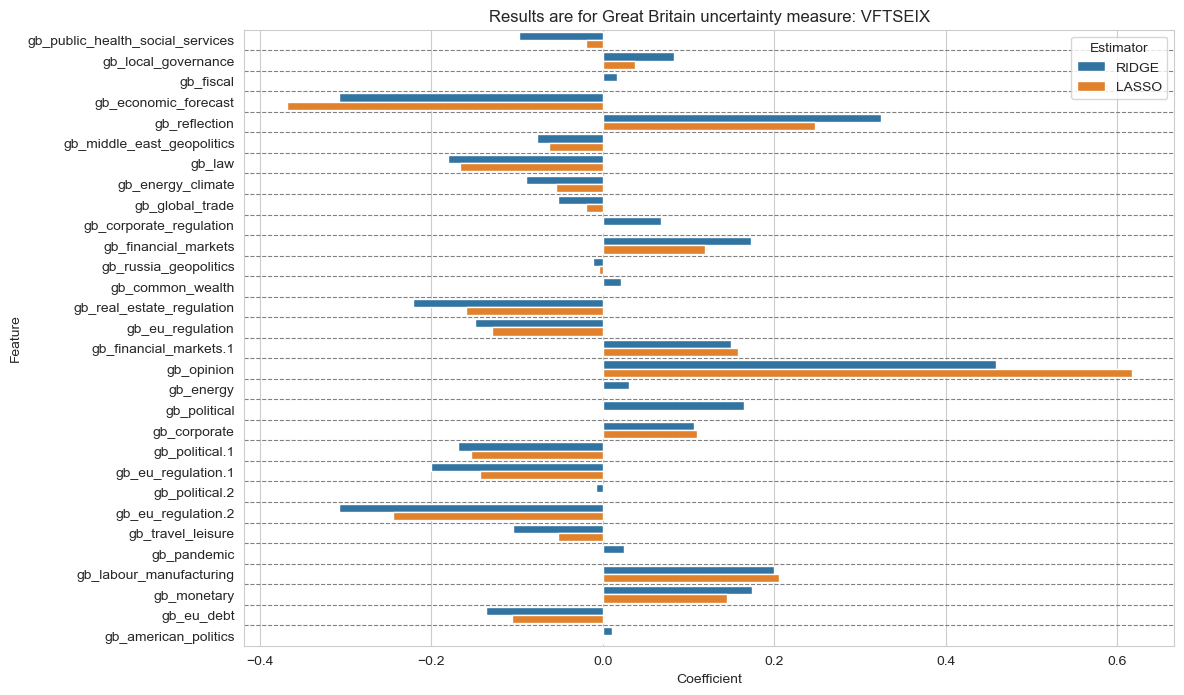

Figure saved here: results\plots\sept11//uk_symmetry_lasso_ridge_VFTSEIX_13sept.pdf


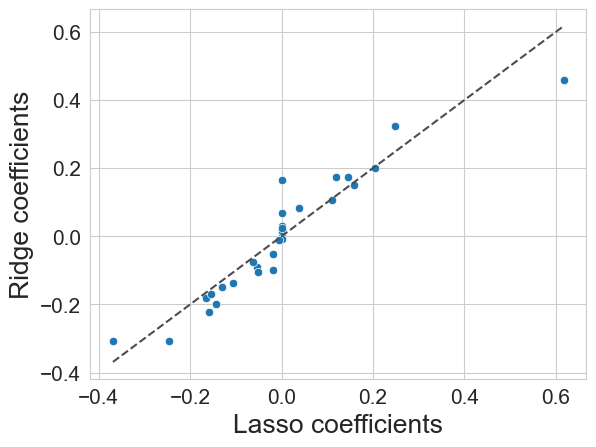

In [175]:
#,path=plots+'sept11//'+f'uk_{yvar}_lasso_ridge_12sept.pdf'
#path=plots+'sept11//'+f'uk_symmetry_lasso_ridge_{yvar}_13sept.pdf'
for yvar in analysis_uk.yvars:
    data = analysis_uk.lasso_ridge(chosen_yvar=yvar)
    symmetry_test(data,yvar,country='Great Britain')

#### Testing, plot uncertainty measures on the X axis.
    What Marina wanted in the end. Just need to pivot the table and little else,
    make sure that no subplot if you want the full data, it is the default.

These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VFTSEIX', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.002628889837597325
These are the cols to drop from the lasso with optimal alpha: ['gb_public_health_social_services', 'gb_common_wealth']
These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VFTSEIX', 'date', 'gb_public_health_social_services', 'gb_common_wealth']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.9143592482484026
This is the variance inflation factor for the remaining variables.
gb_political                  23.767186
gb_opinion                    18.151820
gb_reflection                 15.772119
gb_corporate_regulation       13.122631
gb_economic_forecast          11.342832
gb_political.2                10.455717
gb_eu_regulation.1             9.612288
gb_financial_markets.1         7.868582
gb_law             

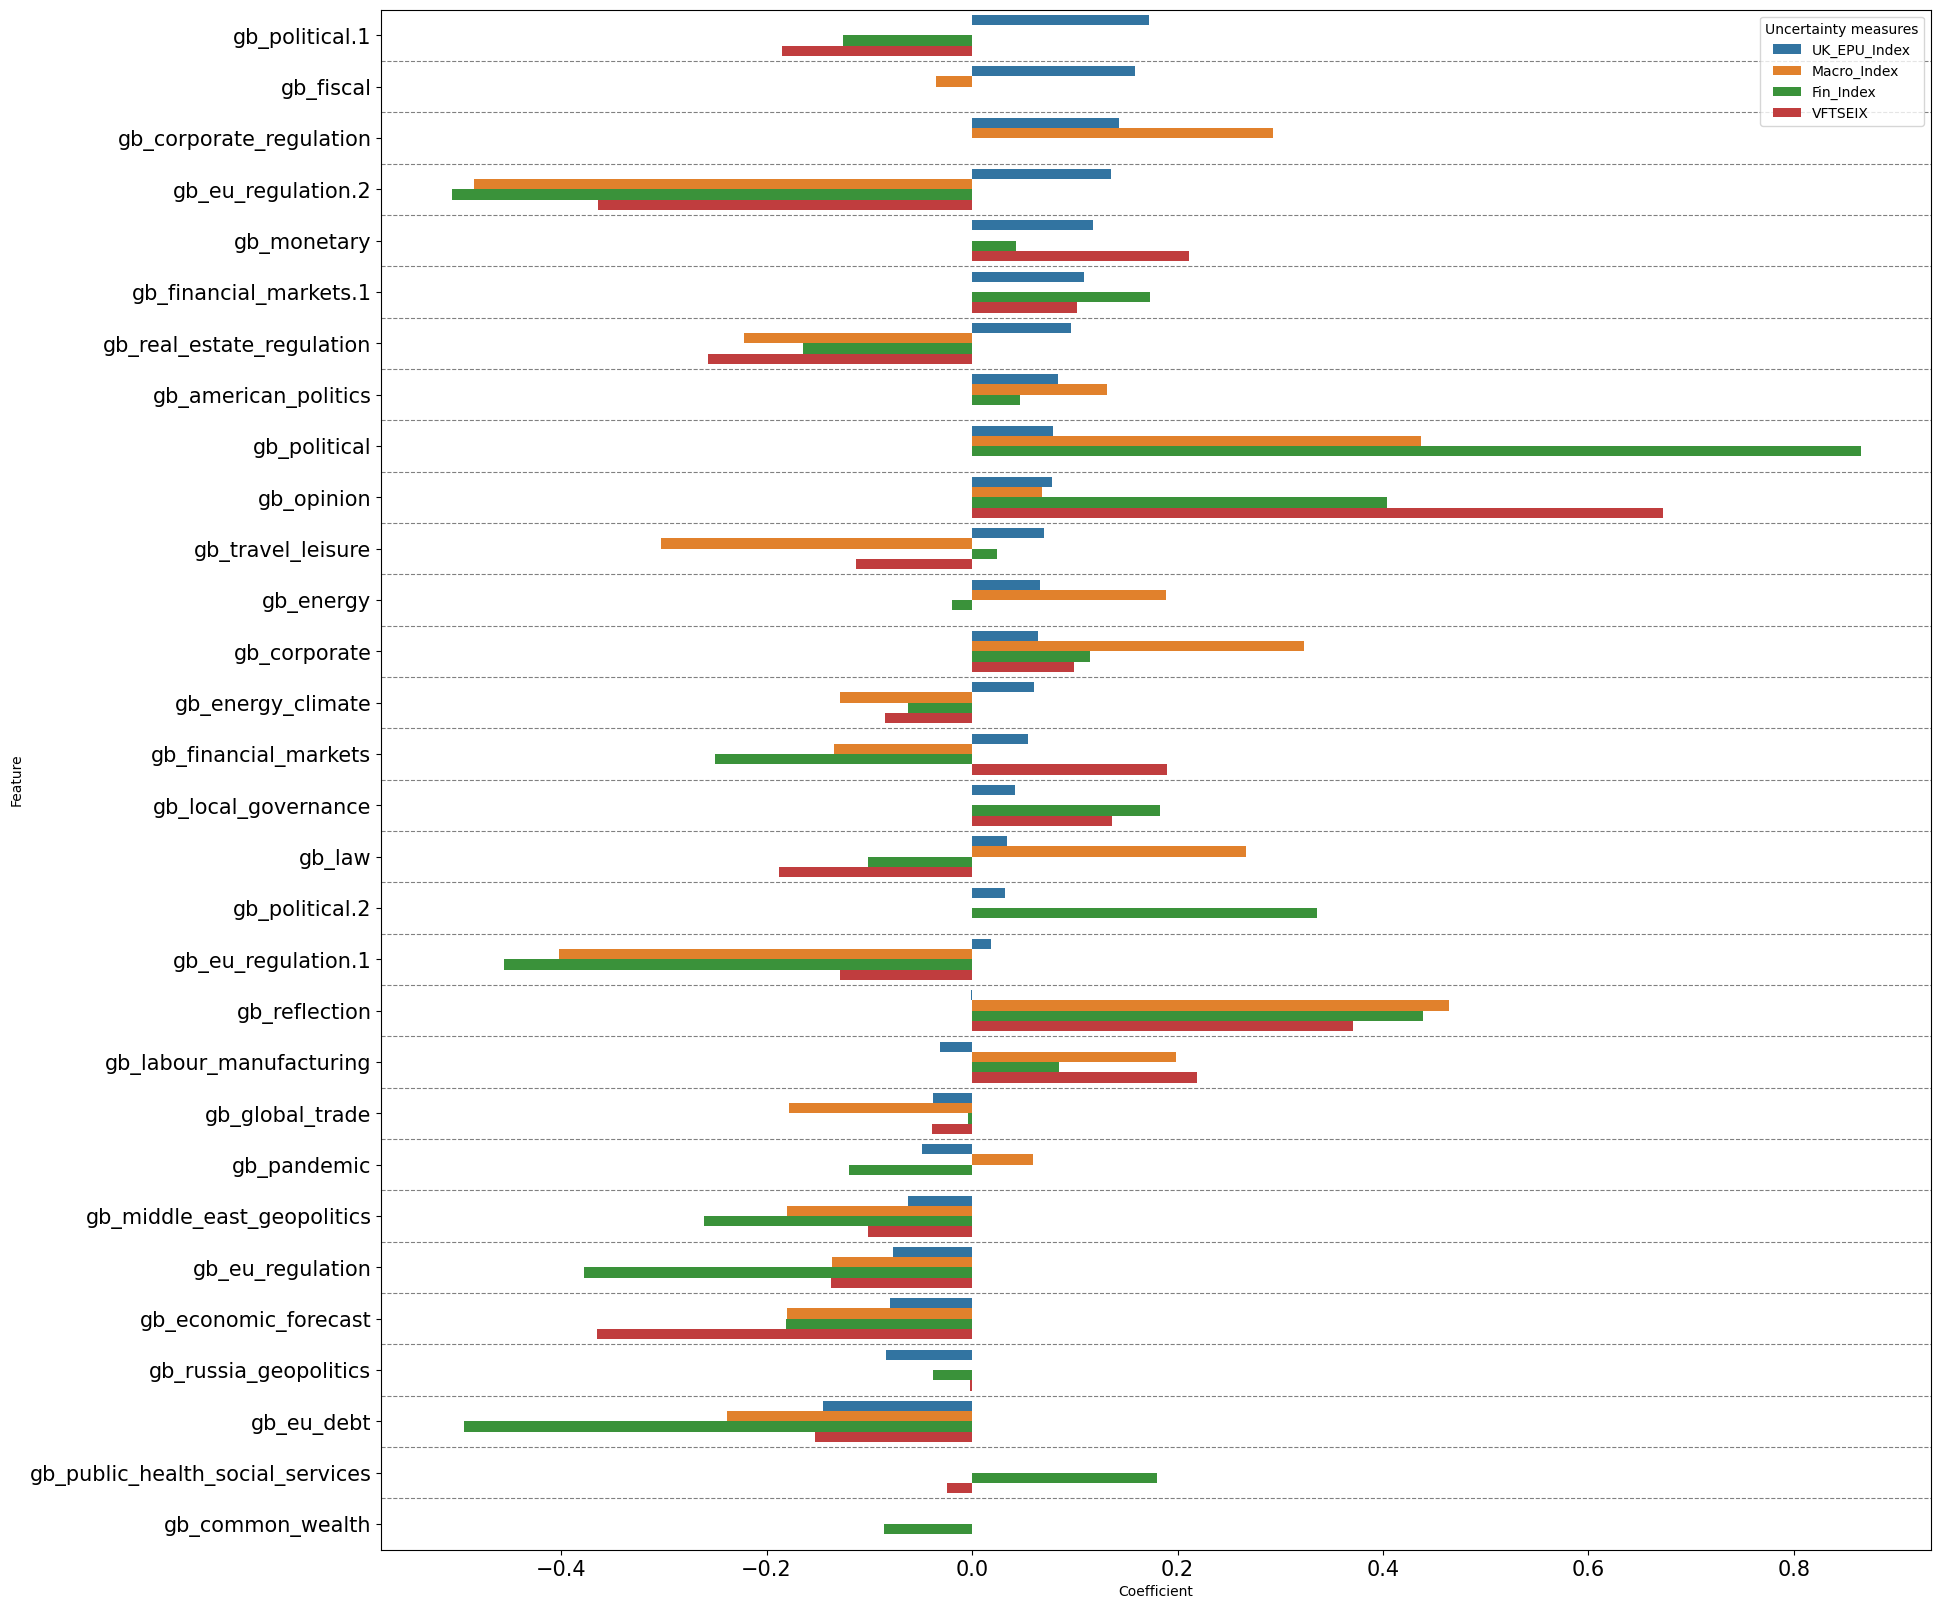

In [34]:
dfplot_test = analysis_uk.plot_coeff_all_y(mode="horizontal")

In [35]:
dfplot_test.columns

Index(['Feature', 'Coefficient', 'Uncertainty measure'], dtype='object')

In [36]:
top5 = dfplot_test.copy()

In [37]:
top5marina = top5.pivot(index='Feature',columns='Uncertainty measure' ,values='Coefficient')

In [38]:
top5marina
#top5marina.to_csv("full_reg_pivot_X_standard.csv")

Uncertainty measure               Fin_Index  Macro_Index  UK_EPU_Index  \
Feature                                                                  
gb_american_politics               0.046254     0.131231      0.083582   
gb_common_wealth                  -0.086005          NaN           NaN   
gb_corporate                       0.115154     0.323095      0.063881   
gb_corporate_regulation                 NaN     0.292647      0.143089   
gb_economic_forecast              -0.180785    -0.180019     -0.080009   
gb_energy                         -0.019722     0.188402      0.066504   
gb_energy_climate                 -0.062404    -0.128996      0.060327   
gb_eu_debt                        -0.494042    -0.238646     -0.144909   
gb_eu_regulation                  -0.377439    -0.136073     -0.077197   
gb_eu_regulation.1                -0.455704    -0.402079      0.018570   
gb_eu_regulation.2                -0.506573    -0.484689      0.135615   
gb_financial_markets              -0.249755    -0.134085      0.054261   
gb_financial_markets.1             0.173002          NaN      0.108854   
gb_fiscal                               NaN    -0.034946      0.158692   
gb_global_trade                   -0.004253    -0.178020     -0.038196   
gb_labour_manufacturing            0.084865     0.198571     -0.030741   
gb_law                            -0.101289     0.266899      0.033943   
gb_local_governance                0.183371          NaN      0.041499   
gb_middle_east_geopolitics        -0.261163    -0.180152     -0.062131   
gb_monetary                        0.042587          NaN      0.117941   
gb_opinion                         0.403684     0.068327      0.078002   
gb_pandemic                       -0.120146     0.059549     -0.048664   
gb_political                       0.864954     0.436988      0.078429   
gb_political.1                    -0.125379          NaN      0.172499   
gb_political.2                     0.335728          NaN      0.031925   
gb_public_health_social_services   0.180356          NaN           NaN   
gb_real_estate_regulation         -0.164475    -0.222030      0.096044   
gb_reflection                      0.438964     0.464579     -0.001401   
gb_russia_geopolitics             -0.038332          NaN     -0.083599   
gb_travel_leisure                  0.024563    -0.302380      0.070279   

Uncertainty measure                VFTSEIX  
Feature                                     
gb_american_politics                   NaN  
gb_common_wealth                       NaN  
gb_corporate                      0.099443  
gb_corporate_regulation                NaN  
gb_economic_forecast             -0.365209  
gb_energy                              NaN  
gb_energy_climate                -0.084973  
gb_eu_debt                       -0.153228  
gb_eu_regulation                 -0.137539  
gb_eu_regulation.1               -0.128300  
gb_eu_regulation.2               -0.363846  
gb_financial_markets              0.189589  
gb_financial_markets.1            0.101736  
gb_fiscal                              NaN  
gb_global_trade                  -0.038677  
gb_labour_manufacturing           0.218985  
gb_law                           -0.188275  
gb_local_governance               0.136135  
gb_middle_east_geopolitics       -0.101058  
gb_monetary                       0.210874  
gb_opinion                        0.672594  
gb_pandemic                            NaN  
gb_political                           NaN  
gb_political.1                   -0.184899  
gb_political.2                         NaN  
gb_public_health_social_services -0.024212  
gb_real_estate_regulation        -0.256848  
gb_reflection                     0.370669  
gb_russia_geopolitics            -0.002035  
gb_travel_leisure                -0.112511

#### Seems like the important coefficients have all changed with the normalization.
    At least for the EPU index from the uk.

## 3.2 Analysis US.
    

In [132]:
analysis_us = Analysis(df_usa,'United States','usa')
print(analysis_us)

Analysis of UNITED STATES, from ['1990', '2016'] for EPU REBORN


In [44]:
analysis_us.yvars

['News_Based_Policy_Uncert_Index', 'Macro_Index', 'Fin_Index', 'VIXCLS']

In [53]:
us_epu = 'News_Based_Policy_Uncert_Index'
us_fin = 'Macro_Index'
us_macro = 'Macro_Index'
us_vix = 'VIXCLS'

These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.025728290870235117 and for RIDGE: 10.0
These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.0007257032850490521 and for RIDGE: 10.0
These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.0007257032850490521 and for RIDGE: 10.0
These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Macro_Index', 'Fin_Index', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.0036468

Feature  Coefficient Estimator
0              usa_Elections    -0.044437     RIDGE
1          usa_Fiscal Policy    -0.121449     RIDGE
2                 usa_Europe    -0.009439     RIDGE
3               usa_Industry     0.404762     RIDGE
4           usa_Stock Market     0.086682     RIDGE
5             usa_Literature    -0.000927     RIDGE
6                 usa_Sports     0.059395     RIDGE
7              usa_Education    -0.075843     RIDGE
8         usa_Global Warming    -0.012321     RIDGE
9        usa_Great Recession    -0.111847     RIDGE
10                usa_Russia    -0.022699     RIDGE
11      usa_Regional Projets    -0.032282     RIDGE
12            usa_Oil Prices     0.024440     RIDGE
13               usa_Housing     0.061562     RIDGE
14                 usa_Media    -0.048529     RIDGE
15           usa_Immigration    -0.027168     RIDGE
16              usa_Conflict    -0.017875     RIDGE
17            usa_Healthcare     0.013269     RIDGE
18       usa_Monetary policy    -0.171130     RIDGE
19           usa_Preferences     0.160576     RIDGE
20              usa_Politics    -0.057980     RIDGE
21                usa_Energy    -0.118511     RIDGE
22                  usa_Food     0.085779     RIDGE
23                   usa_Law     0.037302     RIDGE
24  usa_Financial Investment     0.295021     RIDGE
25                usa_Unkown     0.005353     RIDGE
26                 usa_Trade    -0.020804     RIDGE
27                   usa_Art    -0.014832     RIDGE
28     usa_Critical thinking    -0.119370     RIDGE
29      usa_Financial Crisis     0.340419     RIDGE
0              usa_Elections    -0.044391     LASSO
1          usa_Fiscal Policy    -0.122448     LASSO
2                 usa_Europe    -0.002089     LASSO
3               usa_Industry     0.429684     LASSO
4           usa_Stock Market     0.081028     LASSO
5             usa_Literature    -0.000000     LASSO
6                 usa_Sports     0.052727     LASSO
7              usa_Education    -0.078855     LASSO
8         usa_Global Warming    -0.010268     LASSO
9        usa_Great Recession    -0.115048     LASSO
10                usa_Russia    -0.020087     LASSO
11      usa_Regional Projets    -0.030846     LASSO
12            usa_Oil Prices     0.017644     LASSO
13               usa_Housing     0.055335     LASSO
14                 usa_Media    -0.047651     LASSO
15           usa_Immigration    -0.022106     LASSO
16              usa_Conflict    -0.009556     LASSO
17            usa_Healthcare     0.010200     LASSO
18       usa_Monetary policy    -0.186910     LASSO
19           usa_Preferences     0.152871     LASSO
20              usa_Politics    -0.059954     LASSO
21                usa_Energy    -0.120484     LASSO
22                  usa_Food     0.081403     LASSO
23                   usa_Law     0.032066     LASSO
24  usa_Financial Investment     0.303133     LASSO
25                usa_Unkown     0.000809     LASSO
26                 usa_Trade    -0.017547     LASSO
27                   usa_Art    -0.011614     LASSO
28     usa_Critical thinking    -0.127764     LASSO
29      usa_Financial Crisis     0.359253     LASSO

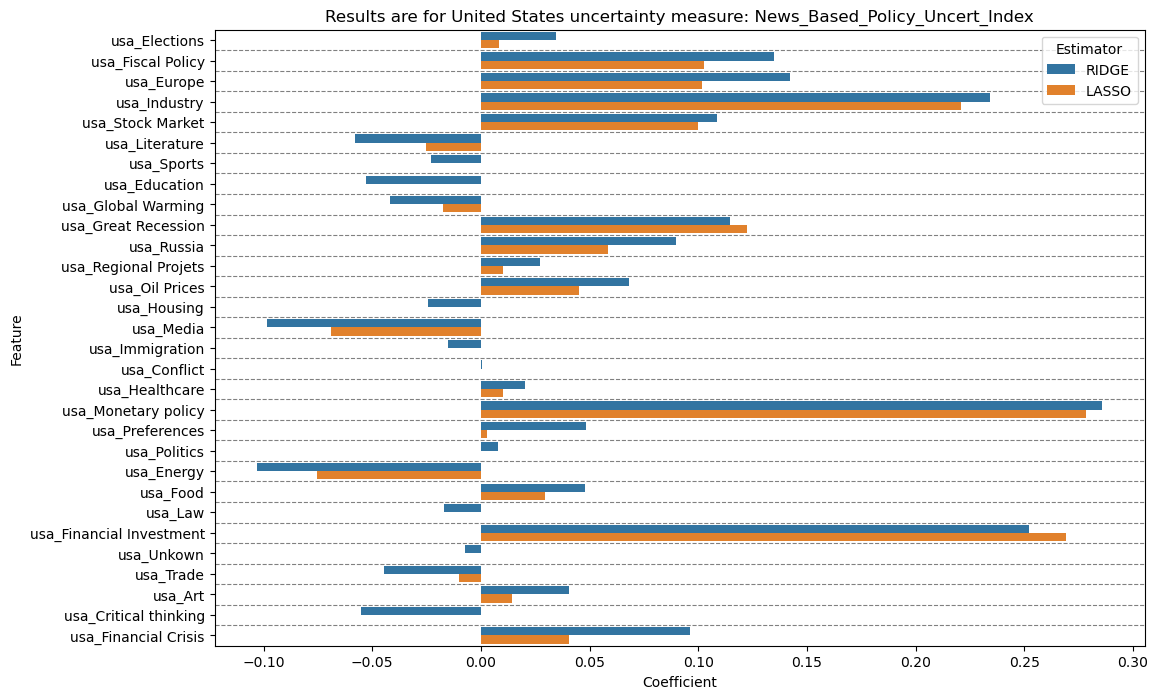

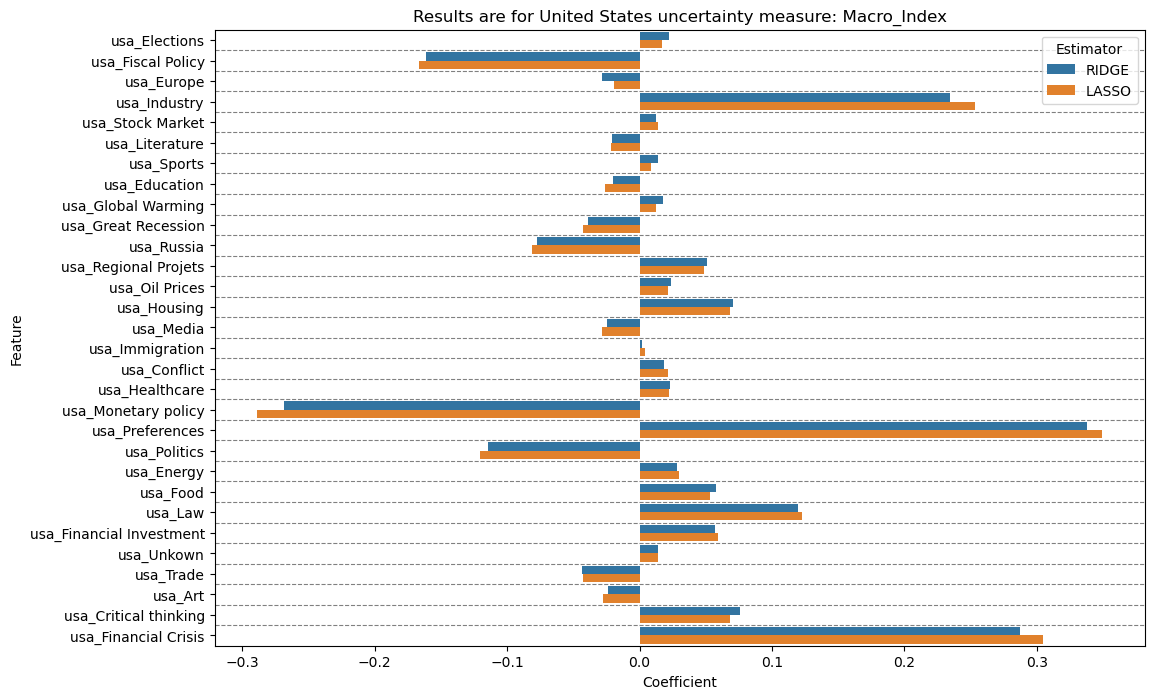

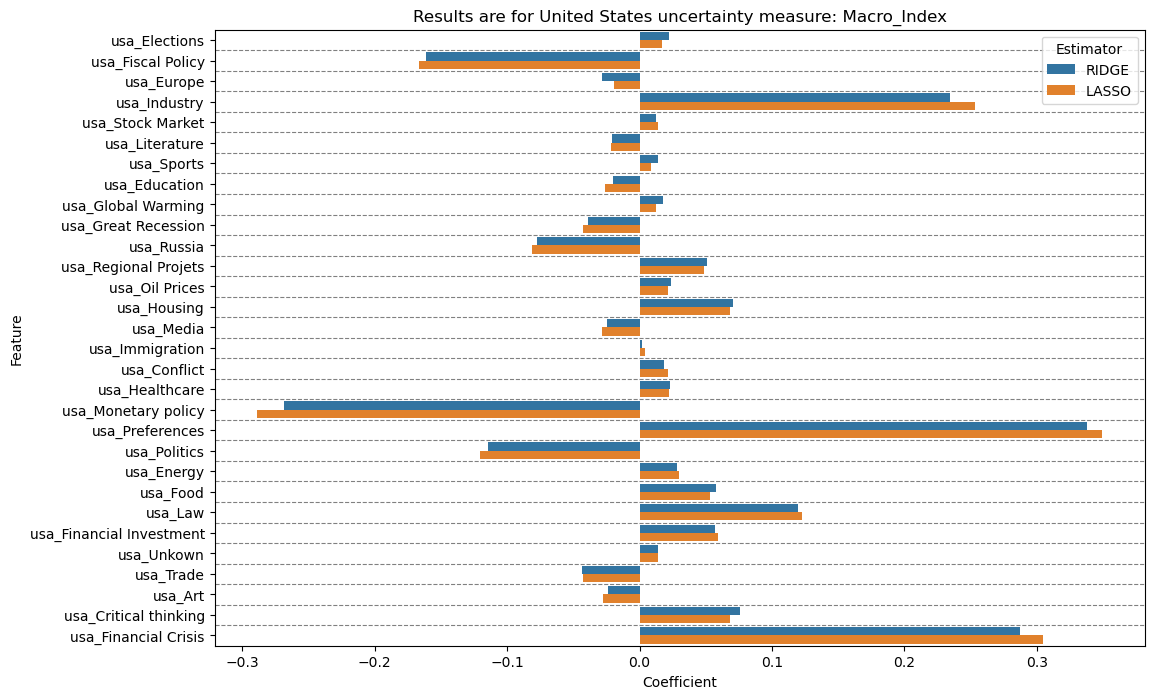

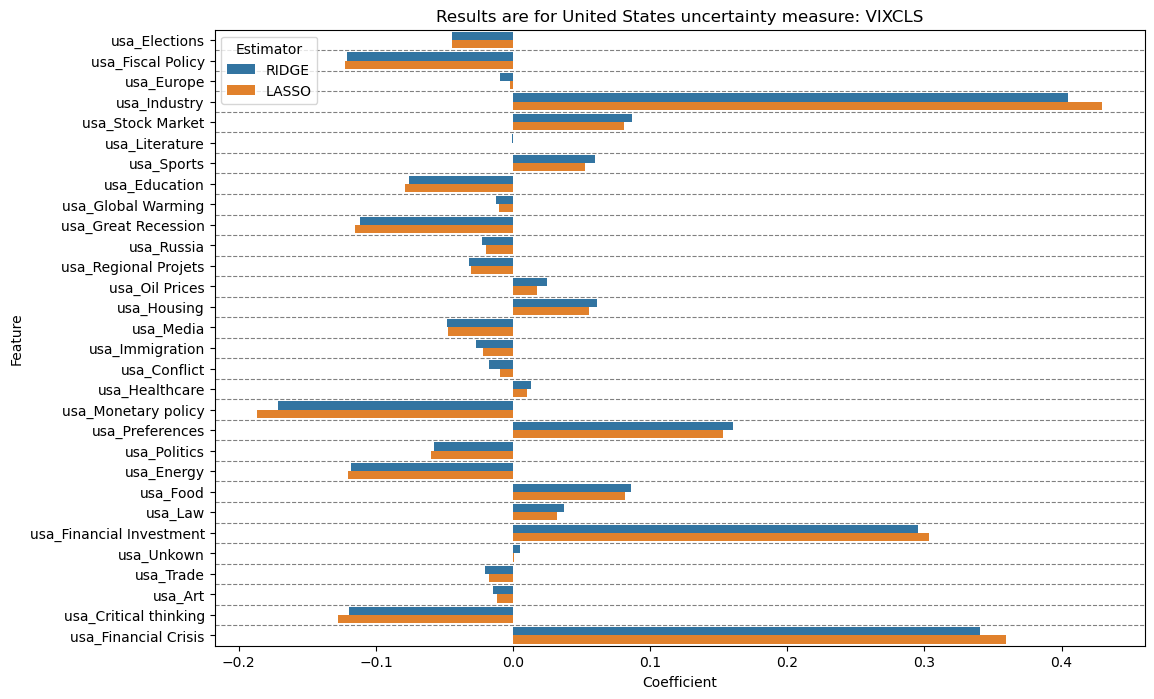

In [54]:
analysis_us.lasso_ridge(chosen_yvar=us_epu)
analysis_us.lasso_ridge(chosen_yvar=us_macro)
analysis_us.lasso_ridge(chosen_yvar=us_fin)
analysis_us.lasso_ridge(chosen_yvar=us_vix)

These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.025728290870235117
These are the cols to drop from the lasso with optimal alpha: ['usa_Sports', 'usa_Education', 'usa_Housing', 'usa_Immigration', 'usa_Conflict', 'usa_Politics', 'usa_Law', 'usa_Unkown', 'usa_Critical thinking']
These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VIXCLS', 'date', 'usa_Sports', 'usa_Education', 'usa_Housing', 'usa_Immigration', 'usa_Conflict', 'usa_Politics', 'usa_Law', 'usa_Unkown', 'usa_Critical thinking']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.7515761065172931


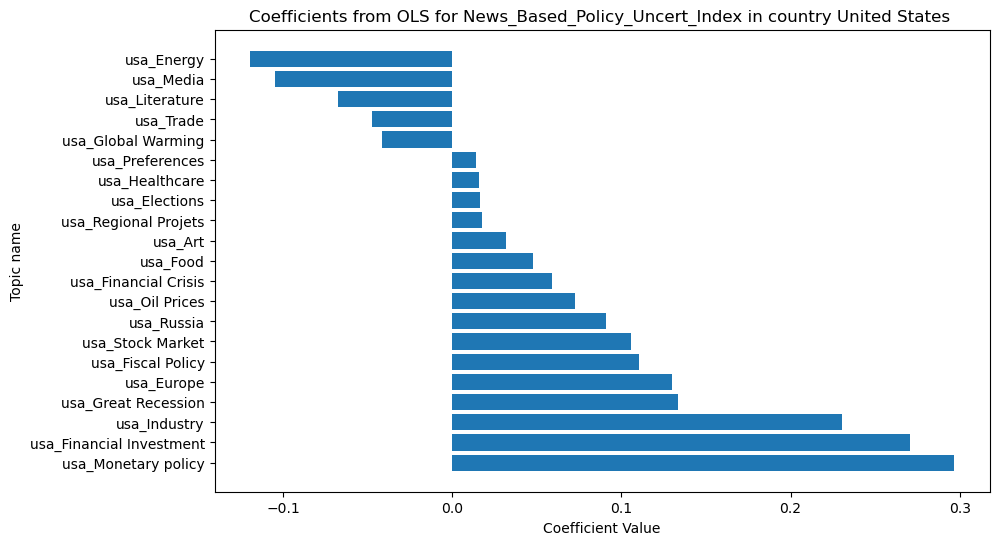

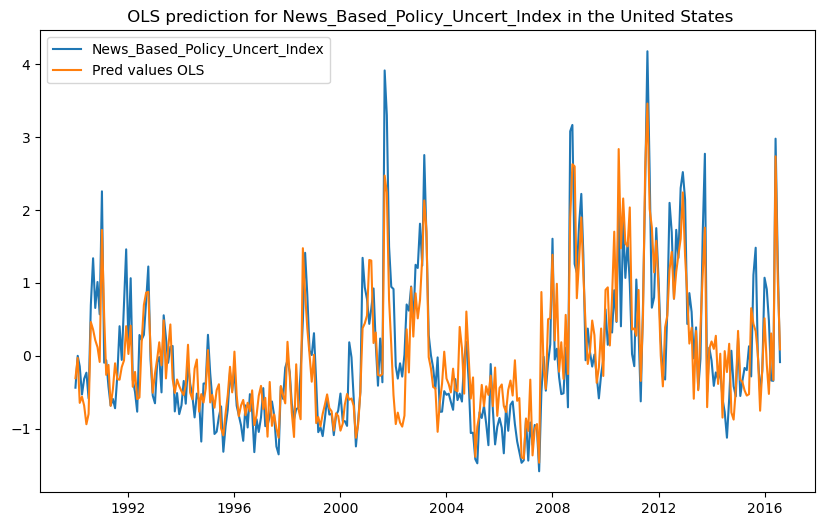

This is the variance inflation factor for the remaining variables.
usa_Financial Crisis        2.519422
usa_Preferences             2.475355
usa_Monetary policy         2.435920
usa_Industry                2.315578
usa_Fiscal Policy           1.976048
usa_Elections               1.764960
usa_Financial Investment    1.750765
usa_Stock Market            1.715269
usa_Regional Projets        1.457936
usa_Art                     1.376144
usa_Energy                  1.327554
usa_Europe                  1.321316
usa_Literature              1.278001
usa_Great Recession         1.267826
usa_Healthcare              1.249201
usa_Food                    1.193604
usa_Global Warming          1.182950
usa_Trade                   1.144978
usa_Oil Prices              1.143515
usa_Media                   1.091977
usa_Russia                  1.081861
dtype: float64


Feature  Coefficient
13       usa_Monetary policy     0.296740
17  usa_Financial Investment     0.270432
3               usa_Industry     0.230155
7        usa_Great Recession     0.133649
2                 usa_Europe     0.130129
1          usa_Fiscal Policy     0.110552
4           usa_Stock Market     0.105796
8                 usa_Russia     0.091131
10            usa_Oil Prices     0.072372
20      usa_Financial Crisis     0.058735
16                  usa_Food     0.047547
19                   usa_Art     0.031834
9       usa_Regional Projets     0.017398
0              usa_Elections     0.016670
12            usa_Healthcare     0.015603
14           usa_Preferences     0.013901
6         usa_Global Warming    -0.041530
18                 usa_Trade    -0.047327
5             usa_Literature    -0.067596
11                 usa_Media    -0.104507
15                usa_Energy    -0.119708

In [55]:
analysis_us.lasso_ols(chosen_yvar=us_epu)
"""
Much lower VIF! Seems like different methodology or something!
"""

These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.0007257032850490521
These are the cols to drop from the lasso with optimal alpha: []
These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.7036192371815295


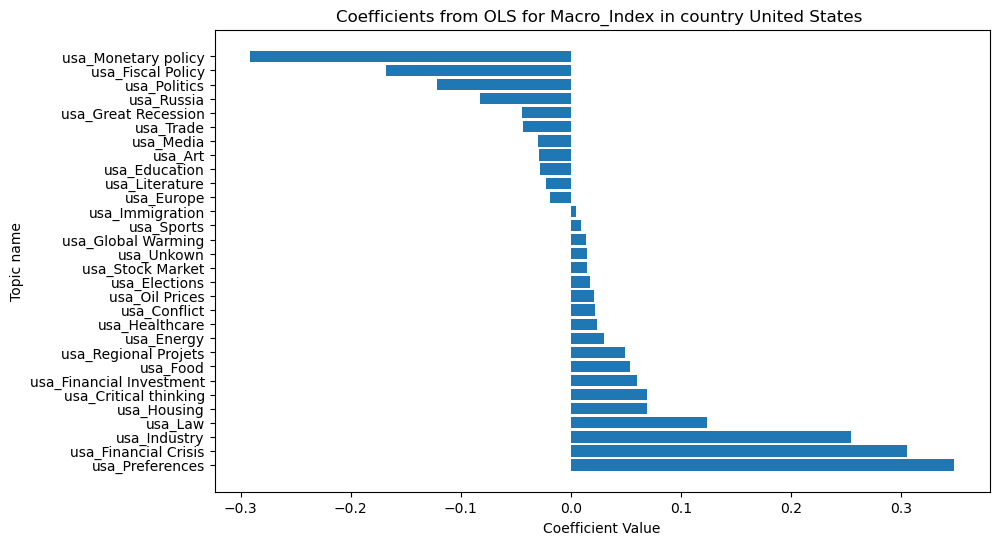

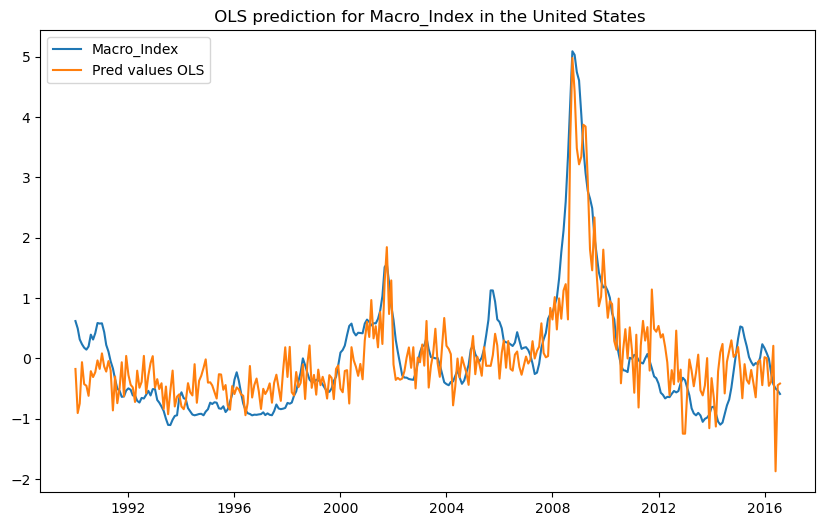

This is the variance inflation factor for the remaining variables.
usa_Financial Crisis        3.109495
usa_Preferences             2.867327
usa_Monetary policy         2.689741
usa_Industry                2.459056
usa_Critical thinking       2.286490
usa_Fiscal Policy           2.216446
usa_Education               1.833652
usa_Housing                 1.832304
usa_Elections               1.827836
usa_Financial Investment    1.827620
usa_Stock Market            1.776838
usa_Law                     1.649471
usa_Regional Projets        1.558371
usa_Europe                  1.538626
usa_Sports                  1.520631
usa_Art                     1.460315
usa_Energy                  1.379803
usa_Great Recession         1.367038
usa_Literature              1.355593
usa_Conflict                1.354287
usa_Healthcare              1.305878
usa_Politics                1.279998
usa_Food                    1.257826
usa_Oil Prices              1.244355
usa_Global Warming          1.222108
usa_Trad

Feature  Coefficient
19           usa_Preferences     0.348324
29      usa_Financial Crisis     0.305580
3               usa_Industry     0.254433
23                   usa_Law     0.123746
13               usa_Housing     0.069421
28     usa_Critical thinking     0.068900
24  usa_Financial Investment     0.060499
22                  usa_Food     0.053681
11      usa_Regional Projets     0.049332
21                usa_Energy     0.030268
17            usa_Healthcare     0.023315
16              usa_Conflict     0.022250
12            usa_Oil Prices     0.021390
0              usa_Elections     0.017593
4           usa_Stock Market     0.014865
25                usa_Unkown     0.014504
8         usa_Global Warming     0.013671
6                 usa_Sports     0.009297
15           usa_Immigration     0.004845
2                 usa_Europe    -0.019249
5             usa_Literature    -0.022301
7              usa_Education    -0.028012
27                   usa_Art    -0.029087
14                 usa_Media    -0.030250
26                 usa_Trade    -0.043019
9        usa_Great Recession    -0.044215
10                usa_Russia    -0.082068
20              usa_Politics    -0.121430
1          usa_Fiscal Policy    -0.168321
18       usa_Monetary policy    -0.291671

In [56]:
analysis_us.lasso_ols(chosen_yvar=us_fin)

These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen 0.025728290870235117
These are the cols to drop from the lasso with optimal alpha: ['usa_Sports', 'usa_Education', 'usa_Housing', 'usa_Immigration', 'usa_Conflict', 'usa_Politics', 'usa_Law', 'usa_Unkown', 'usa_Critical thinking']
These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VIXCLS', 'date', 'usa_Sports', 'usa_Education', 'usa_Housing', 'usa_Immigration', 'usa_Conflict', 'usa_Politics', 'usa_Law', 'usa_Unkown', 'usa_Critical thinking']. This is a temporary check.
Applied standard scaling to the X and y
The score/R^2 of the model is 0.7515761065172931
This is the variance inflation factor for the remaining variables.
usa_Financial Crisis        2.519422
usa_Preferences             2.475355
usa_Monetary policy         2.435920
usa_Industry                2.315578
usa_Fiscal 

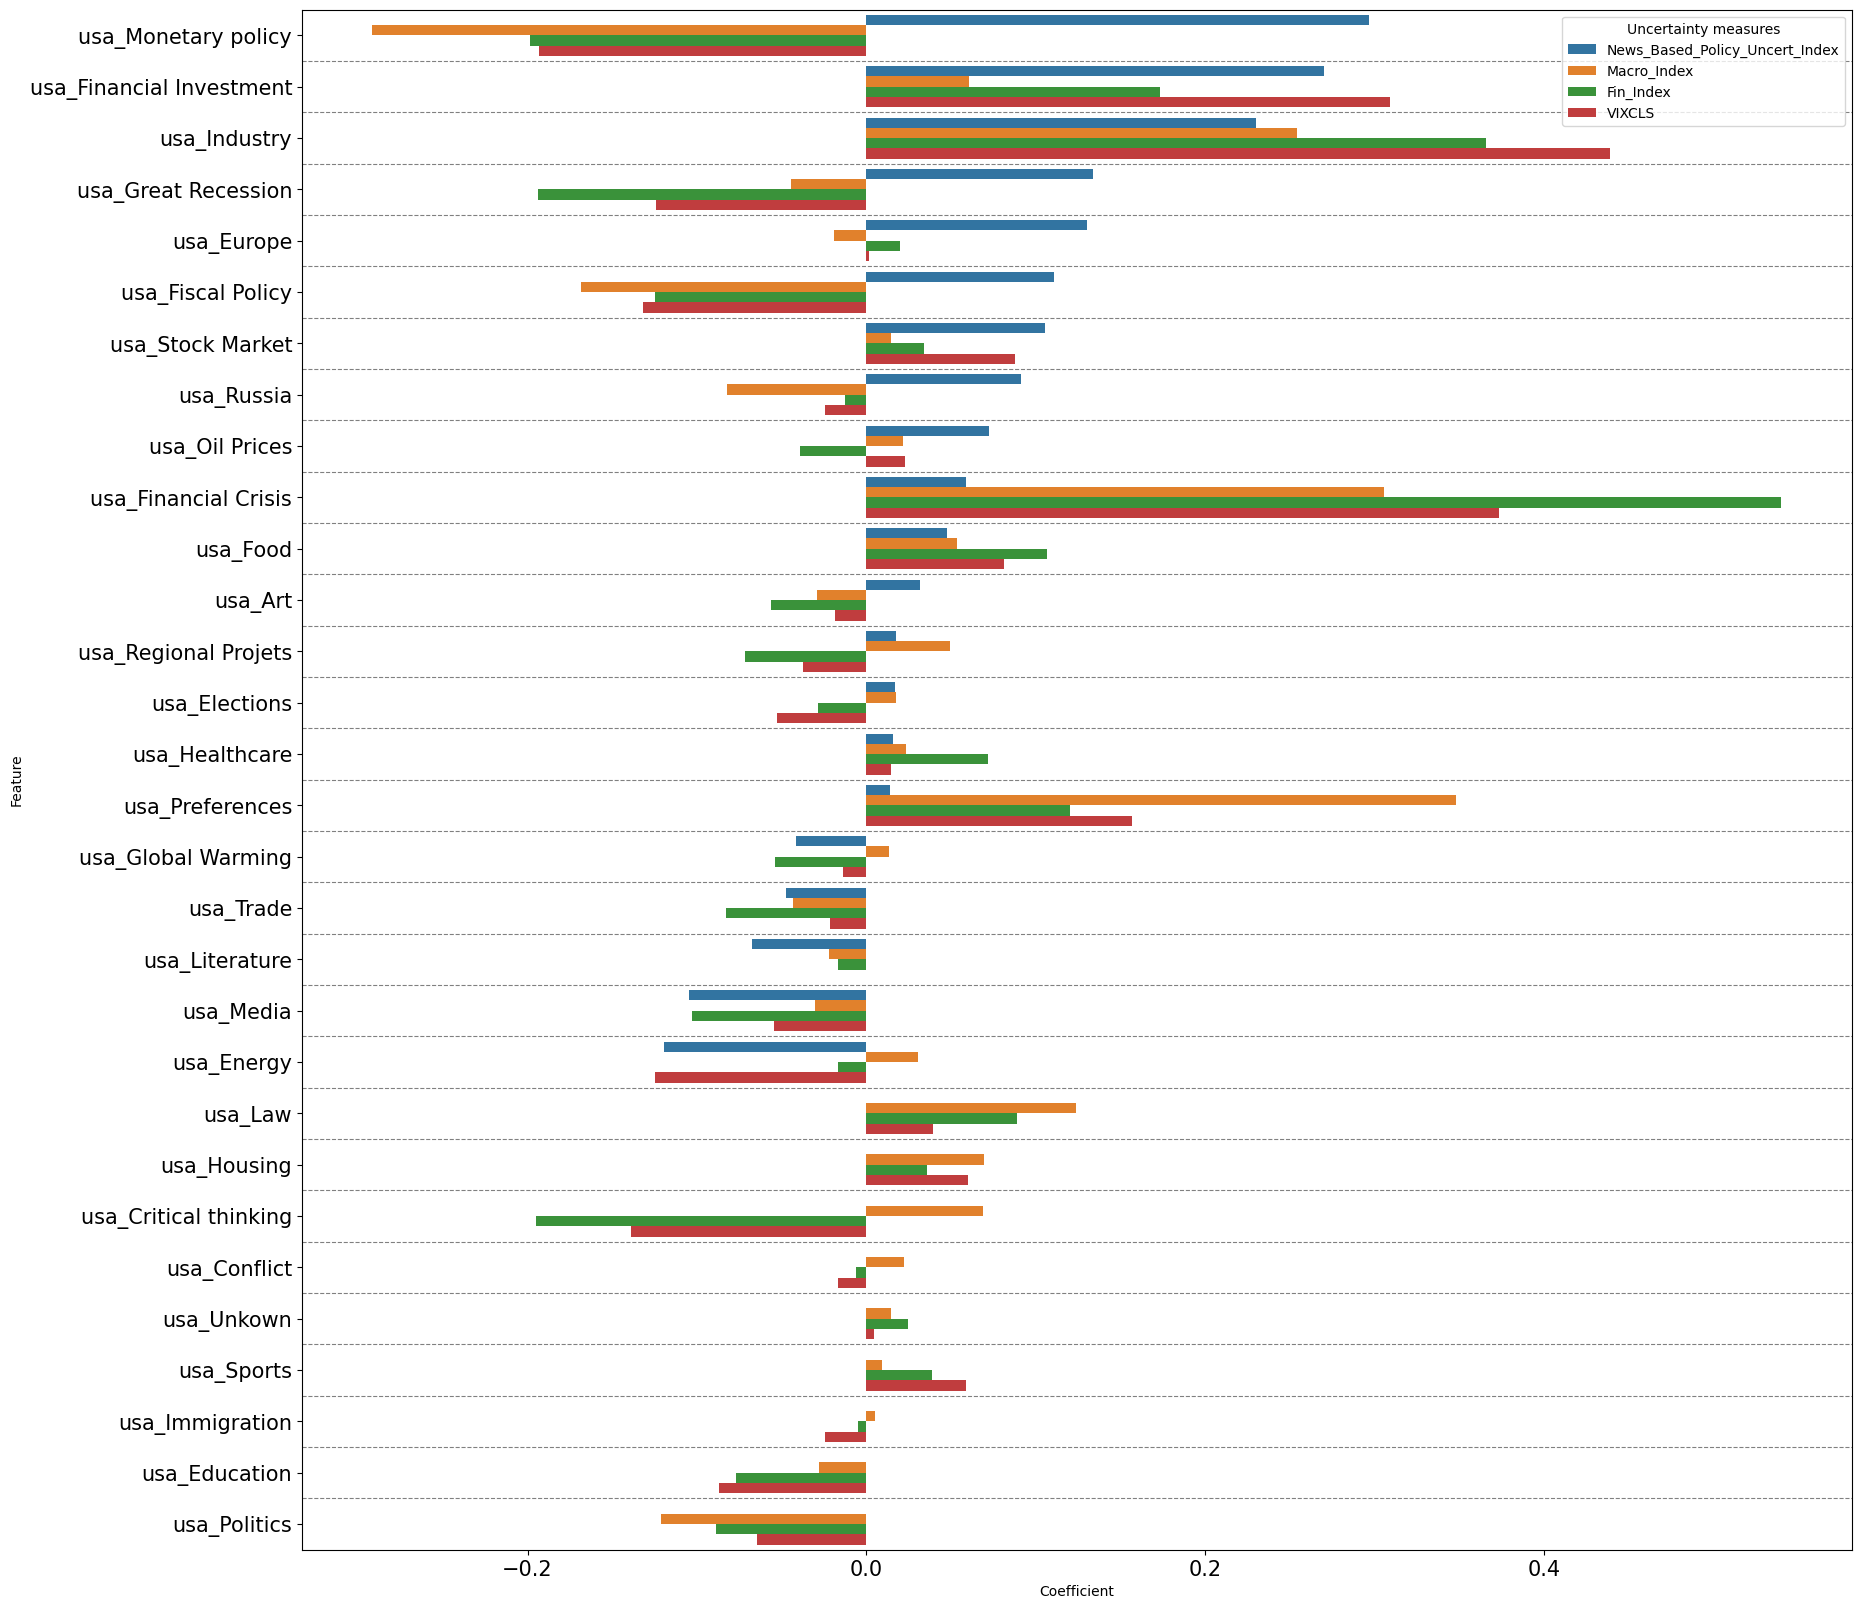

'\nAre we not just overfitting with OLS? Talk to Jiaxuan or some econometrician this Friday.\n'

In [61]:
data_marina_us = analysis_us.plot_coeff_all_y(mode="horizontal")
"""
Are we not overfitting with OLS? Talk to Jiaxuan or some econometrician this Friday/Saturday.
In the end on Saturday 21st.
"""

In [62]:
data_marina_us = data_marina_us.pivot(index='Feature',columns='Uncertainty measure' ,values='Coefficient')

In [63]:
data_marina_us 

Uncertainty measure       Fin_Index  Macro_Index  \
Feature                                            
usa_Art                   -0.056515    -0.029087   
usa_Conflict              -0.005891     0.022250   
usa_Critical thinking     -0.194814     0.068900   
usa_Education             -0.077235    -0.028012   
usa_Elections             -0.028523     0.017593   
usa_Energy                -0.016891     0.030268   
usa_Europe                 0.019791    -0.019249   
usa_Financial Crisis       0.540372     0.305580   
usa_Financial Investment   0.173277     0.060499   
usa_Fiscal Policy         -0.125006    -0.168321   
usa_Food                   0.106655     0.053681   
usa_Global Warming        -0.053688     0.013671   
usa_Great Recession       -0.193917    -0.044215   
usa_Healthcare             0.071803     0.023315   
usa_Housing                0.035621     0.069421   
usa_Immigration           -0.005110     0.004845   
usa_Industry               0.365913     0.254433   
usa_Law                    0.089040     0.123746   
usa_Literature            -0.016724    -0.022301   
usa_Media                 -0.102979    -0.030250   
usa_Monetary policy       -0.198350    -0.291671   
usa_Oil Prices            -0.039367     0.021390   
usa_Politics              -0.088836    -0.121430   
usa_Preferences            0.120537     0.348324   
usa_Regional Projets      -0.071627     0.049332   
usa_Russia                -0.012353    -0.082068   
usa_Sports                 0.039001     0.009297   
usa_Stock Market           0.033871     0.014865   
usa_Trade                 -0.082766    -0.043019   
usa_Unkown                 0.024466     0.014504   

Uncertainty measure       News_Based_Policy_Uncert_Index    VIXCLS  
Feature                                                             
usa_Art                                         0.031834 -0.018305  
usa_Conflict                                         NaN -0.016516  
usa_Critical thinking                                NaN -0.138699  
usa_Education                                        NaN -0.086801  
usa_Elections                                   0.016670 -0.052724  
usa_Energy                                     -0.119708 -0.124947  
usa_Europe                                      0.130129  0.001346  
usa_Financial Crisis                            0.058735  0.373375  
usa_Financial Investment                        0.270432  0.309461  
usa_Fiscal Policy                               0.110552 -0.131611  
usa_Food                                        0.047547  0.081136  
usa_Global Warming                             -0.041530 -0.013663  
usa_Great Recession                             0.133649 -0.123923  
usa_Healthcare                                  0.015603  0.014752  
usa_Housing                                          NaN  0.060221  
usa_Immigration                                      NaN -0.024165  
usa_Industry                                    0.230155  0.439361  
usa_Law                                              NaN  0.039546  
usa_Literature                                 -0.067596       NaN  
usa_Media                                      -0.104507 -0.054683  
usa_Monetary policy                             0.296740 -0.193468  
usa_Oil Prices                                  0.072372  0.023024  
usa_Politics                                         NaN -0.064545  
usa_Preferences                                 0.013901  0.156845  
usa_Regional Projets                            0.017398 -0.037514  
usa_Russia                                      0.091131 -0.024197  
usa_Sports                                           NaN  0.058569  
usa_Stock Market                                0.105796  0.087783  
usa_Trade                                      -0.047327 -0.021674  
usa_Unkown                                           NaN  0.004760

In [64]:
data_marina_us.to_csv('full_pivot_us.csv')

### Lasso over alphas in us  12-09. 

In [785]:
for yvar in analysis_us.yvars:    
    analysis_us.plot_lasso_r(
        chosen_yvar=yvar,
        norm_type='standard',
        max_penalty=1
    )

NameError: name 'analysis_us' is not defined

### lasso ridge plots usa 12sept

These are the variables that are dropped: ['Macro_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.025728290870235117 and for RIDGE: 10.0


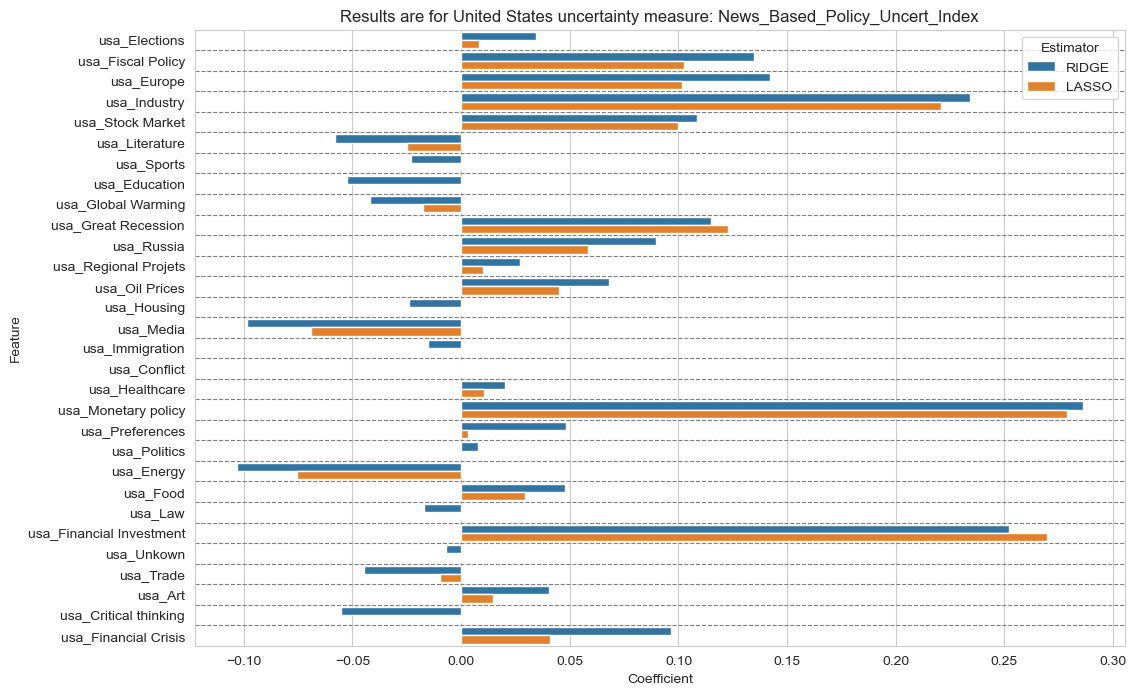

Figure saved here: results\plots\sept11//usa_symmetry_lasso_ridge_News_Based_Policy_Uncert_Index_13sept.pdf


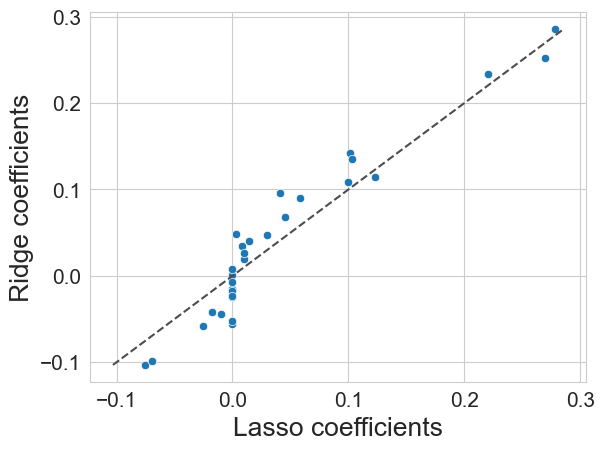

These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Fin_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.0007257032850490521 and for RIDGE: 10.0


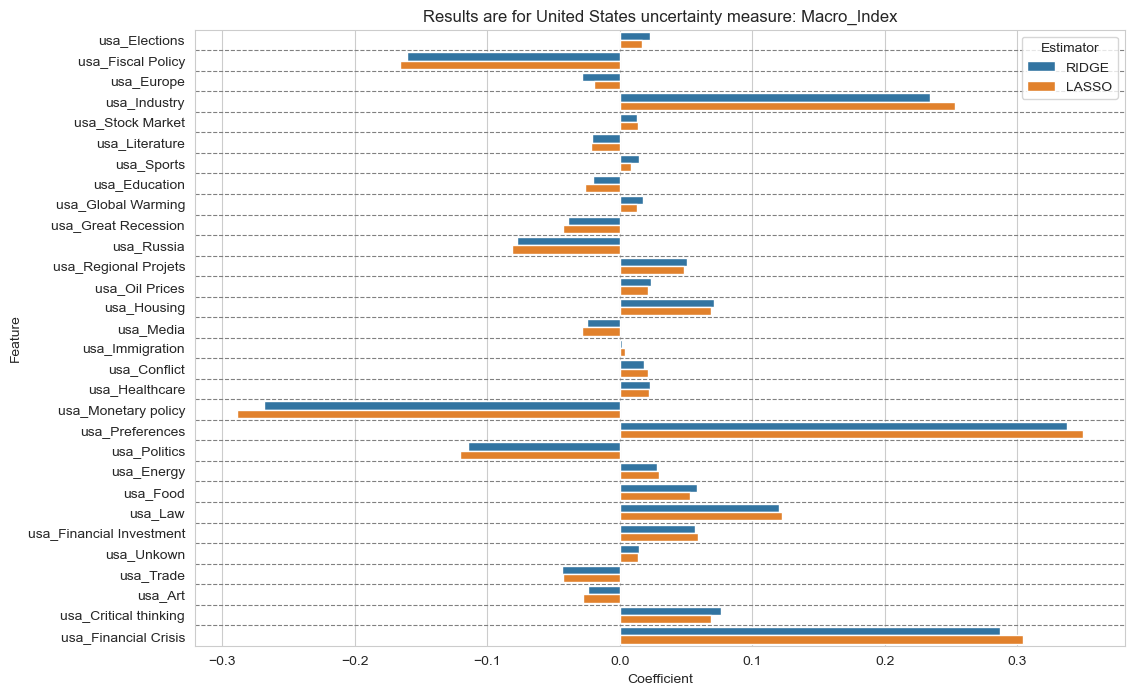

Figure saved here: results\plots\sept11//usa_symmetry_lasso_ridge_Macro_Index_13sept.pdf


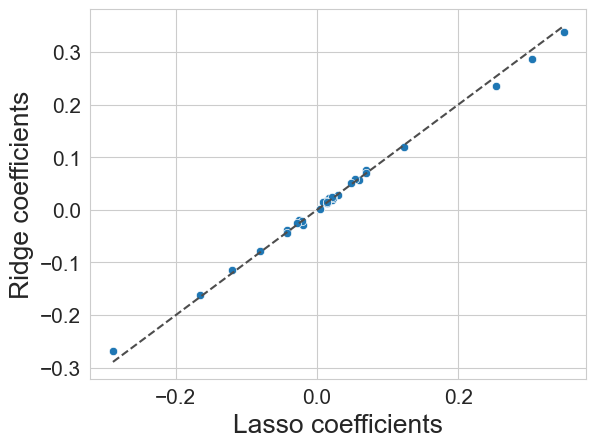

These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Macro_Index', 'VIXCLS', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.00318858630967731 and for RIDGE: 0.1


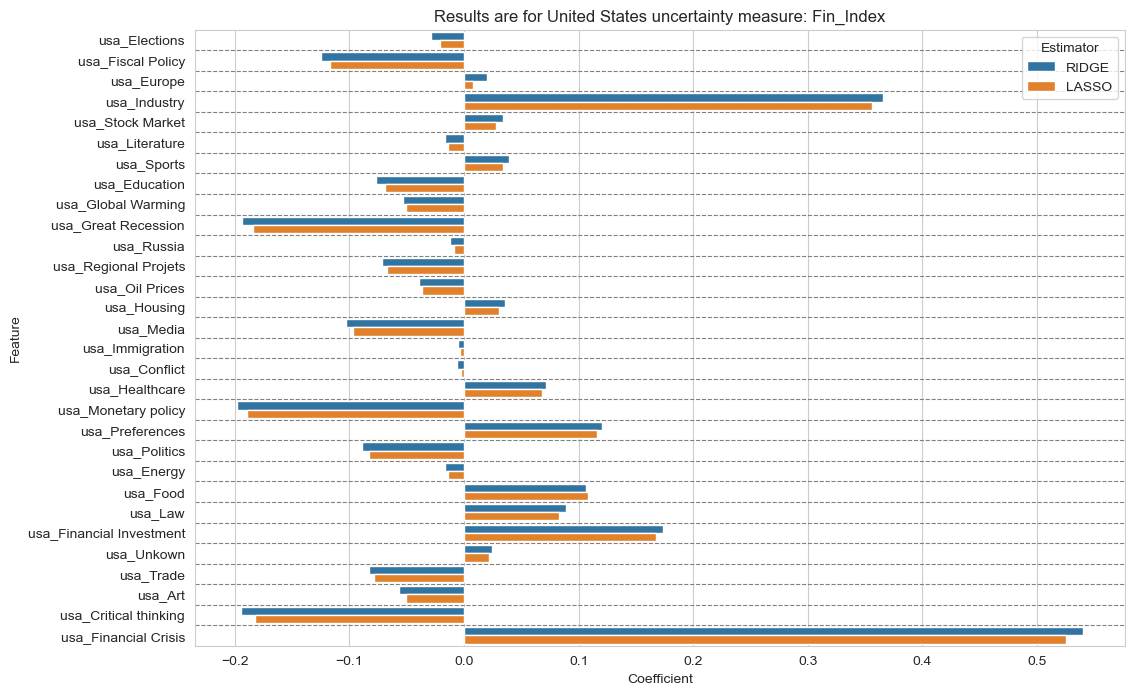

Figure saved here: results\plots\sept11//usa_symmetry_lasso_ridge_Fin_Index_13sept.pdf


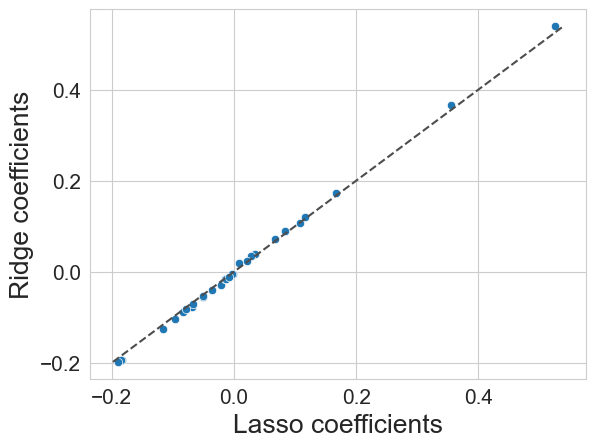

These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Macro_Index', 'Fin_Index', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.003646851438275507 and for RIDGE: 10.0


PermissionError: [Errno 13] Permission denied: 'results\\plots\\sept11//usa_VIXCLS_lasso_ridge_12sept.pdf'

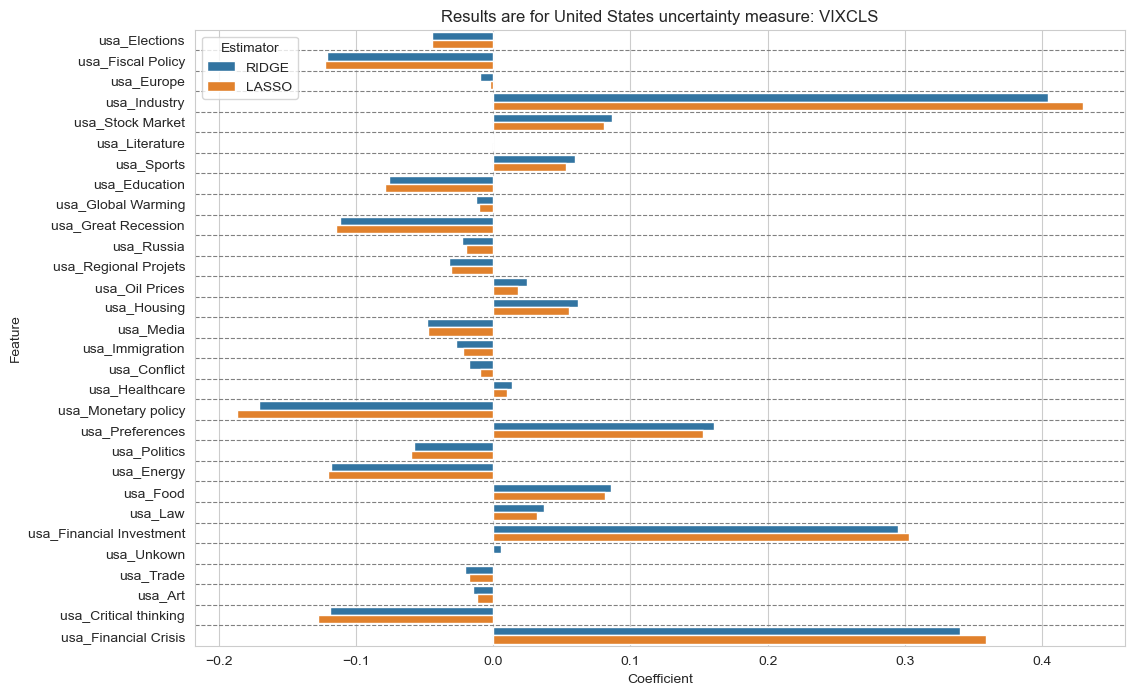

In [176]:
for yvar in analysis_us.yvars:
    data = analysis_us.lasso_ridge(chosen_yvar=yvar,path=plots+'sept11//'+f'usa_{yvar}_lasso_ridge_12sept.pdf')
    symmetry_test(data,yvar,country='United States',path=plots+'sept11//'+f'usa_symmetry_lasso_ridge_{yvar}_13sept.pdf')

These are the variables that are dropped: ['News_Based_Policy_Uncert_Index', 'Macro_Index', 'Fin_Index', 'date']. This is a temporary check.
Applied standard scaling to the X and y
This is the optimal alpha chosen for LASSO: 0.003646851438275507 and for RIDGE: 10.0


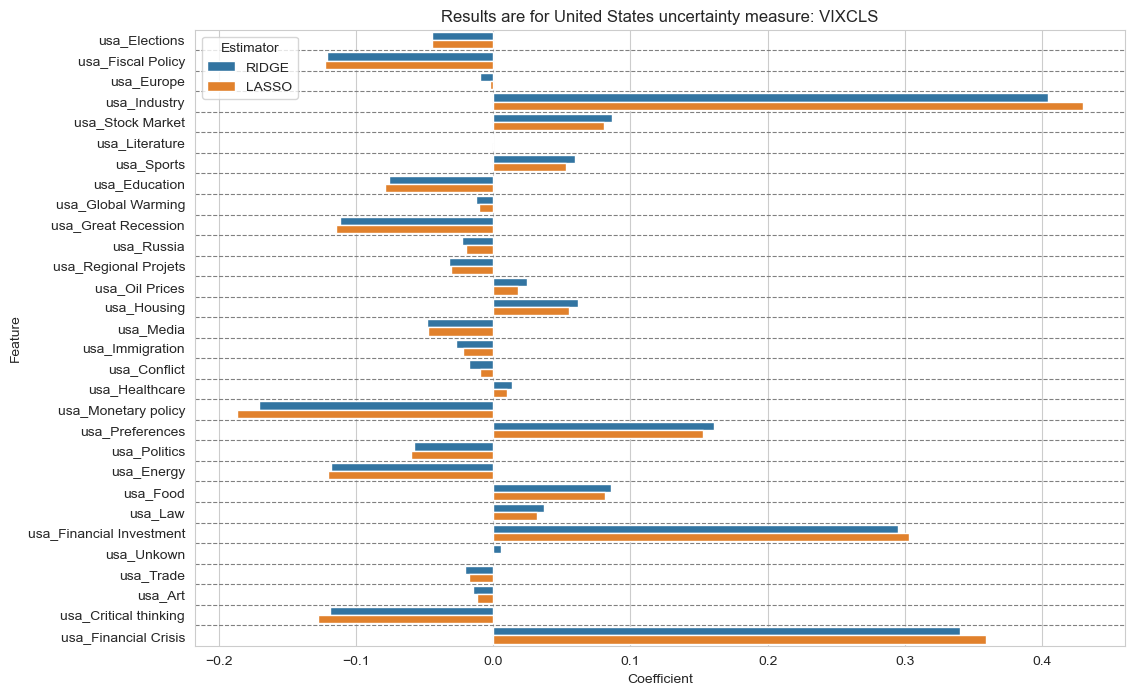

In [177]:
# Something wrong with the last one for the VIX... Test manually
data_vix_us = analysis_us.lasso_ridge(chosen_yvar='VIXCLS')

In [146]:
os.getcwd()

'C:\\Users\\Q64337\\Desktop\\EPU'

Figure saved here: usa_symmetry_lasso_ridge_VIXCLS_13sept.pdf


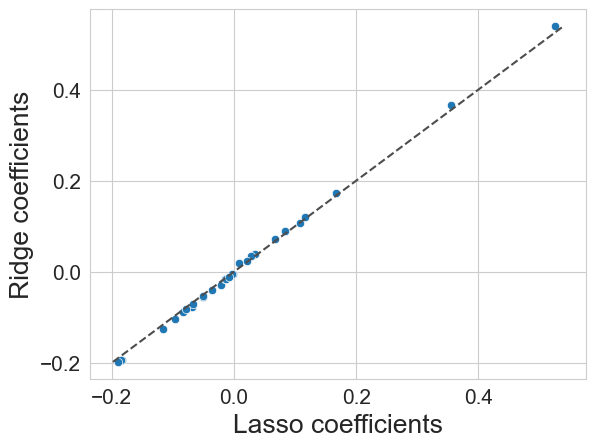

In [180]:
symmetry_test(data,yvar='VIXCLS',country='United States',path='usa_symmetry_lasso_ridge_VIXCLS_13sept.pdf')

MARINA'S MAGIC FOR COLOURS

def modify_hues_legend(actualvariables, barplot_object, n = 8):
    palette = sns.color_palette(n_colors = n)
    myhuedict = {}
    for var in actualvariables:
        newn = actualvariables.index(var)%n
        myhuedict[var] = {
            "colour": palette[newn],
            "hatch" : ""
        }
        if actualvariables.index(var) >= n:
            myhuedict[var]["hatch"] = "/"
    legend_handles, legend_labels = barplot_object.get_legend_handles_labels()
    patches = barplot_object.patches
    for cont in barplot_object.containers:
        for bar in cont:
            c = bar.get_facecolor()
            for handle, label in zip(legend_handles, legend_labels):
                if handle[1].get_facecolor() == c:
                    hue_value = label
                    handle[1].set_hatch(myhuedict[hue_value]["hatch"])
                    break
            bar.set_hatch(myhuedict[hue_value]["hatch"])
            bar.set_facecolor(myhuedict[hue_value]["colour"])
    new_handles = []
    for label in legend_labels:
        new_patch = mpatches.Patch(facecolor = myhuedict[label]["colour"],
                                 hatch = myhuedict[label]["hatch"],
                                 label = label)
        new_handles.append(new_patch)
    barplot_object.legend(handles = new_handles)

# OLD
    Disregard all below.

### Ols and Lasso analysis with 30 topics.
    1. OLS is simplest and could be good. 
    1.1 Some measure of goodness of fit, either r^2 or mean squared error.
    R^2 done
    Mean squared error should be easy, also would be nice to see out of sample mean squared error 
    to see if OLS is overfitting or not.
    
    1.3 Plot OLS predicted values and we can decompose that, see if differences in big spikes or we can understand those spikes, like in Kalamara, also using those coefficients we can see share explained by each.
    
    1.4 We may be overfitting move to Lasso or drop reflection/opinion topics.
    Or check other groupings.
     
    1.5 Also multicollinearity, check the variance inflation factor thing. 
     
     
     
    2. Lasso
    2.1 Lasso has asymptotic bias we can use formula to debias coefficients, for now it is secondary.
    2.2 Use different Lasso values just a dimensionality reduction procedure.
    Issue of collinearity between topics, go to groupings if results do not seem to make sense. Check some theory on
    Lasso and collinearity.
   
    2.3 Another choice is to use Lasso and then OLS but maybe for pure robustness lasso is better, in some sense we don't care about precise size of each coefficient but rather the sign and stability.

## Old, some correlations and way to group the topics.
    Recycle old code of topic groupings. STILL TO DO.

### Check for measures joining the topics
    Tried but didn't work, disregard

In [ ]:
corr_uk = monthly_uk_topics.drop(columns=['year-month']).rename(columns=column_gb_rename).corr()
corr_uk.iloc[0,0]
corr_uk.shape #Rows and columns

In [ ]:
corr_uk.index.tolist()

In [ ]:
corr_uk.columns.tolist()[0]

In [ ]:
def corr_islands(corr,min_corr=0.5):
    '''
    Goes through each column of a correlation matrix and checks whether each each row,
    aka other topics have a correlation higher than specified.
    
    TO DO: Go from these sets of each individual topic to my measure of 
    '''
    row_categories = corr.index.tolist()
    sets_corr = []
    for column in range(0,corr.shape[1]):
        correlations_w_column=[]
        for row in range(0,corr.shape[0]):
            if corr.iloc[row,column] >= min_corr:
                correlations_w_column.append(row_categories[row])
        sets_corr.append(correlations_w_column)
    return sets_corr

In [ ]:
sets = corr_islands(corr_uk,0.7)
sets = [set(element) for element in sets]

In [ ]:
set0 = sets[0]
interesction = set0
for i in range(0,30):
    temp_intersection = set0.intersection(sets[i])
    print(temp_intersection)
    if temp_intersection:
        intersection = temp_intersection
    else:
        intersection = interesction
interesction        

In [ ]:
set0

In [ ]:
a = {'politics','nuclear codes'}
b = {'climate change','politics'}
c = {'politics'}
d = {'barça'}
if a.intersection(b):
    print('aaa error')
else: 
    print('itworks')

In [ ]:
corr_uk

In [ ]:
corr_islands(corr_uk,0.8)

In [ ]:
sns.heatmap(monthly_uk_topics.corr())

### Check if topics are uncorrelated.
    What am I comparing feb24 to??

In [ ]:
topics_es_feb24.corr()

In [ ]:
for i in range(30):
    print(topics_monthly[f"{i}"].corr(topics_es_feb24[f"{i}"]))

#### Super old: Energy topic is number 17
    Find if there is a spike in 2022 and 2023 in the energy topic uncertainty.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(topics_monthly.index,topics_monthly['17'])
plt.plot(topics_es_feb24.index,topics_es_feb24['17'])
# Some formatting of the dates because they were not legible
locator = mdates.YearLocator()
plt.gca().xaxis.set_major_locator(locator)

date_format = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate(rotation=90)


#

plt.title('Time series of uncertainty in Spain in Topic 17: energy')
plt.savefig('./results/energy_uncertainty_spain.pdf')
plt.show()

In [ ]:
topics_monthly['17'].to_csv('./intermediate/energy_spain.csv')

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(topics_monthly.index,topics_monthly['5'])
plt.plot(topics_es_feb24.index,topics_es_feb24['5'])
# Some formatting of the dates because they were not legible
locator = mdates.YearLocator()
plt.gca().xaxis.set_major_locator(locator)

date_format = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate(rotation=90)


#

plt.title('Time series of uncertainty in Spain in Topic 5: ...')
plt.savefig('./results/energy_uncertainty_spain.pdf')
plt.show()